In [1]:
setwd('../Thyroid_code')
library(Seurat)
library(ggsci)
library(dplyr)
library(ggplot2)
library(reshape2)
library(cowplot)
library(ggpubr)
library(glue)
library(vegan)
library(ComplexHeatmap)
source('Tumor_analysis_functions.R')

Warning message:
“package ‘Seurat’ was built under R version 4.2.3”
Attaching SeuratObject

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode

Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘reshape2’ was built under R version 4.2.3”

Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend


Warning message:
“package ‘glue’ was built under R version 4.2.3”
Warning message:
“package ‘vegan’ was built under R version 4.2.3”
Loading required package: permute

Loading required package: lattice

Warning message:
“package ‘lattice’ was built under R version 4.2.3”
This is vegan 2.6-6.1

Loading required 

In [2]:
# Set global theme including font
theme_set(
  theme_minimal(base_family = "Arial") +  # Can also use theme_classic() etc
    theme(
      text = element_text(family = "Arial"),  # Set all text
      plot.title = element_text(family = "Arial", face = "bold", size = 14),  # Title
      axis.title = element_text(family = "Arial", size = 12),  # Axis title
      axis.text = element_text(family = "Arial", size = 10),  # Axis text
      legend.text = element_text(family = "Arial"),  # Legend text
      legend.title = element_text(family = "Arial")  # Legend title
    )
)
set.seed(1123)
MyDimPlot <-function(obj, ...){
  umap = as.data.frame(obj@reductions$umap@cell.embeddings)
  DimPlot(obj, seed = 1, ...)+
    scale_color_manual(values = Celltype_colors)+
    theme(
      axis.line = element_blank(),
      axis.ticks = element_blank(), # Hide ticks
      axis.text = element_blank(), # Hide tick text
      axis.title = element_blank(),
      legend.background = element_rect(fill = "white", size = 1, colour = "white"),
    )+
    labs('title'='')+
    geom_segment(aes(x=min(umap$UMAP_1), y=min(umap$UMAP_2), xend=min(umap$UMAP_1)+2, yend=min(umap$UMAP_2)),
                 colour="black", size=0.5,arrow = arrow(length=unit(0.2,"cm")))+ 
    geom_segment(aes(x = min(umap$UMAP_1), y = min(umap$UMAP_2), xend = min(umap$UMAP_1), yend=min(umap$UMAP_2)+2),
                 colour = "black", size=0.5,arrow = arrow(length = unit(0.2,"cm"))) +
    annotate("text", x = min(umap$UMAP_1)+4, y = min(umap$UMAP_2), label = "UMAP1",
             color="black",size = 4) + 
    annotate("text", x = min(umap$UMAP_1), y = min(umap$UMAP_2)+4, label = "UMAP2",
             color="black",size = 4, angle=90) 
}
my_level_prop <- function(obj, 
                          levels='orig.ident', 
                          group_by_name='seurat_clusters',
                          mutate_meta=NULL,
                          obj_is_meta=FALSE){
  # Calculate proportion of groups in levels
  if(!obj_is_meta){
    tmp_meta = obj@meta.data
  }else{
    tmp_meta = obj
  }
  tmp_res = tmp_meta %>%
    group_by_at(vars(one_of(c(levels, group_by_name))))%>%
    summarise(group_num=n())
  colnames(tmp_res) = c('levels', 'groups', 'group_num')
  tmp_res = tmp_res %>% spread(groups, group_num, fill = 0) 
  tmp_res[,2:ncol(tmp_res)] = tmp_res[,2:ncol(tmp_res)] / rowSums(tmp_res[,2:ncol(tmp_res)])
  tmp_res = tidyr::gather(tmp_res, key, value, -levels) %>% as.data.frame()
  colnames(tmp_res) = c(levels, group_by_name, 'prop')
  if(!is.null(mutate_meta)){
    tmp_res = tmp_res %>% left_join(tmp_meta[, c(levels, mutate_meta)] %>% distinct())
  }
  return(tmp_res)
}
# Color definitions
source('../color_definition.R')


# Epithelial cell UMAP

In [3]:
output_dir='./Figure2/'
srt = readRDS('../output/clean_rds/97_sample_epithelial_mapping.rds')

In [535]:
srt

An object of class Seurat 
53145 features across 164614 samples within 4 assays 
Active assay: RNA (30077 features, 0 variable features)
 2 layers present: counts, data
 3 other assays present: SCT, integrated, prediction.score.ref_data
 1 dimensional reduction calculated: umap

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Use of `umap$UMAP_1` is discouraged.
ℹ Use `UMAP_1` instead.”
Warning message:
“Use of `umap$UMAP_2` is discouraged.
ℹ Use `UMAP_2` instead.”
Warning message:
“Use of `umap$UMAP_1` is discouraged.
ℹ Use `UMAP_1` instead.”
Warning message:
“Use of `umap$UMAP_2` is discouraged.
ℹ Use `UMAP_2` instead.”
Warning message in geom_segment(aes(x = min(umap$UMAP_1, na.rm = T), y = min(umap$UMAP_2), :
“All aesthetics have length 1, but the data has 164614 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message:
“Use of `umap$UMAP_1` is discouraged.
ℹ Use `UMAP_1` instead.”
Warning message:
“Use of `umap$UMAP_2` is discouraged.
ℹ Use `UMAP_2` instead.”
Warning m

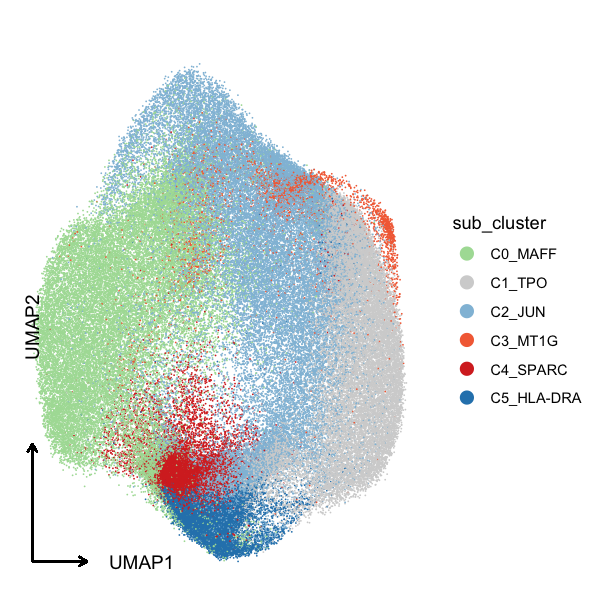

In [6]:
umap = as.data.frame(srt@reductions$umap@cell.embeddings)
colnames(umap) = c('UMAP_1', 'UMAP_2')
umap$sub_cluster = srt$sub_cluster
all_cells=umap %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  geom_point(aes(fill=sub_cluster),shape=21,size=0.5, stroke=NA)+
  scale_fill_manual(values = all_subtype_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
  )+
  guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')+
  geom_segment(aes(x=min(umap$UMAP_1, na.rm = T), y=min(umap$UMAP_2), xend=min(umap$UMAP_1)+2, yend=min(umap$UMAP_2)),
               colour="black", size=0.5,arrow = arrow(length=unit(0.2,"cm")))+ 
  geom_segment(aes(x = min(umap$UMAP_1), y = min(umap$UMAP_2), xend = min(umap$UMAP_1), yend=min(umap$UMAP_2)+2),
               colour = "black", size=0.5,arrow = arrow(length = unit(0.2,"cm"))) +
  annotate("text", x = min(umap$UMAP_1)+4, y = min(umap$UMAP_2), label = "UMAP1",
           color="black",size = 4) + 
  annotate("text", x = min(umap$UMAP_1), y = min(umap$UMAP_2)+4, label = "UMAP2",
           color="black",size = 4, angle=90) 
legend <- get_legend(all_cells)
options(repr.plot.width=5, repr.plot.height=5)
all_cells

ggsave(glue('{output_dir}/Epithelial_cell_subtypeUMAP(legend).pdf'),
       plot = legend, width = 5, height = 5)
all_cells=all_cells+NoLegend()
ggsave(glue('{output_dir}/Epithelial_cell_subtypeUMAP(cells).pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')


# Malignant trajectory

In [4]:
pc_df = readRDS('../organized_data/trajectory_projection_97sample.rds')
splinefit = readRDS("'../organized_data/trajectory_projection_97samplesplinefit.rds'")
all_FC_test = readRDS('../output/97sample_FoldChange.rds')

In [5]:
 tmp_meta = distinct(srt@meta.data[,c('orig.ident', 'patient','Coexisting_HT', 'Tumor_metastasis')])
 tmp_meta[tmp_meta$orig.ident%in% c(  'TC063_B',
  'TC063_P',
  'TC064_B',
  'TC064_P',
  'TC065_B',
  'TC065_P',
  'TC066_B',
  'TC066_P',
  'TC068_B',
  'TC068_P'), 'Coexisting_HT'] = 'No'
  rownames(tmp_meta) = tmp_meta$orig.ident
tmp_meta[tmp_meta$patient%in% c('PTC35','PTC36'), 'Coexisting_HT'] = 'No'
tmp_meta[tmp_meta$patient%in% c('PTC35','PTC36'), 'Tumor_metastasis'] = 'Non-metastasis'
 

In [6]:
pc_df$Coexisting_HT = tmp_meta[pc_df$sample, 'Coexisting_HT']
pc_df$Tumor_metastasis = tmp_meta[pc_df$sample, 'Tumor_metastasis']

## Pseudotime coloring

In [14]:
fold_res = 4.741725
malignancy_colors <- c("#E0F3F8", "#ABD9E9", "#FFFFBF", "#FDAE61", "#D7191C")

tmp_pc_df = pc_df

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1) + :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1), :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1) + :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1), :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `ann

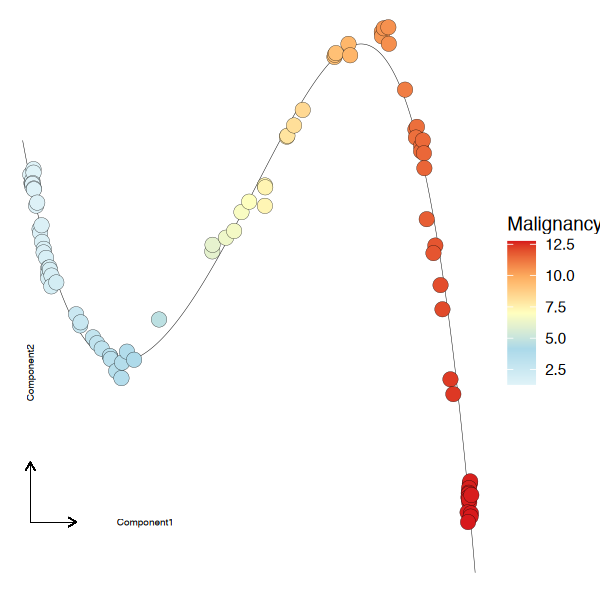

In [10]:
fold_res = 4.741725
malignancy_colors <- c("#E0F3F8", "#ABD9E9", "#FFFFBF", "#FDAE61", "#D7191C")

tmp_pc_df = pc_df
a=tmp_pc_df %>%
  ggplot(aes(x=PC1, y=PC2))+
  geom_line(data=splinefit,  linewidth=0.1) +
  geom_point(aes(fill=Pseudotime),size=4, shape=21, , stroke=0.1) +
  scale_color_npg()+
  scale_fill_gradientn(colours = c("#E0F3F8", "#ABD9E9", "#FFFFBF", "#FDAE61", "#D7191C"),name='Malignancy')+
  theme_void()+
  geom_segment(aes(x=min(PC1), y=min(PC2), xend=min(PC1)+1.2, yend=min(PC2)),
               colour="black", size=0.2,arrow = arrow(length=unit(0.2,"cm")))+ 
  geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1), yend=min(PC2)+1.2/fold_res),
               colour = "black", size=0.2,arrow = arrow(length = unit(0.2,"cm"))) +
  annotate("text", x = min(tmp_pc_df$PC1)+3, y = min(tmp_pc_df$PC2), label = "Component1",
           color="black",size = 2) + 
  annotate("text", x = min(tmp_pc_df$PC1), y = min(tmp_pc_df$PC2)+3/fold_res, label = "Component2",
           color="black",size = 2, angle=90) 
options(repr.plot.width=5, repr.plot.height=5)
a
ggsave(glue('{output_dir}/malignant_trajectory(pseudotimecoloring_legend).pdf'),
       plot = get_legend(a), width = 5, height = 5)
ggsave(glue('{output_dir}/malignant_trajectory(pseudotimecoloring).pdf'), a+NoLegend(),
       width=70, height=60, units='mm', dpi = 450, bg = 'transparent')


## Distribution characteristics of benign nodules and paired benign

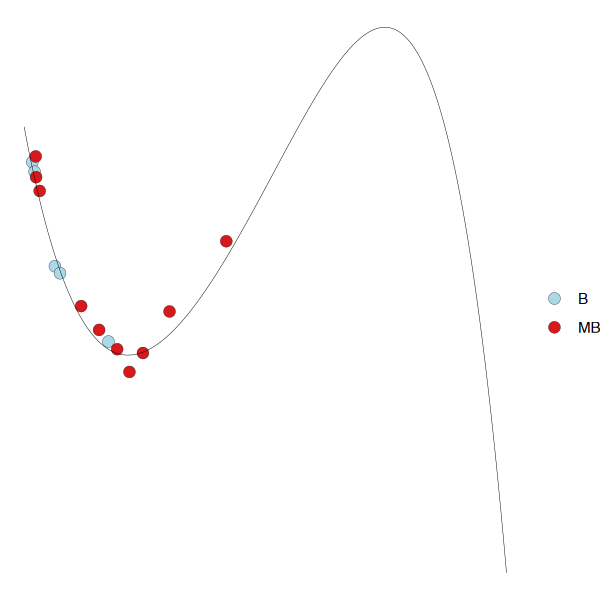

In [11]:
fold_res = (max(pc_df$PC1)-min(pc_df$PC1)) / (max(pc_df$PC2)-min(pc_df$PC2))
fold_res = 4.741725
tmp_pc_df = pc_df
a=tmp_pc_df %>%
  filter(Tissue_desc=='B') %>%
  mutate(new_Tissue=ifelse(new_Tissue=='B', 'MB', 'B')) %>%
  ggplot(aes(x=PC1, y=PC2)) +
  geom_point(aes(fill=new_Tissue),size=3, shape=21, stroke=0.1) +
  #scale_fill_igv()+
  scale_fill_manual(values = c('B'='#ABD9E9', 'MB'='#D7191C'), name='')+
  geom_line(data=splinefit, colour="black", linewidth=0.1) +
  labs(x='Component 1', y='Component2')+
  theme_void()
a
ggsave(glue('{output_dir}/malignant_trajectory_tissuecoloring(newpure_benign).pdf'), a,
       width=100, height=60, units='mm', dpi = 450, bg = 'transparent')

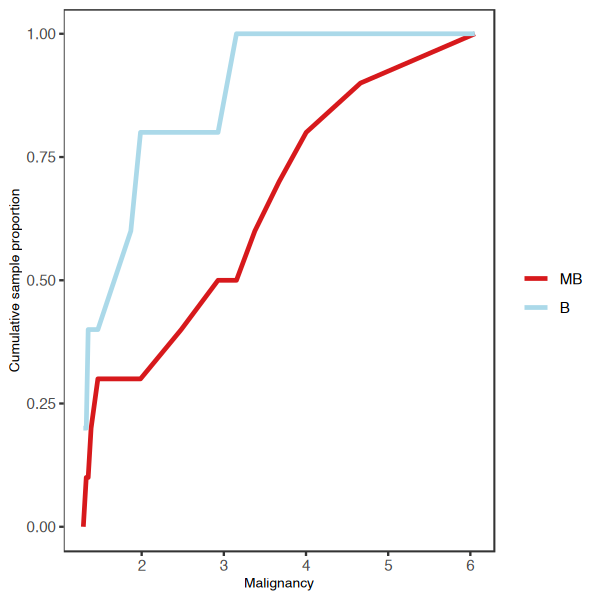

In [12]:

tmp_pc_df2 = tmp_pc_df %>%
  filter(Tissue_desc=='B') %>%
  mutate(new_Tissue=ifelse(new_Tissue=='B', 'MB', 'B')) %>% arrange(Pseudotime)
tmp_pc_df2[,'B'] = cumsum(tmp_pc_df2$new_Tissue=='B')
tmp_pc_df2[,'MB'] = cumsum(tmp_pc_df2$new_Tissue=='MB')

tmp_pc_df2[,'B'] = tmp_pc_df2[,'B'] / max(tmp_pc_df2[,'B'])
tmp_pc_df2[,'MB'] = tmp_pc_df2[,'MB'] / max(tmp_pc_df2[,'MB'])


a1=reshape2::melt(tmp_pc_df2[, c('Pseudotime', 'MB','B')], id='Pseudotime')
a = a1 %>%
  #mutate(variable=factor(variable, c('Yes','No'))) %>%
  ggplot(aes(x=Pseudotime, y=value, color=variable))+
  geom_line(size=1)+
  scale_color_manual(values = c('B'='#ABD9E9', 'MB'='#D7191C'), name='')+
  labs(x='Malignancy', y='Cumulative sample proportion')+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.title = element_text(size=8))

a
ggsave(glue('{output_dir}/malignant_trajectory(pure_benigncumulativedistribution).pdf'), a,
       width=85, height=50, units='mm', dpi = 450, bg = 'transparent')


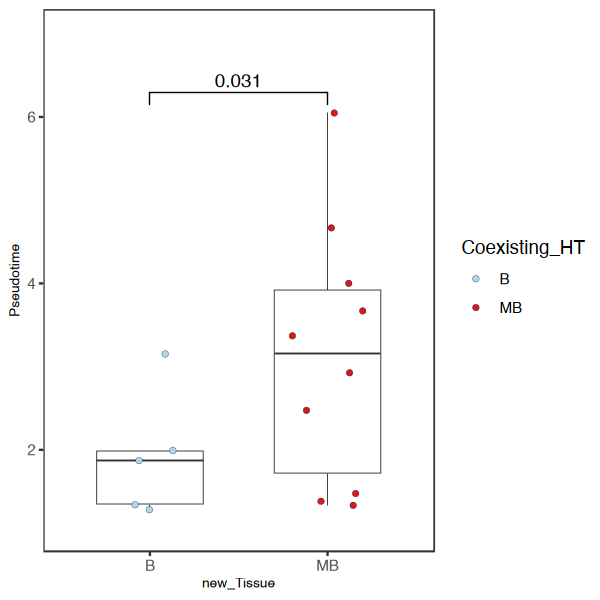

In [19]:
a = tmp_pc_df %>%
  filter(Tissue_desc=='B') %>%
  mutate(new_Tissue=ifelse(new_Tissue=='B', 'MB', 'B')) %>%
    #mutate(Coexisting_HT=factor(Coexisting_HT, c('Yes', 'No'))) %>%
    ggplot(aes(x=new_Tissue, y=Pseudotime)) +
    geom_boxplot(width=0.6, size=0.2, outlier.shape = NA)+
    geom_jitter(aes(fill=new_Tissue),size=1.5, shape=21, , stroke=0.1, width=0.2) +
    stat_compare_means(comparisons = list(c('B', 'MB')),label='p.format', 
    method.args = list(alternative='less'), method='t.test')+
    scale_fill_manual(values = c('B'='#ABD9E9', 'MB'='#D7191C'),name='Coexisting_HT')+
    scale_y_continuous(expand=c(0.1,0,0.2,0))+
    theme_bw()+
    theme(panel.grid = element_blank(),
          axis.title = element_text(size=8))
a
ggsave(glue('{output_dir}/malignant_trajectory(pure_benignbox_plot).pdf'), a,
       width=70, height=50, units='mm', dpi = 450, bg = 'transparent')

## Hashimoto's coloring

### Primary tumor

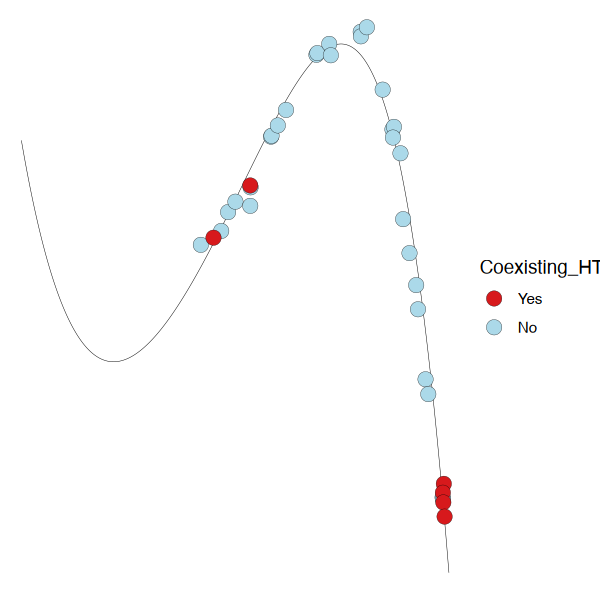

In [27]:

#### Hashimoto's coloring ####
fold_res = 4.741725
malignancy_colors <- c("#E0F3F8", "#ABD9E9", "#FFFFBF", "#FDAE61", "#D7191C")

tmp_pc_df = pc_df
a=tmp_pc_df %>%
  filter(!is.na(Coexisting_HT)) %>%
  filter(Tissue_desc=='T') %>%
  mutate(Coexisting_HT=factor(Coexisting_HT, c('Yes', 'No'))) %>%
  arrange(desc(Coexisting_HT)) %>%
  ggplot(aes(x=PC1, y=PC2))+
  geom_line(data=splinefit,  linewidth=0.1) +
  geom_point(aes(fill=Coexisting_HT),size=4, shape=21, , stroke=0.1) +
  scale_fill_manual(values = c('No'='#ABD9E9', 'Yes'='#D7191C'),name='Coexisting_HT')+
  theme_void()
a
ggsave(glue('{output_dir}/malignant_trajectory(hashimotocoloring_legend).pdf'),
       plot = get_legend(a), width = 5, height = 5)
ggsave(glue('{output_dir}/malignant_trajectory(hashimotocoloring).pdf'), a+NoLegend(),
       width=70, height=60, units='mm', dpi = 450, bg = 'transparent')


In [560]:
head(tmp_pc_df  )

sample  PC1      PC2       Tissue_desc Tumor_metastasis patient Coexisting_HT
1 TC068_B 1.301533 0.3707070 B           B                PTC41   No           
2 CTC08_P 1.332913 0.3349190 P           P                PTC25   NA           
3 TC029_P 1.339414 0.3398646 P           P                PTC13   No           
4 TC055_B 1.384234 0.3940609 B           B                PTC36   Yes          
5 TC048_P 1.352291 0.3485337 P           P                PTC33   No           
6 TC055_P 1.385607 0.3792034 P           P                PTC36   Yes          
  new_Tissue smooth_PC1 smooth_PC2 Pseudotime Pseudotime_cut
1 NB         1.301533   0.3707070  1.290218   a             
2 P          1.332913   0.3349190  1.325597   a             
3 P          1.339414   0.3398646  1.325597   a             
4 B          1.384234   0.3940609  1.325597   a             
5 P          1.352291   0.3485337  1.337390   a             
6 P          1.385607   0.3792034  1.337390   a

In [559]:
table(tmp_pc_df$Coexisting_HT, tmp_pc_df$patient)

     
      PTC01 PTC02 PTC03 PTC04 PTC05 PTC06 PTC07 PTC08 PTC09 PTC10 PTC11 PTC12
  No      0     4     0     2     3     3     0     2     0     3     2     4
  Yes     2     0     2     0     0     0     3     0     0     0     0     0
     
      PTC13 PTC14 PTC15 PTC16 PTC17 PTC18 PTC19 PTC20 PTC21 PTC22 PTC23 PTC24
  No      2     0     3     3     3     3     2     2     2     2     0     0
  Yes     0     2     0     0     0     0     0     0     0     0     1     0
     
      PTC25 PTC26 PTC27 PTC28 PTC29 PTC30 PTC31 PTC32 PTC33 PTC34 PTC35 PTC36
  No      0     1     1     1     1     3     1     3     3     0     0     0
  Yes     0     0     0     0     0     0     0     0     0     3     3     3
     
      PTC37 PTC38 PTC39 PTC40 PTC41
  No      2     2     2     2     2
  Yes     0     0     0     0     0

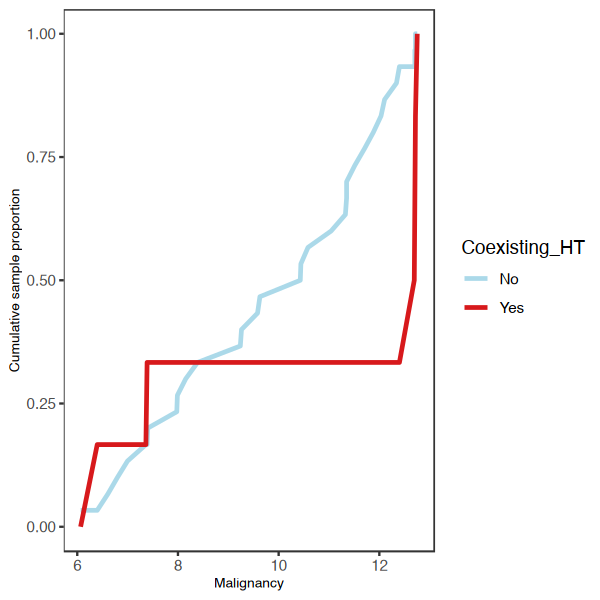

In [28]:

tmp_pc_df2 = tmp_pc_df %>%   filter(Tissue_desc=='T') %>% filter(!is.na(Coexisting_HT)) %>% arrange(Pseudotime)
tmp_pc_df2[,'No'] = cumsum(tmp_pc_df2$Coexisting_HT=='No')
tmp_pc_df2[,'Yes'] = cumsum(tmp_pc_df2$Coexisting_HT=='Yes')

tmp_pc_df2[,'No'] = tmp_pc_df2[,'No'] / max(tmp_pc_df2[,'No'])
tmp_pc_df2[,'Yes'] = tmp_pc_df2[,'Yes'] / max(tmp_pc_df2[,'Yes'])


a1=reshape2::melt(tmp_pc_df2[, c('Pseudotime', 'No','Yes')], id='Pseudotime')
a = a1 %>%
  #mutate(variable=factor(variable, c('Yes','No'))) %>%
  ggplot(aes(x=Pseudotime, y=value, color=variable))+
  geom_line(size=1)+
  scale_color_manual(values = c('No'='#ABD9E9', 'Yes'='#D7191C'),name='Coexisting_HT')+
  labs(x='Malignancy', y='Cumulative sample proportion')+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.title = element_text(size=8))

a
ggsave(glue('{output_dir}/malignant_trajectory(hashimotocumulativedistribution).pdf'), a,
       width=85, height=50, units='mm', dpi = 450, bg = 'transparent')


Warning message in wilcox.test.default(c(6.396526480664, 7.38712665432725, 12.6939132989518, :
“cannot compute exact p-value with ties”


Warning message in wilcox.test.default(c(6.396526480664, 7.38712665432725, 12.6939132989518, :
“cannot compute exact p-value with ties”


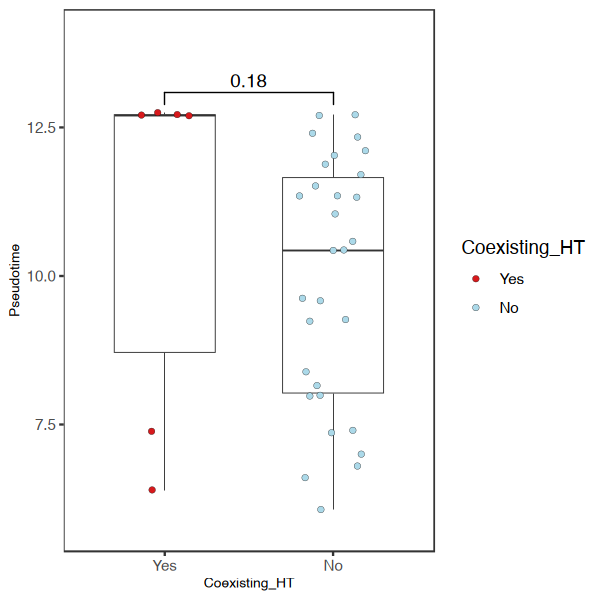

In [56]:
a = tmp_pc_df %>%
    filter(Tissue_desc=='T') %>% 
    filter(!is.na(Coexisting_HT)) %>%
    mutate(Coexisting_HT=factor(Coexisting_HT, c('Yes', 'No'))) %>%
    ggplot(aes(x=Coexisting_HT, y=Pseudotime)) +
    geom_boxplot(width=0.6, size=0.2)+
    geom_jitter(aes(fill=Coexisting_HT),size=1.5, shape=21, , stroke=0.1, width=0.2) +
    stat_compare_means(comparisons = list(c('Yes', 'No')),label='p.format')+
    scale_fill_manual(values = c('No'='#ABD9E9', 'Yes'='#D7191C'),name='Coexisting_HT')+
    scale_y_continuous(expand=c(0.1,0,0.2,0))+
    theme_bw()+
    theme(panel.grid = element_blank(),
          axis.title = element_text(size=8))
a
ggsave(glue('{output_dir}/malignant_trajectory(hashimotobox_plot).pdf'), a,
       width=70, height=50, units='mm', dpi = 450, bg = 'transparent')

### Paracancerous

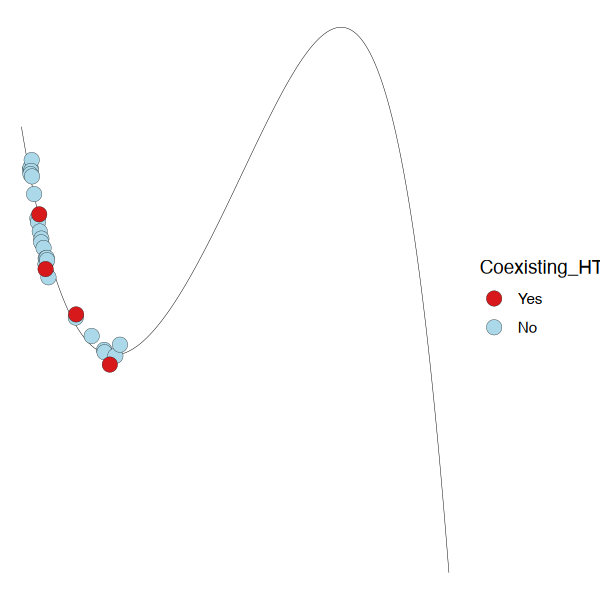

In [57]:
# P+T

fold_res = 4.741725
malignancy_colors <- c("#E0F3F8", "#ABD9E9", "#FFFFBF", "#FDAE61", "#D7191C")

tmp_pc_df = pc_df
a=tmp_pc_df %>%
  filter(!is.na(Coexisting_HT)) %>%
  filter(Tissue_desc%in%c('P')) %>%
  mutate(Coexisting_HT=factor(Coexisting_HT, c('Yes', 'No'))) %>%
  arrange(desc(Coexisting_HT)) %>%
  ggplot(aes(x=PC1, y=PC2))+
  geom_line(data=splinefit,  linewidth=0.1) +
  geom_point(aes(fill=Coexisting_HT),size=4, shape=21, , stroke=0.1) +
  scale_fill_manual(values = c('No'='#ABD9E9', 'Yes'='#D7191C'),name='Coexisting_HT')+
  theme_void()
a
ggsave(glue('{output_dir}/malignant_trajectory(hashimotocoloring5_legend).pdf'),
       plot = get_legend(a), width = 5, height = 5)
ggsave(glue('{output_dir}/malignant_trajectory(hashimotocoloring5).pdf'), a+NoLegend(),
       width=70, height=60, units='mm', dpi = 450, bg = 'transparent')


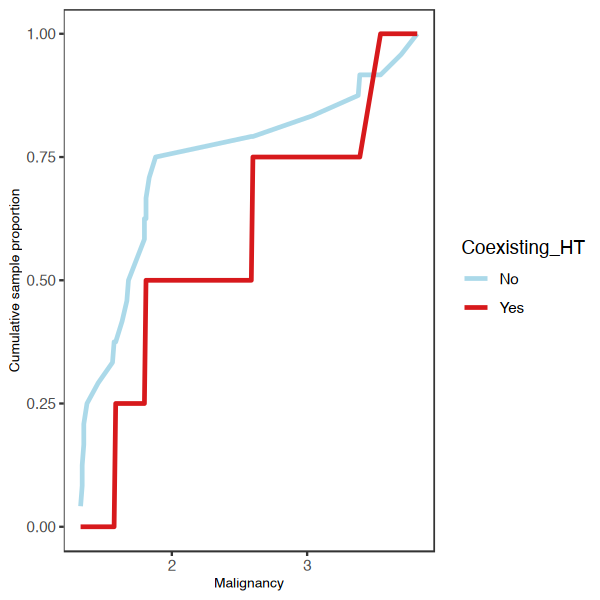

In [58]:

tmp_pc_df2 = tmp_pc_df %>%   filter(Tissue_desc%in%c('P')) %>% filter(!is.na(Coexisting_HT)) %>% arrange(Pseudotime)
tmp_pc_df2[,'No'] = cumsum(tmp_pc_df2$Coexisting_HT=='No')
tmp_pc_df2[,'Yes'] = cumsum(tmp_pc_df2$Coexisting_HT=='Yes')

tmp_pc_df2[,'No'] = tmp_pc_df2[,'No'] / max(tmp_pc_df2[,'No'])
tmp_pc_df2[,'Yes'] = tmp_pc_df2[,'Yes'] / max(tmp_pc_df2[,'Yes'])


a1=reshape2::melt(tmp_pc_df2[, c('Pseudotime', 'No','Yes')], id='Pseudotime')
a = a1 %>%
  #mutate(variable=factor(variable, c('Yes','No'))) %>%
  ggplot(aes(x=Pseudotime, y=value, color=variable))+
  geom_line(size=1)+
  scale_color_manual(values = c('No'='#ABD9E9', 'Yes'='#D7191C'),name='Coexisting_HT')+
  labs(x='Malignancy', y='Cumulative sample proportion')+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.title = element_text(size=8))

a
ggsave(glue('{output_dir}/malignant_trajectory(hashimotocumulativedistribution5).pdf'), a,
       width=85, height=50, units='mm', dpi = 450, bg = 'transparent')


Warning message in wilcox.test.default(c(1.58503992287104, 1.8091042478663, 2.59922581495485, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(1.58503992287104, 1.8091042478663, 2.59922581495485, :
“cannot compute exact p-value with ties”


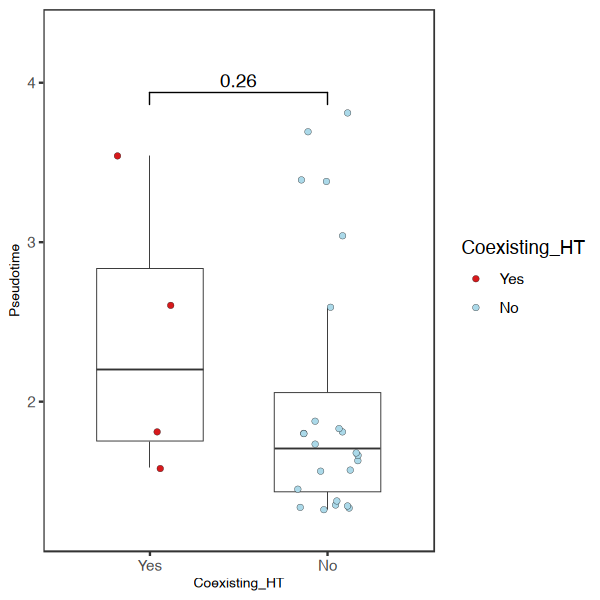

In [60]:
a = tmp_pc_df %>%
    filter(Tissue_desc=='P') %>% 
    filter(!is.na(Coexisting_HT)) %>%
    mutate(Coexisting_HT=factor(Coexisting_HT, c('Yes', 'No'))) %>%
    ggplot(aes(x=Coexisting_HT, y=Pseudotime)) +
    geom_boxplot(width=0.6, size=0.2, outlier.shape = NA)+
    geom_jitter(aes(fill=Coexisting_HT),size=1.5, shape=21, , stroke=0.1, width=0.2) +
    stat_compare_means(comparisons = list(c('Yes', 'No')),label='p.format')+
    scale_fill_manual(values = c('No'='#ABD9E9', 'Yes'='#D7191C'),name='Coexisting_HT')+
    scale_y_continuous(expand=c(0.1,0,0.2,0))+
    theme_bw()+
    theme(panel.grid = element_blank(),
          axis.title = element_text(size=8))
a
ggsave(glue('{output_dir}/malignant_trajectory(hashimotobox_plot5).pdf'), a,
       width=70, height=50, units='mm', dpi = 450, bg = 'transparent')

### Paracancerous + primary tumor

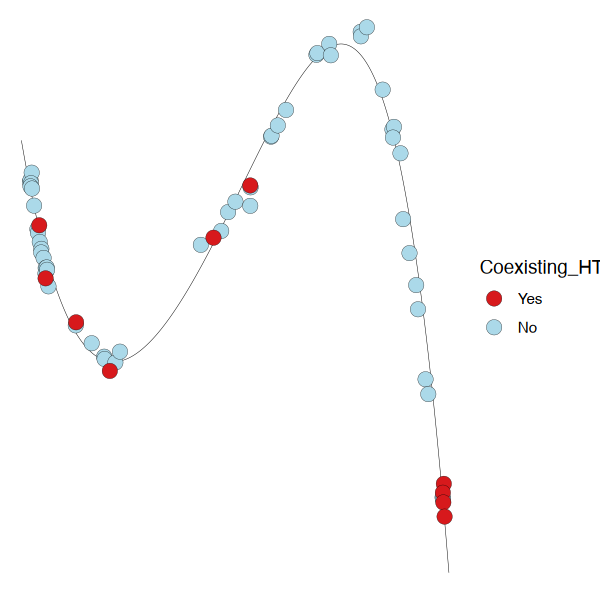

In [61]:
# P+T

fold_res = 4.741725
malignancy_colors <- c("#E0F3F8", "#ABD9E9", "#FFFFBF", "#FDAE61", "#D7191C")

tmp_pc_df = pc_df
a=tmp_pc_df %>%
  filter(!is.na(Coexisting_HT)) %>%
  filter(Tissue_desc%in%c('T', 'P')) %>%
  mutate(Coexisting_HT=factor(Coexisting_HT, c('Yes', 'No'))) %>%
  arrange(desc(Coexisting_HT)) %>%
  ggplot(aes(x=PC1, y=PC2))+
  geom_line(data=splinefit,  linewidth=0.1) +
  geom_point(aes(fill=Coexisting_HT),size=4, shape=21, , stroke=0.1) +
  scale_fill_manual(values = c('No'='#ABD9E9', 'Yes'='#D7191C'),name='Coexisting_HT')+
  theme_void()
a
ggsave(glue('{output_dir}/malignant_trajectory(hashimotocoloring2_legend).pdf'),
       plot = get_legend(a), width = 5, height = 5)
ggsave(glue('{output_dir}/malignant_trajectory(hashimotocoloring2).pdf'), a+NoLegend(),
       width=70, height=60, units='mm', dpi = 450, bg = 'transparent')


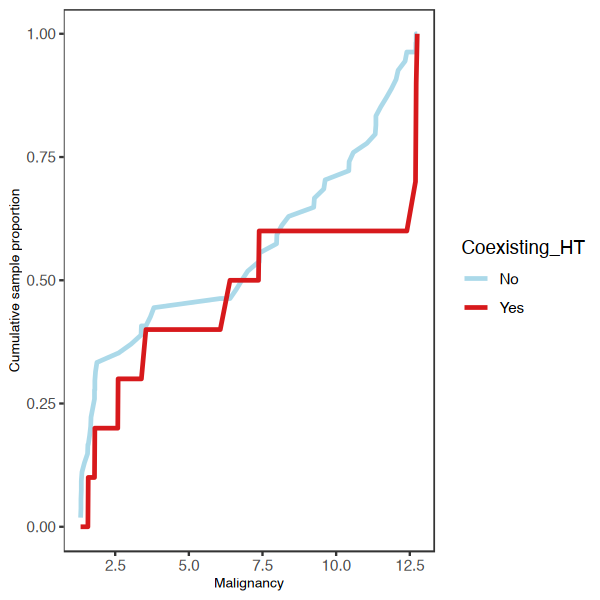

In [62]:

tmp_pc_df2 = tmp_pc_df %>%   filter(Tissue_desc%in%c('T', 'P')) %>% filter(!is.na(Coexisting_HT)) %>% arrange(Pseudotime)
tmp_pc_df2[,'No'] = cumsum(tmp_pc_df2$Coexisting_HT=='No')
tmp_pc_df2[,'Yes'] = cumsum(tmp_pc_df2$Coexisting_HT=='Yes')

tmp_pc_df2[,'No'] = tmp_pc_df2[,'No'] / max(tmp_pc_df2[,'No'])
tmp_pc_df2[,'Yes'] = tmp_pc_df2[,'Yes'] / max(tmp_pc_df2[,'Yes'])


a1=reshape2::melt(tmp_pc_df2[, c('Pseudotime', 'No','Yes')], id='Pseudotime')
a = a1 %>%
  #mutate(variable=factor(variable, c('Yes','No'))) %>%
  ggplot(aes(x=Pseudotime, y=value, color=variable))+
  geom_line(size=1)+
  scale_color_manual(values = c('No'='#ABD9E9', 'Yes'='#D7191C'),name='Coexisting_HT')+
  labs(x='Malignancy', y='Cumulative sample proportion')+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.title = element_text(size=8))

a
ggsave(glue('{output_dir}/malignant_trajectory(hashimotocumulativedistribution2).pdf'), a,
       width=85, height=50, units='mm', dpi = 450, bg = 'transparent')


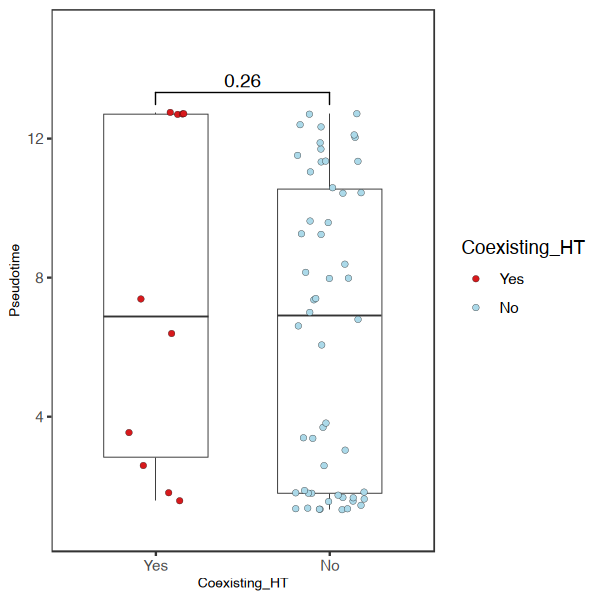

In [63]:
a = tmp_pc_df %>%
    filter(Tissue_desc%in%c('T', 'P')) %>% 
    filter(!is.na(Coexisting_HT)) %>%
    mutate(Coexisting_HT=factor(Coexisting_HT, c('Yes', 'No'))) %>%
    ggplot(aes(x=Coexisting_HT, y=Pseudotime)) +
    geom_boxplot(width=0.6, size=0.2, outlier.shape = NA)+
    geom_jitter(aes(fill=Coexisting_HT),size=1.5, shape=21, , stroke=0.1, width=0.2) +
    stat_compare_means(comparisons = list(c('Yes', 'No')),label='p.format')+
    scale_fill_manual(values = c('No'='#ABD9E9', 'Yes'='#D7191C'),name='Coexisting_HT')+
    scale_y_continuous(expand=c(0.1,0,0.2,0))+
    theme_bw()+
    theme(panel.grid = element_blank(),
          axis.title = element_text(size=8))
a
ggsave(glue('{output_dir}/malignant_trajectory(hashimotobox_plot2).pdf'), a,
       width=70, height=50, units='mm', dpi = 450, bg = 'transparent')

### Paired benign nodule patients

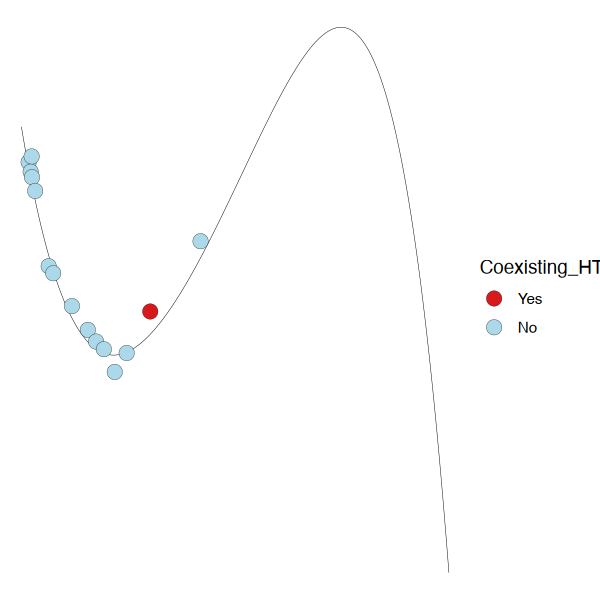

In [64]:
# Paired benign nodule patients
fold_res = 4.741725
malignancy_colors <- c("#E0F3F8", "#ABD9E9", "#FFFFBF", "#FDAE61", "#D7191C")

tmp_pc_df = pc_df
a=tmp_pc_df %>%
  filter(!is.na(Coexisting_HT)) %>%
  filter(Tissue_desc%in%c('B')) %>%
  mutate(Coexisting_HT=factor(Coexisting_HT, c('Yes', 'No'))) %>%
  arrange(desc(Coexisting_HT)) %>%
  ggplot(aes(x=PC1, y=PC2))+
  geom_line(data=splinefit,  linewidth=0.1) +
  geom_point(aes(fill=Coexisting_HT),size=4, shape=21, , stroke=0.1) +
  scale_fill_manual(values = c('No'='#ABD9E9', 'Yes'='#D7191C'),name='Coexisting_HT')+
  theme_void()
a
ggsave(glue('{output_dir}/malignant_trajectory(hashimotocoloring3_legend).pdf'),
       plot = get_legend(a), width = 5, height = 5)
ggsave(glue('{output_dir}/malignant_trajectory(hashimotocoloring3).pdf'), a+NoLegend(),
       width=70, height=60, units='mm', dpi = 450, bg = 'transparent')


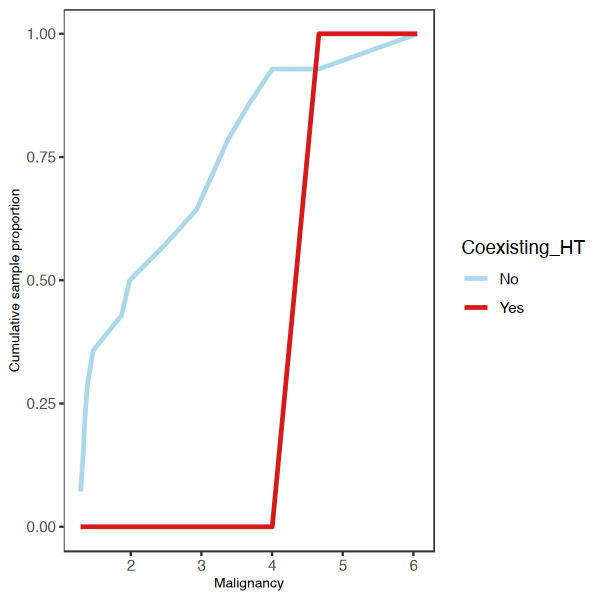

In [65]:

tmp_pc_df2 = tmp_pc_df %>%   filter(Tissue_desc%in%c('B')) %>% filter(!is.na(Coexisting_HT)) %>% arrange(Pseudotime)
tmp_pc_df2[,'No'] = cumsum(tmp_pc_df2$Coexisting_HT=='No')
tmp_pc_df2[,'Yes'] = cumsum(tmp_pc_df2$Coexisting_HT=='Yes')

tmp_pc_df2[,'No'] = tmp_pc_df2[,'No'] / max(tmp_pc_df2[,'No'])
tmp_pc_df2[,'Yes'] = tmp_pc_df2[,'Yes'] / max(tmp_pc_df2[,'Yes'])


a1=reshape2::melt(tmp_pc_df2[, c('Pseudotime', 'No','Yes')], id='Pseudotime')
a = a1 %>%
  #mutate(variable=factor(variable, c('Yes','No'))) %>%
  ggplot(aes(x=Pseudotime, y=value, color=variable))+
  geom_line(size=1)+
  scale_color_manual(values = c('No'='#ABD9E9', 'Yes'='#D7191C'),name='Coexisting_HT')+
  labs(x='Malignancy', y='Cumulative sample proportion')+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.title = element_text(size=8))

a
ggsave(glue('{output_dir}/malignant_trajectory(hashimotocumulativedistribution3).pdf'), a,
       width=85, height=50, units='mm', dpi = 450, bg = 'transparent')


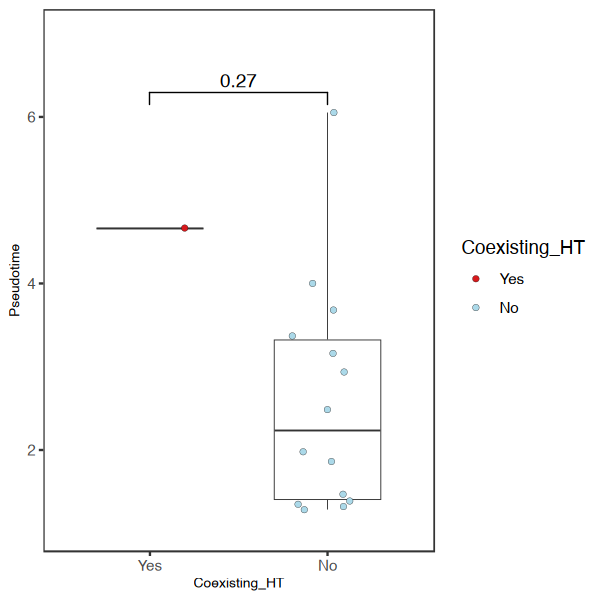

In [66]:
a = tmp_pc_df %>%
    filter(Tissue_desc%in%c('B')) %>% filter(!is.na(Coexisting_HT)) %>%
    mutate(Coexisting_HT=factor(Coexisting_HT, c('Yes', 'No'))) %>%
    ggplot(aes(x=Coexisting_HT, y=Pseudotime)) +
    geom_boxplot(width=0.6, size=0.2, outlier.shape = NA)+
    geom_jitter(aes(fill=Coexisting_HT),size=1.5, shape=21, , stroke=0.1, width=0.2) +
    stat_compare_means(comparisons = list(c('Yes', 'No')),label='p.format')+
    scale_fill_manual(values = c('No'='#ABD9E9', 'Yes'='#D7191C'),name='Coexisting_HT')+
    scale_y_continuous(expand=c(0.1,0,0.2,0))+
    theme_bw()+
    theme(panel.grid = element_blank(),
          axis.title = element_text(size=8))
a
ggsave(glue('{output_dir}/malignant_trajectory(hashimotobox_plot3).pdf'), a,
       width=70, height=50, units='mm', dpi = 450, bg = 'transparent')

### Paired benign nodules in Hashimoto's

[1] "PTC12" "PTC05" "PTC06" "PTC30" "PTC32" "PTC33" "PTC34" "PTC35" "PTC36"

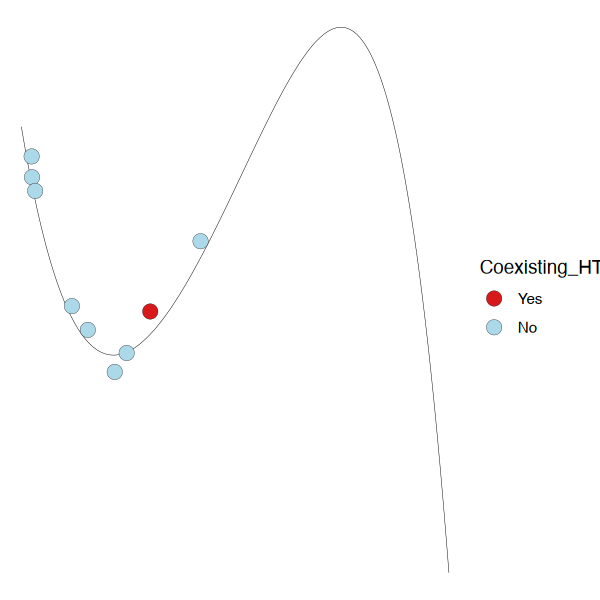

In [34]:
# Paired benign nodule patients
fold_res = 4.741725
malignancy_colors <- c("#E0F3F8", "#ABD9E9", "#FFFFBF", "#FDAE61", "#D7191C")

tmp_pc_df = pc_df
a=tmp_pc_df %>%
  filter(patient%in%B_patient2) %>%
  filter(!is.na(Coexisting_HT)) %>%
  filter(Tissue_desc%in%c('B')) %>%
  mutate(Coexisting_HT=factor(Coexisting_HT, c('Yes', 'No'))) %>%
  arrange(desc(Coexisting_HT)) %>%
  ggplot(aes(x=PC1, y=PC2))+
  geom_line(data=splinefit,  linewidth=0.1) +
  geom_point(aes(fill=Coexisting_HT),size=4, shape=21, , stroke=0.1) +
  scale_fill_manual(values = c('No'='#ABD9E9', 'Yes'='#D7191C'),name='Coexisting_HT')+
  theme_void()
a
ggsave(glue('{output_dir}/malignant_trajectory(hashimotocoloring4_legend).pdf'),
       plot = get_legend(a), width = 5, height = 5)
ggsave(glue('{output_dir}/malignant_trajectory(hashimotocoloring4).pdf'), a+NoLegend(),
       width=70, height=60, units='mm', dpi = 450, bg = 'transparent')


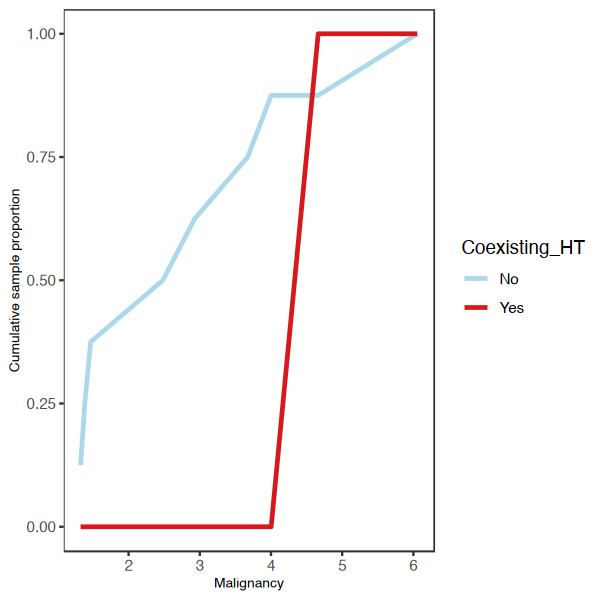

In [35]:

tmp_pc_df2 = tmp_pc_df %>%  filter(patient%in%B_patient2) %>%
  filter(!is.na(Coexisting_HT)) %>%
  filter(Tissue_desc%in%c('B')) %>% arrange(Pseudotime)
tmp_pc_df2[,'No'] = cumsum(tmp_pc_df2$Coexisting_HT=='No')
tmp_pc_df2[,'Yes'] = cumsum(tmp_pc_df2$Coexisting_HT=='Yes')

tmp_pc_df2[,'No'] = tmp_pc_df2[,'No'] / max(tmp_pc_df2[,'No'])
tmp_pc_df2[,'Yes'] = tmp_pc_df2[,'Yes'] / max(tmp_pc_df2[,'Yes'])


a1=reshape2::melt(tmp_pc_df2[, c('Pseudotime', 'No','Yes')], id='Pseudotime')
a = a1 %>%
  #mutate(variable=factor(variable, c('Yes','No'))) %>%
  ggplot(aes(x=Pseudotime, y=value, color=variable))+
  geom_line(size=1)+
  scale_color_manual(values = c('No'='#ABD9E9', 'Yes'='#D7191C'),name='Coexisting_HT')+
  labs(x='Malignancy', y='Cumulative sample proportion')+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.title = element_text(size=8))

a
ggsave(glue('{output_dir}/malignant_trajectory(hashimotocumulativedistribution4).pdf'), a,
       width=85, height=50, units='mm', dpi = 450, bg = 'transparent')


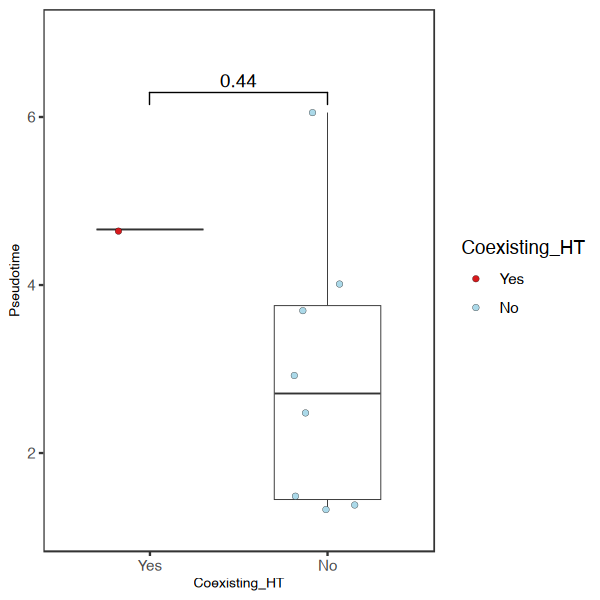

In [67]:
a = tmp_pc_df %>%  filter(patient%in%B_patient2) %>%
  filter(!is.na(Coexisting_HT)) %>%
  filter(Tissue_desc%in%c('B'))  %>%
    mutate(Coexisting_HT=factor(Coexisting_HT, c('Yes', 'No'))) %>%
    ggplot(aes(x=Coexisting_HT, y=Pseudotime)) +
    geom_boxplot(width=0.6, size=0.2, outlier.shape = NA)+
    geom_jitter(aes(fill=Coexisting_HT),size=1.5, shape=21, , stroke=0.1, width=0.2) +
    stat_compare_means(comparisons = list(c('Yes', 'No')),label='p.format')+
    scale_fill_manual(values = c('No'='#ABD9E9', 'Yes'='#D7191C'),name='Coexisting_HT')+
    scale_y_continuous(expand=c(0.1,0,0.2,0))+
    theme_bw()+
    theme(panel.grid = element_blank(),
          axis.title = element_text(size=8))
a
ggsave(glue('{output_dir}/malignant_trajectory(hashimotobox_plot4).pdf'), a,
       width=70, height=50, units='mm', dpi = 450, bg = 'transparent')

## Tissue coloring

Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1) + :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1), :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1) + :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1), :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), 

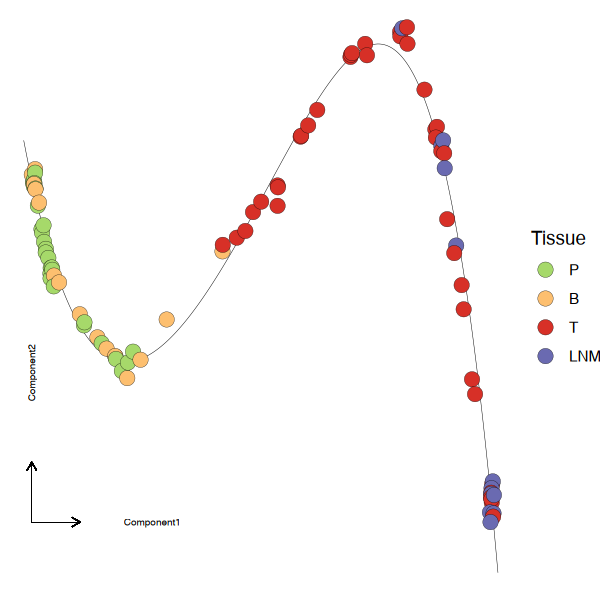

In [74]:

#### Tissue distribution in trajectory ####
tmp_pc_df2 = tmp_pc_df
#tmp_pc_df2$Tissue_desc[tmp_pc_df2$Tissue_desc=='P'] = 'N'
tmp_pc_df2$Tissue_desc[tmp_pc_df2$Tissue_desc=='LN_M'] = 'LNM'

a=tmp_pc_df2 %>%
  mutate(Tissue_desc=factor(Tissue_desc, c('P','B', 'T', 'LNM'))) %>%
  ggplot(aes(x=PC1, y=PC2))+
  geom_line(data=splinefit,  linewidth=0.1) +
  geom_point(aes(fill=Tissue_desc),size=4, shape=21, , stroke=0.1) +
  scale_fill_manual(values=tissue_colors, name='Tissue')+
  theme_void()+
  geom_segment(aes(x=min(PC1), y=min(PC2), xend=min(PC1)+1.2, yend=min(PC2)),
               colour="black", size=0.2,arrow = arrow(length=unit(0.2,"cm")))+ 
  geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1), yend=min(PC2)+1.2/fold_res),
               colour = "black", size=0.2,arrow = arrow(length = unit(0.2,"cm"))) +
  annotate("text", x = min(tmp_pc_df$PC1)+3, y = min(tmp_pc_df$PC2), label = "Component1",
           color="black",size = 2) + 
  annotate("text", x = min(tmp_pc_df$PC1), y = min(tmp_pc_df$PC2)+3/fold_res, label = "Component2",
           color="black",size = 2, angle=90) 
a
ggsave(glue('{output_dir}/malignant_trajectory(tissuecoloring_legend).pdf'),
       plot = get_legend(a), width = 5, height = 5)
ggsave(glue('{output_dir}/malignant_trajectory(tissuecoloring).pdf'), a+NoLegend(),
       width=70, height=60, units='mm', dpi = 450, bg = 'transparent')


## Metastasis coloring

Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1) + :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1), :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1) + :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1), :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), 

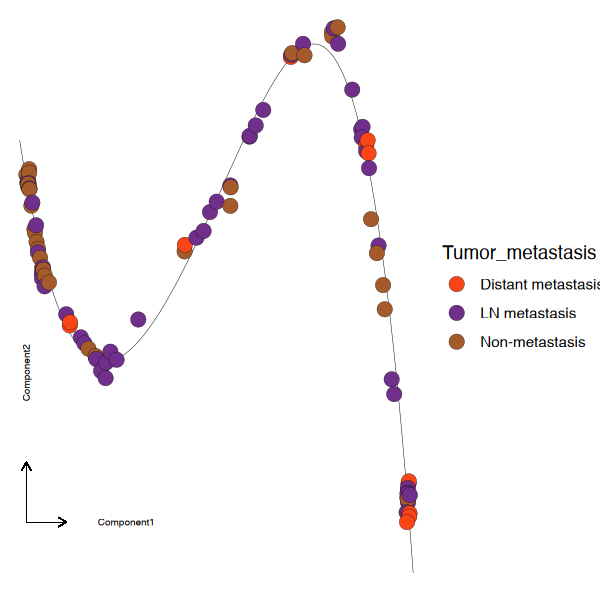

In [37]:

#### Metastasis trajectory distribution ####
a=tmp_pc_df %>%
  ggplot(aes(x=PC1, y=PC2))+
  geom_line(data=splinefit,  linewidth=0.1) +
  geom_point(aes(fill=Tumor_metastasis),size=4, shape=21, , stroke=0.1) +
  scale_fill_manual(values=c('B'="#FDBF6F", 'Non-metastasis'='#A45A2AFF', 
                              'Distant metastasis'='#FA4616FF', 'LN metastasis'='#702F8AFF',
                              'P'="#A6D96A")) + 
  theme_void()+
  geom_segment(aes(x=min(PC1), y=min(PC2), xend=min(PC1)+1.2, yend=min(PC2)),
               colour="black", size=0.2,arrow = arrow(length=unit(0.2,"cm")))+ 
  geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1), yend=min(PC2)+1.2/fold_res),
               colour = "black", size=0.2,arrow = arrow(length = unit(0.2,"cm"))) +
  annotate("text", x = min(tmp_pc_df$PC1)+3, y = min(tmp_pc_df$PC2), label = "Component1",
           color="black",size = 2) + 
  annotate("text", x = min(tmp_pc_df$PC1), y = min(tmp_pc_df$PC2)+3/fold_res, label = "Component2",
           color="black",size = 2, angle=90) 
a
ggsave(glue('{output_dir}/malignant_trajectory(metastasiscoloring_legend).pdf'),
       plot = get_legend(a), width = 5, height = 5)
ggsave(glue('{output_dir}/malignant_trajectory(metastasiscoloring).pdf'), a+NoLegend(),
       width=70, height=60, units='mm', dpi = 450, bg = 'transparent')


## Tissue cumulative distribution

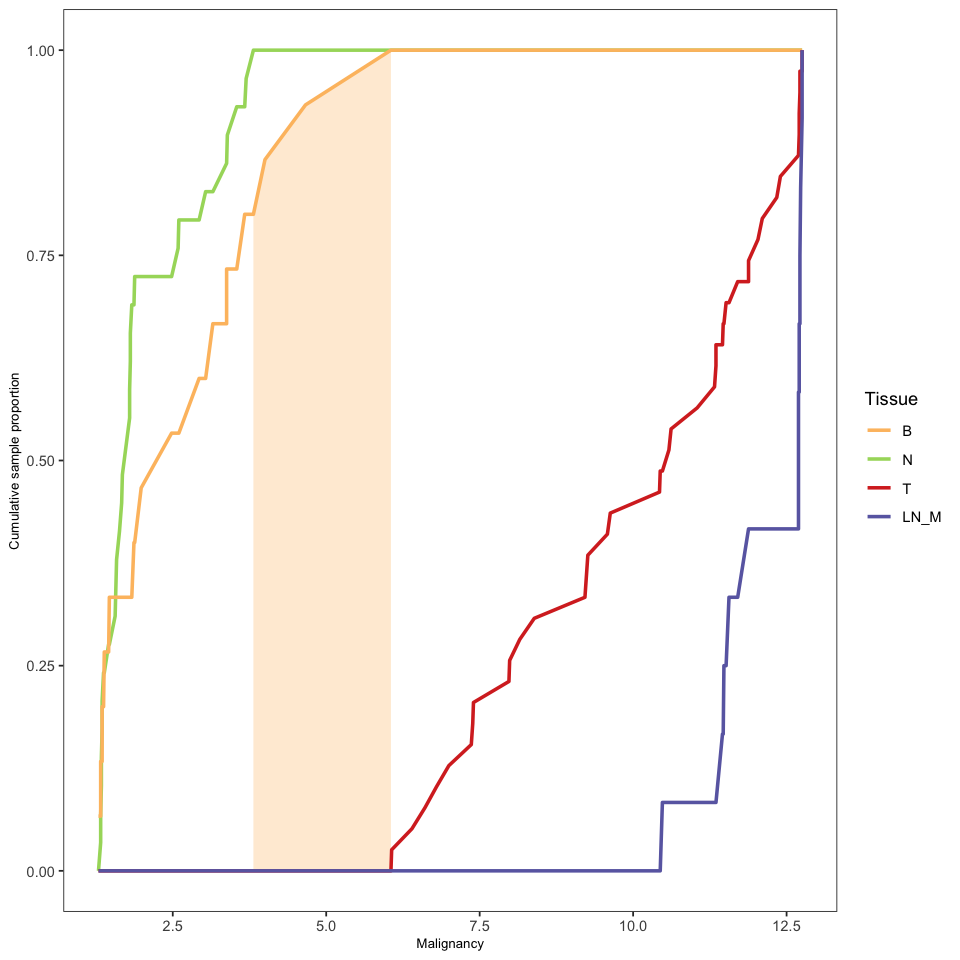

In [547]:
#### Tissue cumulative distribution #####
tmp_pc_df2 = tmp_pc_df %>% arrange(Pseudotime)
tmp_pc_df2[,'P'] = cumsum(tmp_pc_df2$Tissue_desc=='P')
tmp_pc_df2[,'B'] = cumsum(tmp_pc_df2$Tissue_desc=='B')
tmp_pc_df2[,'T'] = cumsum(tmp_pc_df2$Tissue_desc=='T')
tmp_pc_df2[,'LN_M'] = cumsum(tmp_pc_df2$Tissue_desc=='LN_M')
tmp_pc_df2[,'Distant metastasis'] = cumsum(tmp_pc_df2$Tumor_metastasis=='Distant metastasis')
tmp_pc_df2[,'LN metastasis'] = cumsum(tmp_pc_df2$Tumor_metastasis=='LN metastasis')
tmp_pc_df2[,'Non-metastasis'] = cumsum(tmp_pc_df2$Tumor_metastasis=='Non-metastasis')

tmp_pc_df2[,'P'] = tmp_pc_df2[,'P'] / max(tmp_pc_df2[,'P'])
tmp_pc_df2[,'B'] = tmp_pc_df2[,'B'] / max(tmp_pc_df2[,'B'])
tmp_pc_df2[,'T'] = tmp_pc_df2[,'T'] / max(tmp_pc_df2[,'T'])
tmp_pc_df2[,'LN_M'] = tmp_pc_df2[,'LN_M'] / max(tmp_pc_df2[,'LN_M'])

p_end_pos = which.max(tmp_pc_df2$P)
b_end_pos = which.max(tmp_pc_df2$B)

p_end_time = tmp_pc_df2$Pseudotime[which.max(tmp_pc_df2$P)]
b_end_time = tmp_pc_df2$Pseudotime[which.max(tmp_pc_df2$B)]


a1=reshape2::melt(tmp_pc_df2[, c('Pseudotime', 'P','B','T','LN_M'#,
                              #'Distant metastasis','LN metastasis','Non-metastasis' 
                              )],
               id='Pseudotime')
a2 = a1 %>% filter(Pseudotime >= p_end_time , 
                  Pseudotime <= b_end_time,
                  variable=='B')
a1$variable = as.vector(a1$variable)
a1$variable[a1$variable=='P'] = 'N'
a = a1 %>%
  mutate(variable=factor(variable, c('N','B','T','LN_M'))) %>%
  ggplot(aes(x=Pseudotime, y=value, color=variable))+
  #geom_vline(xintercept = p_end_time, linetype='dashed', color='gray', size=0.5)+
  #geom_vline(xintercept = b_end_time, linetype='dashed', color='gray', size=0.5)+
  geom_ribbon(data = a2, aes(ymin = 0, ymax = value), 
              fill = "#FDBF6F", alpha = 0.3, show.legend = F)+
  
  geom_line(size=1)+
  scale_color_manual(values = c( 'Non-metastasis'='#A45A2AFF', 
                                'Distant metastasis'='#FA4616FF', 'LN metastasis'='#702F8AFF','LN_M'='#6A6AB1',
                                'N'="#A6D96A",'B'="#FDBF6F", 'T'='#D73027'),
                     name='Tissue')+
  labs(x='Malignancy', y='Cumulative sample proportion')+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.title = element_text(size=8))

a
ggsave(glue('{output_dir}/malignant_trajectory(tissuecumulativedistribution).pdf'), a,
       width=85, height=60, units='mm', dpi = 450, bg = 'transparent')



## Score changes along trajectory

In [ ]:
#### Score changes along trajectory ####
DefaultAssay(srt) = 'RNA'
# srt = AddModuleScore(srt, features = list(TDS_marker,BRAF_marker, RAS_marker))

# sample_score = srt@meta.data %>% 
#   group_by(orig.ident) %>% 
#   summarise(TDS_score=mean(Cluster1),
#             BRAF_score=mean(Cluster2),
#             RAS_score=mean(Cluster3)) %>%
#   as.data.frame()
# rownames(sample_score) = sample_score$orig.ident
# tmp_pc_df[,c('TDS_score', 'BRAF_score', 'RAS_score')] = sample_score[tmp_pc_df$sample,c('TDS_score', 'BRAF_score', 'RAS_score')]


Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“The following features are not present in the object: ANXA2P2, not searching for symbol synonyms”


In [ ]:
library(AUCell)
library(sva)
geneSets <- list('TDS_score'=TDS_marker, 'BRAF_score'=BRAF_marker, 'RAS_score'=RAS_marker)

In [ ]:
# exprMatrix <- GetAssayData(srt, slot = "data")  # "data" is normalized data
# cells_rankings <- AUCell_buildRankings(exprMatrix, nCores = 10, plotStats = TRUE)
# cells_AUCell <- AUCell_calcAUC(geneSets, cells_rankings, nCores = 10)
# auc_matrix <- as.data.frame(getAUC(cells_AUCell))
# srt$Cluster1 <- as.numeric(auc_matrix['"TDS_score", colnames(srt)])

In [ ]:
# srt2 = readRDS('../output/clean_rds/All_ann_97.rds')
# srt2 = subset(srt2, Cluster=='Epithelial')
# srt2 = process_seurat_noIG(srt2)
# DimPlot(srt2, group.by = 'Tissue_desc') 

In [ ]:
# library(UCell)
# set.seed(123)
# srt2 = AddModuleScore_UCell(srt2, features = list(TDS_marker,BRAF_marker, RAS_marker))
# srt2 <- SmoothKNN(srt2, 
#     signature.names = c('signature_1_UCell','signature_2_UCell','signature_3_UCell'),
#     k=100,up.only = TRUE,decay = 0.001,
#     reduction = "harmony")

In [ ]:
# Extract sample expression matrix and metadata
sample_exp <- AverageExpression(srt, group.by = 'orig.ident')$RNA #%>% log1p()  # "data" is normalized data
colnames(sample_exp) <- gsub('"-", "_", colnames(sample_exp))
sample_meta <- srt2@meta.data[,c('orig.ident', 'batch', 'Tissue_desc', 'patient')] %>%
  distinct() %>% as.data.frame()
rownames(sample_meta) <- sample_meta$orig.ident
sample_meta$batch2 = paste0(sample_meta$batch, '_', sample_meta$Tissue_desc)

In [ ]:
# Use ComBat for batch effect correction
corrected <- ComBat(dat = as.matrix(sample_exp), 
                    batch = sample_meta[colnames(sample_exp), 'patient'])

Found 15514 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Using the 'mean only' version of ComBat

Found41batches

Note: one batch has only one sample, setting mean.only=TRUE

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




Warning message in .AUCell_buildRankings(exprMat = exprMat, featureType = featureType, :
“nCores is no longer used. It will be deprecated in the next AUCell version.”
Quantiles for the number of genes detected by cell: 
(Non-detected genes are shuffled at the end of the ranking. Keep it in mind when choosing the threshold for calculating the AUC).



     min       1%       5%      10%      50%     100% 
14413.00 14843.52 16184.30 17019.20 20363.00 23073.00 


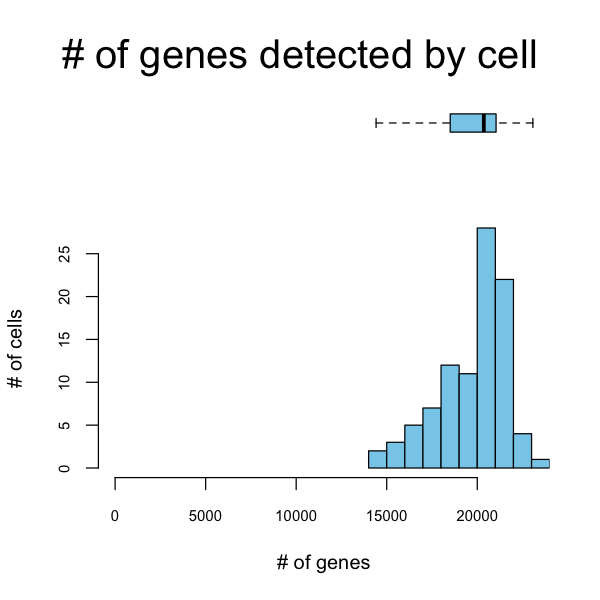

In [ ]:
# Calculate AUCell scores from corrected expression matrix
cells_rankings <- AUCell_buildRankings(corrected, nCores = 10, plotStats = TRUE)
cells_AUCell <- AUCell_calcAUC(geneSets, cells_rankings, nCores = 10)
auc_matrix <- as.data.frame(getAUC(cells_AUCell))

In [364]:
saveRDS(list(corrected=corrected, 
    auc_matrix=cells_rankings, sample_meta=sample_meta), 
        '../organized_data/97sample_batch_corrected_sample_expression.rds')

In [292]:
auc_matrix

CTC04_T    CTC07_T    CTC08_LN   CTC08_P    CTC08_T    P5206_3   
TDS_score  0.62483942 0.58727712 0.49586352 0.71147423 0.50238939 0.51908946
BRAF_score 0.21192982 0.19492120 0.21099019 0.04988403 0.23506393 0.22073149
RAS_score  0.07789939 0.07543292 0.06253533 0.14475104 0.07055136 0.06525872
           P5206_4   P5206_6    P5206_7    P5227_2    ⋯ TC063_B   TC063_P   
TDS_score  0.6750424 0.49781615 0.69014953 0.33066132 ⋯ 0.6530497 0.63742870
BRAF_score 0.1987273 0.22129051 0.03771632 0.28461493 ⋯ 0.1294915 0.13094261
RAS_score  0.0931093 0.06130209 0.12250141 0.02394533 ⋯ 0.1040543 0.09336622
           TC064_B    TC064_P    TC065_B   TC065_P   TC066_B   TC066_P  
TDS_score  0.63398592 0.62288680 0.6577257 0.6572119 0.6728328 0.6149222
BRAF_score 0.14466845 0.12959857 0.1299316 0.1315492 0.1312519 0.1195004
RAS_score  0.09711731 0.08689173 0.0995324 0.1257900 0.1074457 0.0731206
           TC068_B   TC068_P   
TDS_score  0.6601922 0.58260110
BRAF_score 0.1326554 0.12612548
RAS_score  0.1041570 0.08046863

In [293]:
# sample_score = srt2@meta.data %>% 
#   group_by(orig.ident) %>% 
#   summarise(TDS_score=mean(signature_1_UCell_kNN),
#             BRAF_score=mean(signature_2_UCell_kNN),
#             RAS_score=mean(signature_3_UCell_kNN)) %>%
#   as.data.frame()
# rownames(sample_score) = sample_score$orig.ident
# tmp_pc_df[,c('TDS_score', 'BRAF_score', 'RAS_score')] = sample_score[tmp_pc_df$sample,c('TDS_score', 'BRAF_score', 'RAS_score')]


In [ ]:
# Add AUCell scores to trajectory dataframe
tmp_pc_df$TDS_score = as.numeric(auc_matrix['TDS_score', tmp_pc_df$sample])
tmp_pc_df$BRAF_score = as.numeric(auc_matrix['BRAF_score', tmp_pc_df$sample])
tmp_pc_df$RAS_score = as.numeric(auc_matrix['RAS_score', tmp_pc_df$sample])

### TDS

Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1) + :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1), :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1) + :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1), :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), 

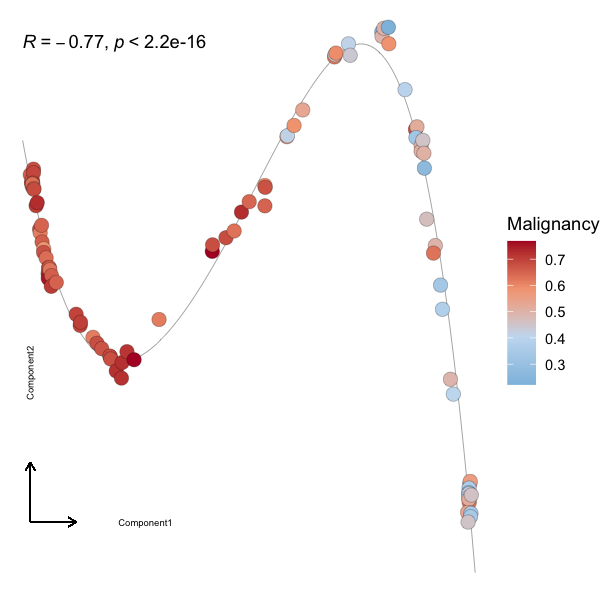

In [295]:
a=tmp_pc_df %>%
  ggplot(aes(x=PC1, y=PC2))+
  geom_line(data=splinefit,  linewidth=0.1) +
  geom_point(aes(fill=TDS_score),size=4, shape=21, , stroke=0.1) +
  scale_color_npg()+
  scale_fill_gradientn(colours = c( "#8FBFE0", "#C7DDF1", "#F4A582", "#B2182B"),name='Malignancy')+
  stat_cor(aes(x=Pseudotime, y=TDS_score))+
  theme_void()+
  geom_segment(aes(x=min(PC1), y=min(PC2), xend=min(PC1)+1.2, yend=min(PC2)),
               colour="black", size=0.2,arrow = arrow(length=unit(0.2,"cm")))+ 
  geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1), yend=min(PC2)+1.2/fold_res),
               colour = "black", size=0.2,arrow = arrow(length = unit(0.2,"cm"))) +
  annotate("text", x = min(tmp_pc_df$PC1)+3, y = min(tmp_pc_df$PC2), label = "Component1",
           color="black",size = 2) + 
  annotate("text", x = min(tmp_pc_df$PC1), y = min(tmp_pc_df$PC2)+3/fold_res, label = "Component2",
           color="black",size = 2, angle=90) 
options(repr.plot.width=5, repr.plot.height=5)
a
ggsave(glue('{output_dir}/malignant_trajectory(TDScoloring_legend).pdf'),
       plot = get_legend(a), width = 5, height = 5)
ggsave(glue('{output_dir}/malignant_trajectory(TDScoloring).pdf'), a+NoLegend(),
       width=70, height=60, units='mm', dpi = 450, bg = 'transparent')


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


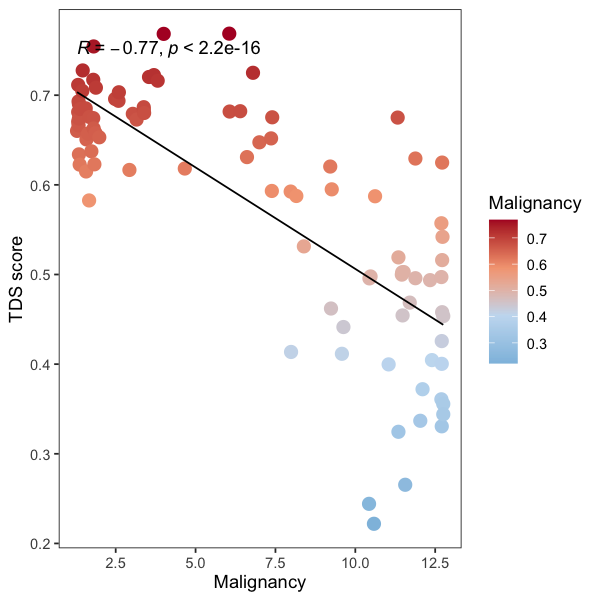

In [296]:

a = tmp_pc_df %>%
  ggplot(aes(x=Pseudotime, y=TDS_score))+
  geom_point(aes(fill=TDS_score),size=4, shape=21, , stroke=NA) +
  scale_fill_gradientn(colours = c( "#8FBFE0", "#C7DDF1", "#F4A582", "#B2182B"),name='Malignancy')+
  stat_cor(aes(x=Pseudotime, y=TDS_score))+
  geom_smooth(se=F,  linewidth=0.5, color='black',method='lm')+
  labs(x='Malignancy', y='TDS score')+
  theme_bw()+
  theme(panel.grid = element_blank())
options(repr.plot.width=5, repr.plot.height=5)
a
ggsave(glue('{output_dir}/malignant_trajectory(TDScoloringscatter_plot_legend).pdf'),
       plot = get_legend(a), width = 5, height = 5)
ggsave(glue('{output_dir}/malignant_trajectory(TDScoloringscatter_plot).pdf'), a+NoLegend(),
       width=70, height=60, units='mm', dpi = 450, bg = 'transparent')


### TG,TSHR,SLC5A5

In [ ]:
# Add expression values of specific genes to trajectory dataframe
tmp_pc_df[,c('TG', 'TSHR', 'SLC5A5')] = t(corrected[c('TG', 'TSHR', 'SLC5A5'), tmp_pc_df$sample]) %>% log1p()

Warning message in log1p(.):
“NaNs produced”


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_cor()`).”


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_cor()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


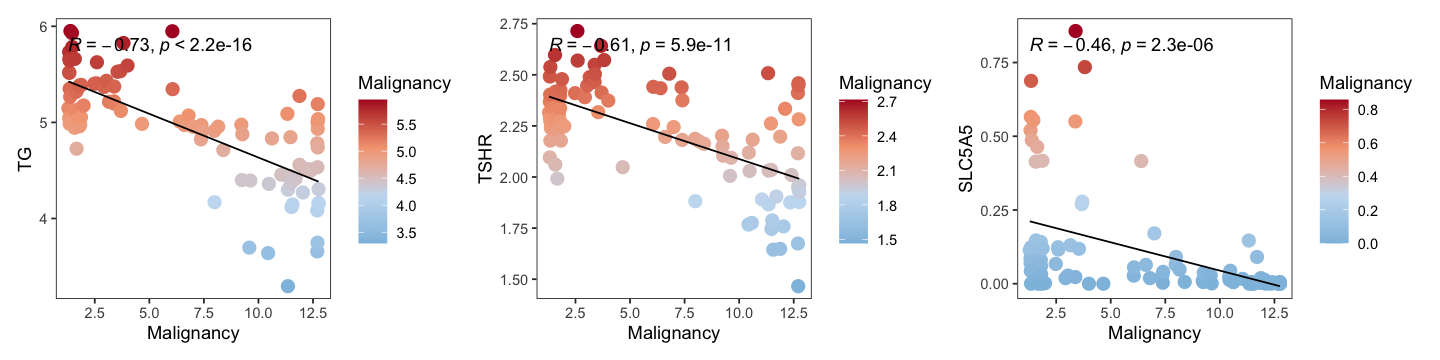

In [300]:

a=tmp_pc_df %>%
  ggplot(aes(x=Pseudotime, y=TG))+
  geom_point(aes(fill=TG),size=4, shape=21, , stroke=NA) +
  scale_fill_gradientn(colours = c( "#8FBFE0", "#C7DDF1", "#F4A582", "#B2182B"),name='Malignancy')+
  stat_cor(aes(x=Pseudotime, y=TG))+
  geom_smooth(se=F,  linewidth=0.5, color='black',method='lm')+
  labs(x='Malignancy', y='TG')+
  theme_bw()+
  theme(panel.grid = element_blank())
b=tmp_pc_df %>%
  ggplot(aes(x=Pseudotime, y=TSHR))+
  geom_point(aes(fill=TSHR),size=4, shape=21, , stroke=NA) +
  scale_fill_gradientn(colours = c( "#8FBFE0", "#C7DDF1", "#F4A582", "#B2182B"),name='Malignancy')+
  stat_cor(aes(x=Pseudotime, y=TSHR))+
  geom_smooth(se=F,  linewidth=0.5, color='black',method='lm')+
  labs(x='Malignancy', y='TSHR')+
  theme_bw()+
  theme(panel.grid = element_blank())
c=tmp_pc_df %>%
  ggplot(aes(x=Pseudotime, y=SLC5A5))+
  geom_point(aes(fill=SLC5A5),size=4, shape=21, , stroke=NA) +
  scale_fill_gradientn(colours = c( "#8FBFE0", "#C7DDF1", "#F4A582", "#B2182B"),name='Malignancy')+
  stat_cor(aes(x=Pseudotime, y=SLC5A5))+
  geom_smooth(se=F,  linewidth=0.5, color='black',method='lm')+
  labs(x='Malignancy', y='SLC5A5')+
  theme_bw()+
  theme(panel.grid = element_blank())
options(repr.plot.width=12, repr.plot.height=3)
a|b|c
ggsave(glue('{output_dir}/malignant_trajectory_TDSmarkerexpression_change.pdf'), plot = a|b|c, width = 12, height = 3)


### BRAF

Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1) + :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1), :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1) + :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1), :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), 

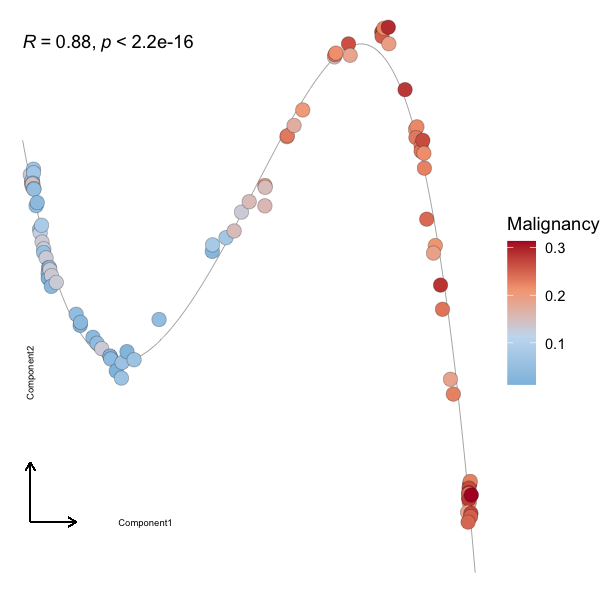

In [ ]:
# BRAF
a=tmp_pc_df %>%
  ggplot(aes(x=PC1, y=PC2))+
  geom_line(data=splinefit,  linewidth=0.1) +
  geom_point(aes(fill=BRAF_score),size=4, shape=21, , stroke=0.1) +
  stat_cor(aes(x=Pseudotime, y=BRAF_score))+
  scale_color_npg()+
  scale_fill_gradientn(colours = c( "#8FBFE0", "#C7DDF1", "#F4A582", "#B2182B"),name='Malignancy')+
  theme_void()+
  geom_segment(aes(x=min(PC1), y=min(PC2), xend=min(PC1)+1.2, yend=min(PC2)),
               colour="black", size=0.2,arrow = arrow(length=unit(0.2,"cm")))+ 
  geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1), yend=min(PC2)+1.2/fold_res),
               colour = "black", size=0.2,arrow = arrow(length = unit(0.2,"cm"))) +
  annotate("text", x = min(tmp_pc_df$PC1)+3, y = min(tmp_pc_df$PC2), label = "Component1",
           color="black",size = 2) + 
  annotate("text", x = min(tmp_pc_df$PC1), y = min(tmp_pc_df$PC2)+3/fold_res, label = "Component2",
           color="black",size = 2, angle=90) 
options(repr.plot.width=5, repr.plot.height=5)
a
ggsave(glue('{output_dir}/malignant_trajectory(BRAFcoloring_legend).pdf'),
       plot = get_legend(a), width = 5, height = 5)
ggsave(glue('{output_dir}/malignant_trajectory(BRAFcoloring).pdf'), a+NoLegend(),
       width=70, height=60, units='mm', dpi = 450, bg = 'transparent')


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


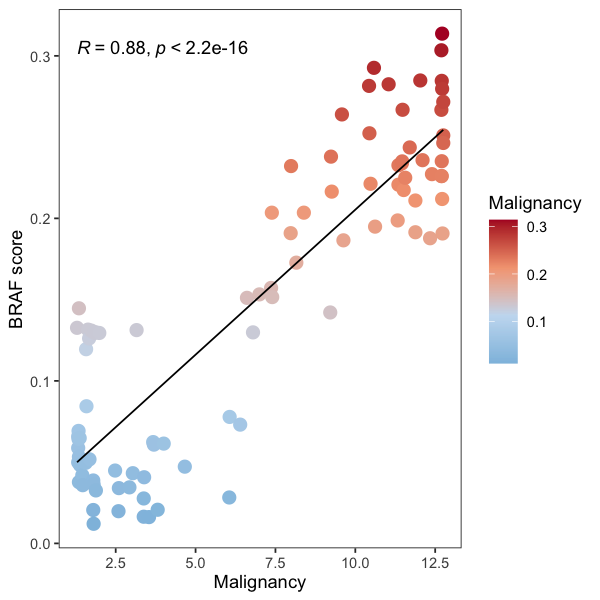

In [303]:

a = tmp_pc_df %>%
  ggplot(aes(x=Pseudotime, y=BRAF_score))+
  geom_point(aes(fill=BRAF_score),size=4, shape=21, , stroke=NA) +
  scale_fill_gradientn(colours = c( "#8FBFE0", "#C7DDF1", "#F4A582", "#B2182B"),name='Malignancy')+
  stat_cor(aes(x=Pseudotime, y=BRAF_score))+
  geom_smooth(se=F,  linewidth=0.5, color='black',method='lm')+
  labs(x='Malignancy', y='BRAF score')+
  theme_bw()+
  theme(panel.grid = element_blank())
a 
ggsave(glue('{output_dir}/malignant_trajectory(BRAFcoloringscatter_plot_legend).pdf'),
       plot = get_legend(a), width = 5, height = 5)
ggsave(glue('{output_dir}/malignant_trajectory(BRAFcoloringscatter_plot).pdf'), a+NoLegend(),
       width=70, height=60, units='mm', dpi = 450, bg = 'transparent')


### RAS

Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1) + :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1), :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1) + :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1), :
“All aesthetics have length 1, but the data has 95 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = min(PC1), 

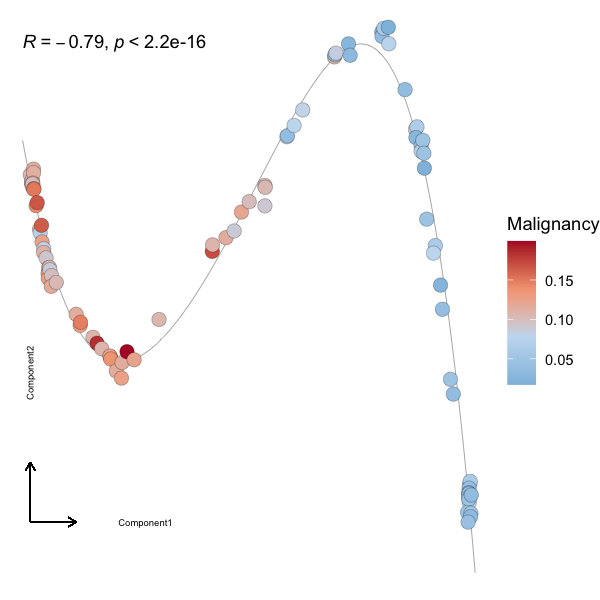

In [304]:
# RAS
a=tmp_pc_df %>%
  ggplot(aes(x=PC1, y=PC2))+
  geom_line(data=splinefit,  linewidth=0.1) +
  geom_point(aes(fill=RAS_score),size=4, shape=21, , stroke=0.1) +
  stat_cor(aes(x=Pseudotime, y=RAS_score))+
  scale_color_npg()+
  scale_fill_gradientn(colours = c( "#8FBFE0", "#C7DDF1", "#F4A582", "#B2182B"),name='Malignancy')+
  theme_void()+
  geom_segment(aes(x=min(PC1), y=min(PC2), xend=min(PC1)+1.2, yend=min(PC2)),
               colour="black", size=0.2,arrow = arrow(length=unit(0.2,"cm")))+ 
  geom_segment(aes(x = min(PC1), y = min(PC2), xend = min(PC1), yend=min(PC2)+1.2/fold_res),
               colour = "black", size=0.2,arrow = arrow(length = unit(0.2,"cm"))) +
  annotate("text", x = min(tmp_pc_df$PC1)+3, y = min(tmp_pc_df$PC2), label = "Component1",
           color="black",size = 2) + 
  annotate("text", x = min(tmp_pc_df$PC1), y = min(tmp_pc_df$PC2)+3/fold_res, label = "Component2",
           color="black",size = 2, angle=90) 
options(repr.plot.width=5, repr.plot.height=5)
a
ggsave(glue('{output_dir}/malignant_trajectory(RAScoloring_legend).pdf'),
       plot = get_legend(a), width = 5, height = 5)
ggsave(glue('{output_dir}/malignant_trajectory(RAScoloring).pdf'), a+NoLegend(),
       width=70, height=60, units='mm', dpi = 450, bg = 'transparent')


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


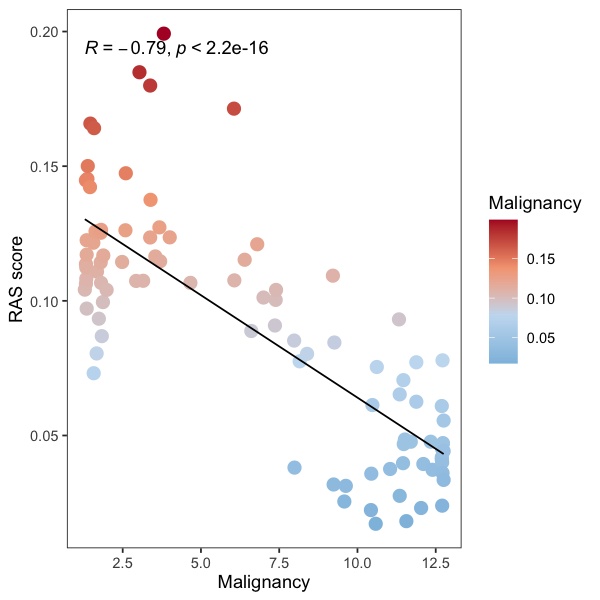

In [305]:

a = tmp_pc_df %>%
  ggplot(aes(x=Pseudotime, y=RAS_score))+
  geom_point(aes(fill=RAS_score),size=4, shape=21, , stroke=NA) +
  scale_fill_gradientn(colours = c( "#8FBFE0", "#C7DDF1", "#F4A582", "#B2182B"),name='Malignancy')+
  stat_cor(aes(x=Pseudotime, y=RAS_score))+
  geom_smooth(se=F,  linewidth=0.5, color='black',method='lm')+
  labs(x='Malignancy', y='RAS score')+
  theme_bw()+
  theme(panel.grid = element_blank())
a 
ggsave(glue('{output_dir}/malignant_trajectory(RAScoloringscatter_plot_legend).pdf'),
       plot = get_legend(a), width = 5, height = 5)
ggsave(glue('{output_dir}/malignant_trajectory(RAScoloringscatter_plot).pdf'), a+NoLegend(),
       width=70, height=60, units='mm', dpi = 450, bg = 'transparent')


In [336]:
saveRDS(tmp_pc_df, '../organized_data/trajectory_projection_97sample_withScore.rds')

## Changes in differential gene numbers along trajectory

# Malignant trajectory molecular features

In [7]:
pc_df = readRDS('../organized_data/trajectory_projection_97sample.rds')
splinefit = readRDS("'../organized_data/trajectory_projection_97samplesplinefit.rds'")
all_FC_test = readRDS('../output/97sample_FoldChange.rds')
hm_res = readRDS('../organized_data/malignant_trajectoryclusterenriched_HM_function97.rds')
kmeans_df = read.table('../output/FC_profile_keman_97.txt', sep='\t')


## Differential gene change patterns

In [8]:

sample_order = pc_df[, c('Pseudotime', 'sample', 'Pseudotime_cut')]
sample_order = sample_order[order(sample_order$Pseudotime), , drop=F]
sample_text_color = srt@meta.data[, c('orig.ident', 'Tissue_desc')] %>% distinct()
rownames(sample_text_color) = sample_text_color$orig.ident
sample_text_color = sample_text_color[sample_order$sample, ]
sample_text_color = sapply(sample_text_color$Tissue_desc, function(x)tissue_colors[x])

In [9]:

# select just the logfc and p values
all_FC_test_avg_logFC <- all_FC_test[,grepl("avg_log2FC", colnames(all_FC_test))]
all_FC_test_p_val_adj <- all_FC_test[,grepl("p_val_adj", colnames(all_FC_test))]
all_FC_test_avg_logFC[is.na(all_FC_test_avg_logFC)] <- 0
all_FC_test_p_val_adj[is.na(all_FC_test_p_val_adj)] <- 1
# select significant genes with the following cutoffs
all_FC_test_avg_logFC_significant <- all_FC_test_avg_logFC[(rowSums(all_FC_test_avg_logFC>0.5 & all_FC_test_p_val_adj<0.05)>1 | 
                                                              rowSums(all_FC_test_avg_logFC<(-0.5) & all_FC_test_p_val_adj<0.05)>1), ]

all_FC_test_p_val_adj_significant <- all_FC_test_p_val_adj[(rowSums(all_FC_test_avg_logFC>0.5 & all_FC_test_p_val_adj<0.05)>1 | 
                                                              rowSums(all_FC_test_avg_logFC<(-0.5) & all_FC_test_p_val_adj<0.05)>1), ]


# FC heatmap
colnames(all_FC_test_avg_logFC_significant) = gsub('avg_log2FC','', colnames(all_FC_test_avg_logFC_significant))
set.seed(1994)


In [10]:

tmp_map = c('Cluster_4'='#0000FF', 'Cluster_1'='#0099FF', 'Cluster_2'='#FF0000', 'Cluster_3'='#FF9900')
text = lapply(names(hm_res), function(x) {
  data.frame(x=hm_res[[x]], col = tmp_map[x], fontsize = 8)
})
names(text) = names(hm_res)

x = kmeans_df$kmeans_class_str
align_to = split(seq_along(x), x)
#text[['Cluster_1']][c(4), 'col'] = 'red'
#text[['Cluster_2']][c(1), 'col'] = 'blue'
# Annotate representative oncogenes and tumor suppressors in each module
pathway_gene = read.table('../../pathwaygene.txt', header = T)
keep_pathway_gene = intersect(pathway_gene$name, rownames(kmeans_df))

mark_gene = keep_pathway_gene
mark_pos = match(mark_gene, rownames(kmeans_df))


right_anno = rowAnnotation(
  a=anno_mark(at = mark_pos, labels = mark_gene, 
              which = "row", side='right',
              link_width = unit(8, "mm"),
              padding = unit(0.5, "mm"),
              link_height = unit(5, "mm"),
              labels_gp = gpar(fontsize=8)),
  textbox = anno_textbox(list('1'=align_to[['Cluster_1']],
                              '2'=align_to[['Cluster_2']],
                              '3'=align_to[['Cluster_3']],
                              '4'=align_to[['Cluster_4']]), 
                         list('1'=text[['Cluster_1']],
                              '2'=text[['Cluster_2']],
                              '3'=text[['Cluster_3']],
                              '4'=text[['Cluster_4']]),
                         background_gp = gpar(fill = "NA", col = "#AAAAAA"),
                         word_wrap = TRUE, 
                         add_new_line = TRUE))


Warning message in data.frame(x = hm_res[[x]], col = tmp_map[x], fontsize = 8):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = hm_res[[x]], col = tmp_map[x], fontsize = 8):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = hm_res[[x]], col = tmp_map[x], fontsize = 8):
“row names were found from a short variable and have been discarded”


In [11]:
df_marker_sample = c()
colnames(all_FC_test_p_val_adj_significant) = gsub('p_val_adj','', colnames(all_FC_test_p_val_adj_significant))
for(i in sample_order$sample){
  tmp_up = all_FC_test_avg_logFC_significant[, i] > 0.5 & all_FC_test_p_val_adj_significant[,i]<0.001
  tmp_down = all_FC_test_avg_logFC_significant[, i] < (-0.5) & all_FC_test_p_val_adj_significant[,i]<0.001
  df_marker_sample = rbind(df_marker_sample, c(i, sum(tmp_up)+sum(tmp_down)))
}

In [12]:
df_marker_sample = as.data.frame(df_marker_sample)
rownames(df_marker_sample) = df_marker_sample$V1

In [15]:
pc_df$DEG_num = as.numeric(df_marker_sample[tmp_pc_df$sample,2])

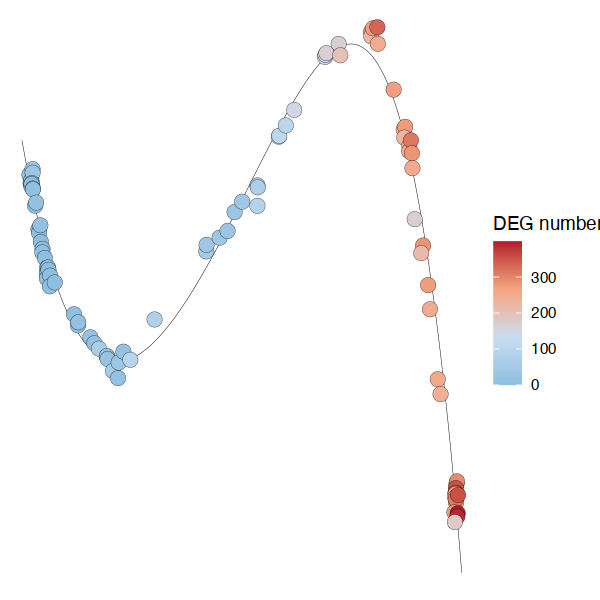

In [16]:
# 
a=pc_df %>%
  ggplot(aes(x=PC1, y=PC2))+
  geom_line(data=splinefit,  linewidth=0.1) +
  geom_point(aes(fill=DEG_num),size=4, shape=21, , stroke=0.1) +
  scale_color_npg()+
  scale_fill_gradientn(colours = c( "#8FBFE0", "#C7DDF1", "#F4A582", "#B2182B"),name='DEG number')+
  theme_void()
options(repr.plot.width=5, repr.plot.height=5)
a
ggsave(glue('{output_dir}/malignant_trajectory(DEGcoloring_legend).pdf'),
       plot = get_legend(a), width = 5, height = 5)
ggsave(glue('{output_dir}/malignant_trajectory(DEGcoloring).pdf'), a+NoLegend(),
       width=70, height=60, units='mm', dpi = 450, bg = 'transparent')


In [17]:
df_marker_sample = c()
colnames(all_FC_test_p_val_adj_significant) = gsub('p_val_adj','', colnames(all_FC_test_p_val_adj_significant))
for(i in sample_order$sample){
  tmp_up = all_FC_test_avg_logFC_significant[, i] > 0.5 & all_FC_test_p_val_adj_significant[,i]<0.001
  tmp_down = all_FC_test_avg_logFC_significant[, i] < (-0.5) & all_FC_test_p_val_adj_significant[,i]<0.001
  df_marker_sample = rbind(df_marker_sample, c(i, sum(tmp_up), sum(tmp_down)))
}
df_marker_sample = as.data.frame(df_marker_sample)
colnames(df_marker_sample) = c('sample', 'Up', 'Down')
df_marker_sample = reshape2::melt(df_marker_sample, id='sample')
df_marker_sample$value= as.numeric(df_marker_sample$value)
df_marker_sample$sample = factor(df_marker_sample$sample, levels = sample_order$sample)
df_marker_sample$variable = factor(df_marker_sample$variable, levels = c('Up', 'Down'))
df_marker_sample = reshape2::dcast(df_marker_sample, sample~variable)
rownames(df_marker_sample) = df_marker_sample$sample
ha = HeatmapAnnotation(DEG = anno_barplot(as.matrix(df_marker_sample[sample_order$sample,c('Up', 'Down')]), 
                                          gp = gpar(fill =  c("#D7191C","#2C7BB6"), col = c("#D7191C","#2C7BB6")),
                                          border=FALSE)
)
##
#draw(ha)


pdf 
  2

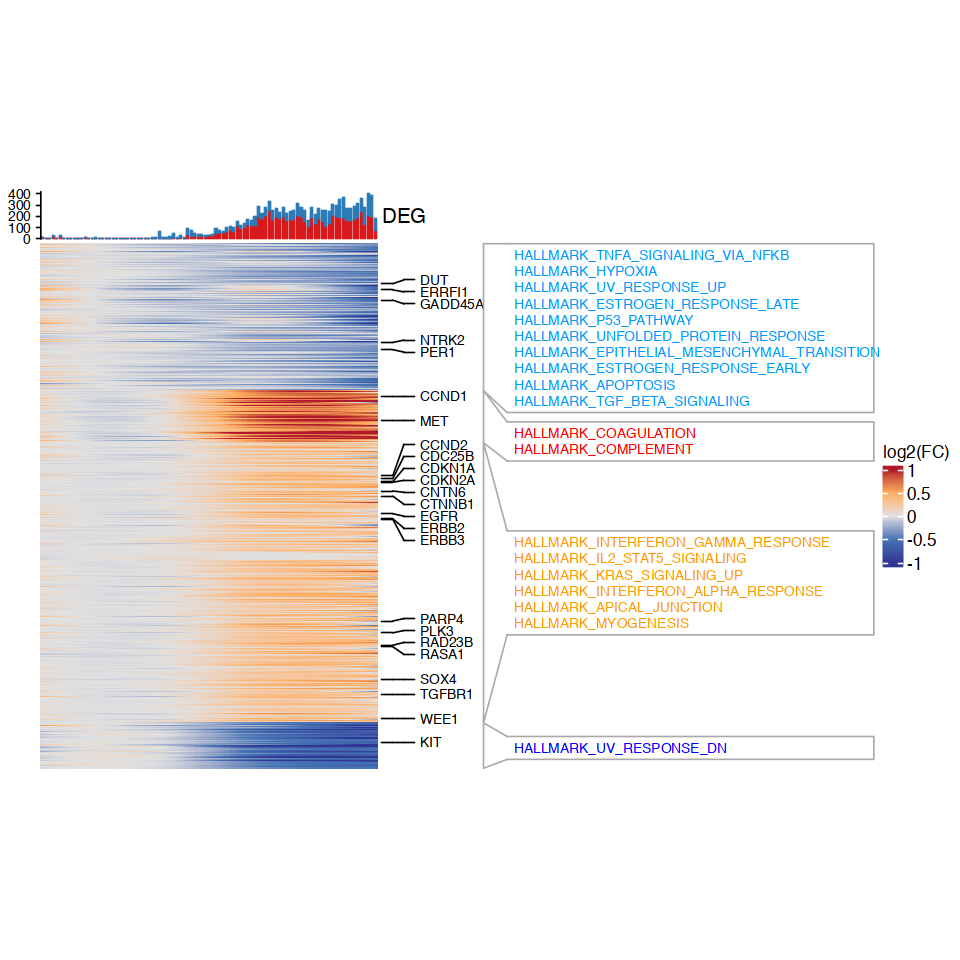

In [18]:
ht_data = all_FC_test_avg_logFC_significant[rownames(kmeans_df), sample_order$sample]
ht_data_smooth = t(apply(ht_data, 1, function(a){
  tmp_lm = loess(y~x, data = data.frame(x=1:95,y=a))
  predict(tmp_lm,x=1:95)
})) 
#colnames(all_FC_test_avg_logFC_significant2) = colnames(all_FC_test_avg_logFC_significant)
ht = Heatmap(ht_data_smooth,
             cluster_rows = F, cluster_columns = F,
             show_row_names = F, show_column_names = T,
             #row_split = kmeans_df$kmeans_class,
             #column_split = sample_order$Pseudotime_cut,
             col = circlize::colorRamp2(c(-1,-0.5,0, 0.5, 1), c("#313695", "#4575B4", "#E0E0E0", "#FDAE61", "#B2182B")),
             right_annotation = right_anno,
             top_annotation = ha,
             column_names_gp = gpar(col = sample_text_color, fontsize=6),
             heatmap_height = unit(0.12, "mm")*nrow(all_FC_test_avg_logFC_significant),
             heatmap_legend_param = list(title='log2(FC)')
)
options(repr.plot.width=8, repr.plot.height=8)
ht
pdf(glue('{output_dir}/malignant_trajectory_molecular_features.pdf'), width=8, height=8)
draw(ht)
dev.off()

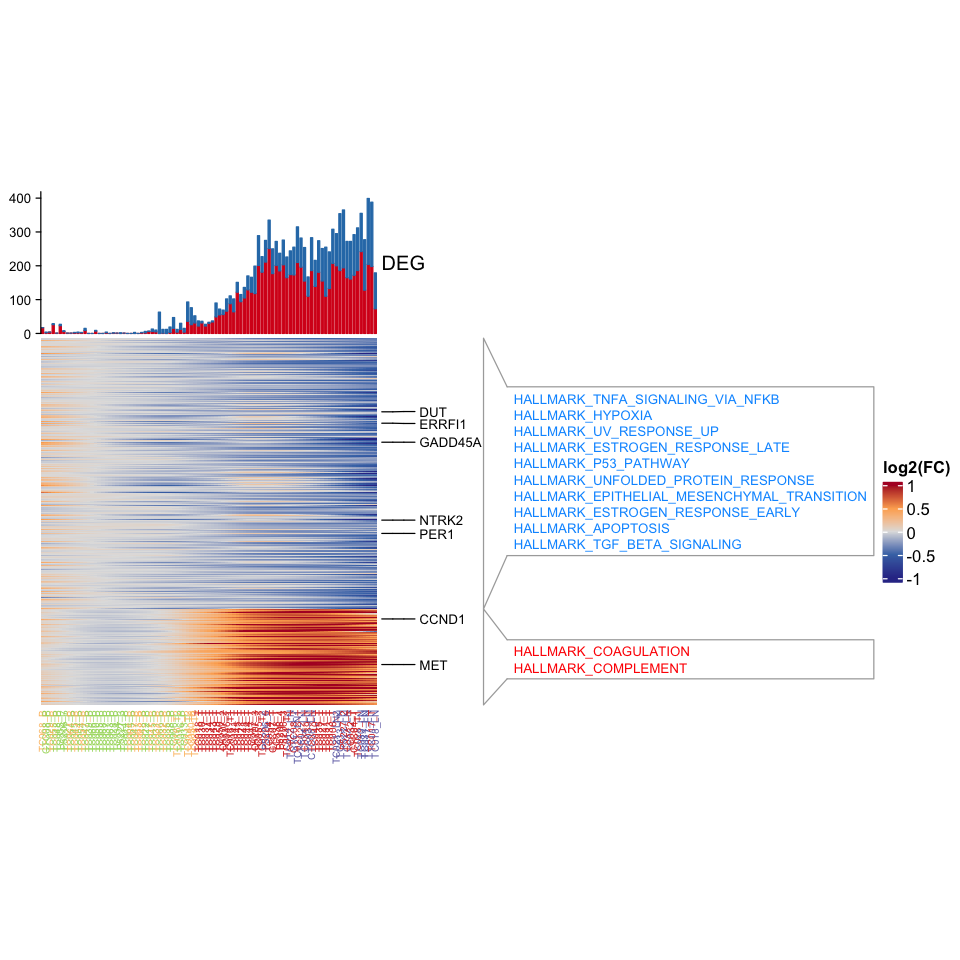

In [329]:

right_anno2 = rowAnnotation(
  a=anno_mark(at = mark_pos, labels = mark_gene, 
              which = "row", side='right',
              link_width = unit(8, "mm"),
              padding = unit(0.5, "mm"),
              link_height = unit(5, "mm"),
              labels_gp = gpar(fontsize=8)),
  textbox = anno_textbox(list('1'=align_to[['Cluster_1']],
                              '2'=align_to[['Cluster_2']]), 
                         list('1'=text[['Cluster_1']],
                              '2'=text[['Cluster_2']]),
                         background_gp = gpar(fill = "NA", col = "#AAAAAA"),
                         word_wrap = TRUE, 
                         add_new_line = TRUE))

ha2 = HeatmapAnnotation(DEG = anno_barplot(as.matrix(df_marker_sample[sample_order$sample,c('Up', 'Down')]), 
                                          gp = gpar(fill =  c("#D7191C","#2C7BB6"), col = c("#D7191C","#2C7BB6")),
                                          border=FALSE,
                                          height = unit(3, "cm"))
)
ht_data_smooth2 = ht_data_smooth
colnames(ht_data_smooth2) = sample_order$sample
ht = Heatmap(ht_data_smooth2[kmeans_df$kmeans_class%in%c(1,2),],
             cluster_rows = F, cluster_columns = F,
             show_row_names = F, show_column_names = T,
             #row_split = kmeans_df$kmeans_class,
             #column_split = sample_order$Pseudotime_cut,
             col = circlize::colorRamp2(c(-1,-0.5,0, 0.5, 1), c("#313695", "#4575B4", "#E0E0E0", "#FDAE61", "#B2182B")),
             right_annotation = right_anno2,
             top_annotation = ha2,
             column_names_gp = gpar(col = sample_text_color, fontsize=6),
             heatmap_height = unit(0.12, "mm")*nrow(all_FC_test_avg_logFC_significant),
             heatmap_legend_param = list(title='log2(FC)')
)
ht



'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



pdf 
  2

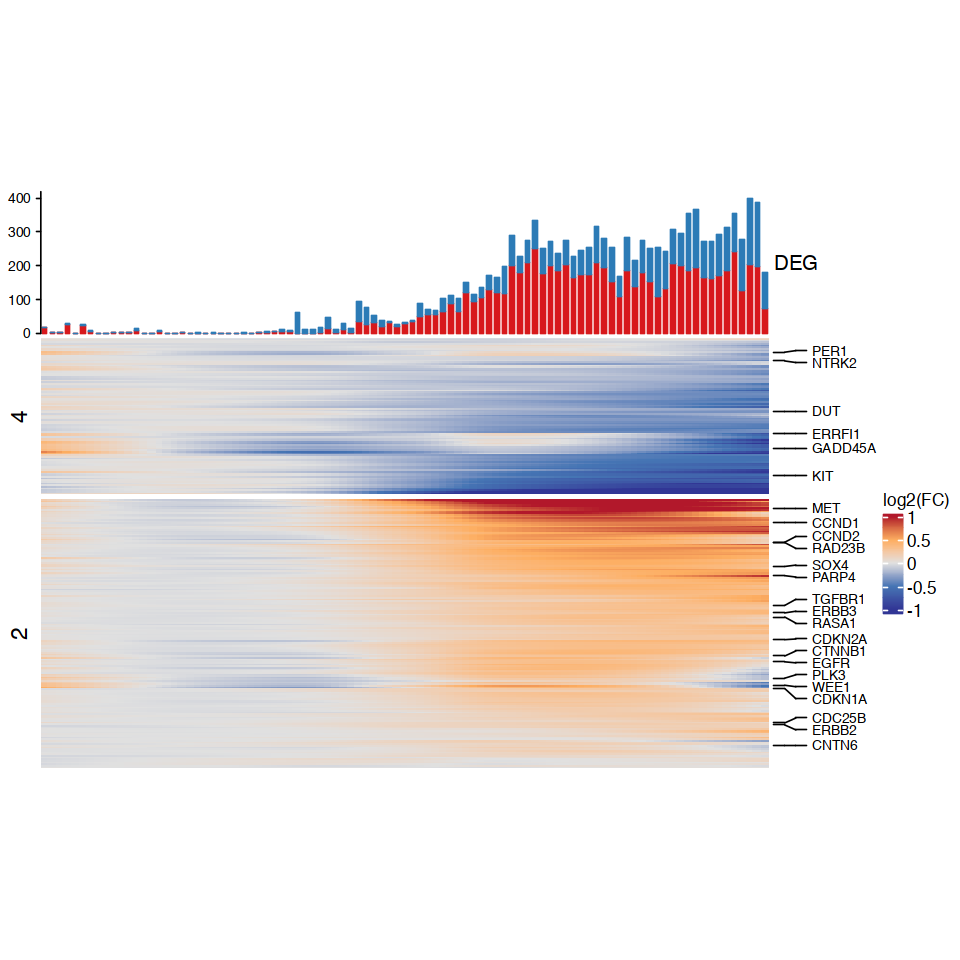

In [20]:


right_anno3 = rowAnnotation(
  a=anno_mark(at = mark_pos, labels = mark_gene, 
              which = "row", side='right',
              link_width = unit(8, "mm"),
              padding = unit(0.5, "mm"),
              link_height = unit(5, "mm"),
              labels_gp = gpar(fontsize=8)))

ha3 = HeatmapAnnotation(DEG = anno_barplot(as.matrix(df_marker_sample[sample_order$sample,c('Up', 'Down')]), 
                                           gp = gpar(fill =  c("#D7191C","#2C7BB6"), col = c("#D7191C","#2C7BB6")),
                                           border=FALSE,
                                           height = unit(3, "cm"))
)
ht_data_smooth3 = ht_data_smooth
colnames(ht_data_smooth3) = sample_order$sample

row_order_new = kmeans_df$kmeans_class
row_order_new[row_order_new==1] = 4
row_order_new[row_order_new==3] = 2


ht = Heatmap(ht_data_smooth3,
             cluster_rows = T, cluster_columns = F,
             show_row_names = F, show_column_names = F,
             show_row_dend = F,
             row_split = row_order_new,
             #column_split = sample_order$Pseudotime_cut,
             col = circlize::colorRamp2(c(-1,-0.5,0, 0.5, 1), c("#313695", "#4575B4", "#E0E0E0", "#FDAE61", "#B2182B")),
             right_annotation = right_anno3,
             top_annotation = ha3,
             column_names_gp = gpar(col = sample_text_color, fontsize=6),
             heatmap_height = unit(0.12, "mm")*nrow(all_FC_test_avg_logFC_significant),
             heatmap_legend_param = list(title='log2(FC)'),
             use_raster=T
)
ht
pdf(glue('{output_dir}/malignant_trajectory_molecular_features(no_function_display).pdf'), width=4, height=6)
draw(ht)
dev.off()


In [22]:
table(row_order_new)

row_order_new
  2   4 
644 373 

In [23]:
length(row_order_new)

[1] 1017

## Differential gene functional scores

### HALLMARK

In [82]:

#### Calculate scores method 1 ####
hallmark_data = GSEABase::getGmt('../h.all.v7.4.symbols.gmt')
hallmark_data = hallmark_data@.Data
hallmark_list = list()
for(i in hallmark_data){
  hallmark_list[[i@setName]] = i@geneIds
}
hallmark_list_all_num = sapply(hallmark_list, length)
names(hallmark_list_all_num) = gsub('HALLMARK_','',names(hallmark_list_all_num))

# cluster 1，3
tmp_gene = rownames(kmeans_df[kmeans_df$kmeans_class%in%c(2,3),,drop=F])
hallmark_list_filter = list()
for(i in names(hallmark_list)){
  x=intersect(hallmark_list[[i]], tmp_gene)
  if(length(x)>5){
    hallmark_list_filter[[i]] = x
  }
}
srt2 = AddModuleScore(srt, features = hallmark_list_filter, name = names(hallmark_list_filter))
hallmark_list_filter_up = hallmark_list_filter
names(hallmark_list_filter_up) =  gsub('HALLMARK_','',names(hallmark_list_filter_up))

tmp_gene = rownames(kmeans_df[kmeans_df$kmeans_class%in%c(1,4),,drop=F])
hallmark_list_filter = list()
for(i in names(hallmark_list)){
  x=intersect(hallmark_list[[i]], tmp_gene)
  if(length(x)>5){
    hallmark_list_filter[[i]] = x
  }
}
srt3 = AddModuleScore(srt, features = hallmark_list_filter, name = names(hallmark_list_filter))
hallmark_list_filter_down = hallmark_list_filter
names(hallmark_list_filter_down) =  gsub('HALLMARK_','',names(hallmark_list_filter_down))



Warning message:
“The following features are not present in the object: NINJ1, TNC, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: P4HA2, CHST2, SDC3, PAM, TGFBI, NEDD4L, MAP3K1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: ARHGEF2, RASA1, MYH10, TIAM1, SEPTIN9, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: TGFBR1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: CDC25B, RAD23B, DMD, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: BAX, BID, TSPO, CDC25B, ANKH, BCL2L1, ERBB3, ERBB2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: SLC1A5, SNCG, MGLL, RAB34, not searching for symbol synonyms”
Warning message:
“The following features are

In [83]:

up_score = srt2@meta.data[,c('orig.ident',grep('HALLMARK_', colnames(srt2@meta.data), value = T))]
up_score = up_score %>% group_by(orig.ident) %>% summarise_all(list(mean)) %>% as.data.frame()
rownames(up_score) = up_score$orig.ident
up_score = up_score[,-1]
colnames(up_score) = gsub('\\d*$','',colnames(up_score))
colnames(up_score) = gsub('HALLMARK_','',colnames(up_score))

down_score = srt3@meta.data[,c('orig.ident',grep('HALLMARK_', colnames(srt3@meta.data), value = T))]
down_score = down_score %>% group_by(orig.ident) %>% summarise_all(list(mean)) %>% as.data.frame()
rownames(down_score) = down_score$orig.ident
down_score = down_score[,-1]
colnames(down_score) = gsub('\\d*$','',colnames(down_score))
colnames(down_score) = gsub('HALLMARK_','',colnames(down_score))


In [ ]:
# batch_corrected = readRDS('../organized_data/97sample_batch_corrected_sample_expression.rds')
# batch_corrected_mat = batch_corrected$corrected
# cells_rankings = batch_corrected$cells_rankings

# #### Calculate scores method 2 ####
# hallmark_data = GSEABase::getGmt('/volumes/extend02/wangxin/Rprojects/cancer/h.all.v7.4.symbols.gmt')
# hallmark_data = hallmark_data@.Data
# hallmark_list = list()
# for(i in hallmark_data){
#   hallmark_list[[i@setName]] = i@geneIds
# }
# hallmark_list_all_num = sapply(hallmark_list, length)
# names(hallmark_list_all_num) = gsub('HALLMARK_','',names(hallmark_list_all_num))

# # cluster 1，3
# tmp_gene = rownames(kmeans_df[kmeans_df$kmeans_class%in%c(2,3),,drop=F])
# hallmark_list_filter = list()
# for(i in names(hallmark_list)){
#   x=intersect(hallmark_list[[i]], tmp_gene)
#   if(length(x)>5){
#     hallmark_list_filter[[i]] = x
#   }
# }
# tmp_cells_AUCell2 <- AUCell_calcAUC(hallmark_list_filter, cells_rankings, nCores = 10)
# tmp_auc_matrix2 <- as.data.frame(getAUC(tmp_cells_AUCell2))

# hallmark_list_filter_up = hallmark_list_filter
# names(hallmark_list_filter_up) =  gsub('HALLMARK_','',names(hallmark_list_filter_up))

# tmp_gene = rownames(kmeans_df[kmeans_df$kmeans_class%in%c(1,4),,drop=F])
# hallmark_list_filter = list()
# for(i in names(hallmark_list)){
#   x=intersect(hallmark_list[[i]], tmp_gene)
#   if(length(x)>5){
#     hallmark_list_filter[[i]] = x
#   }
# }
# tmp_cells_AUCell3 <- AUCell_calcAUC(hallmark_list_filter, cells_rankings, nCores = 10)
# tmp_auc_matrix3 <- as.data.frame(getAUC(tmp_cells_AUCell3))

# hallmark_list_filter_down = hallmark_list_filter
# names(hallmark_list_filter_down) =  gsub('HALLMARK_','',names(hallmark_list_filter_down))

# up_score = t(tmp_auc_matrix2)
# colnames(up_score) = gsub('\\d*$','',colnames(up_score))
# colnames(up_score) = gsub('HALLMARK_','',colnames(up_score))

# down_score = t(tmp_auc_matrix3)
# colnames(down_score) = gsub('\\d*$','',colnames(down_score))
# colnames(down_score) = gsub('HALLMARK_','',colnames(down_score))

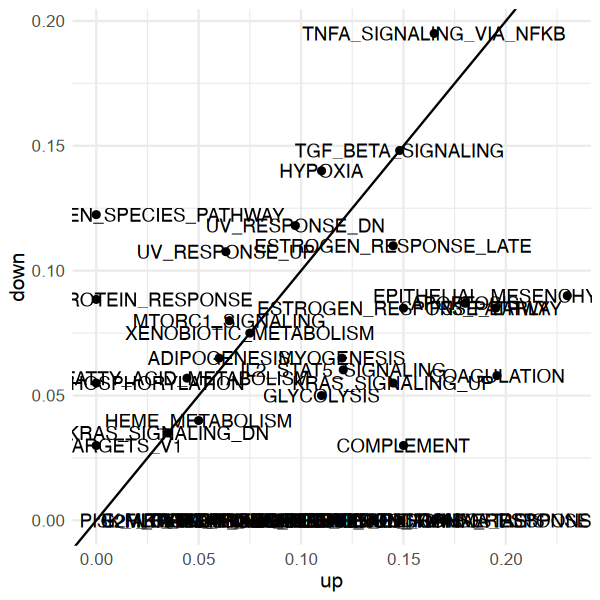

In [84]:

# filter gene>10
hallmark_prop_up = sapply(hallmark_list_filter_up, length) / hallmark_list_all_num[names(hallmark_list_filter_up)]
hallmark_prop_down = sapply(hallmark_list_filter_down, length)/ hallmark_list_all_num[names(hallmark_list_filter_down)]

hallmark_prop = data.frame('up'=hallmark_prop_up[names(hallmark_list_all_num)],
                          'down'=hallmark_prop_down[names(hallmark_list_all_num)])
hallmark_prop$hallmark = names(hallmark_list_all_num)
hallmark_prop[is.na(hallmark_prop)] = 0
hallmark_prop = hallmark_prop[rowSums(hallmark_prop[,1:2])>0,]
ggplot(hallmark_prop, aes(x=up, y=down))+
  geom_point()+
  geom_text(aes(label=hallmark))+
  geom_abline(slope = 1,intercept = 0)


In [379]:

up_keep_marker = hallmark_prop[hallmark_prop$up>hallmark_prop$down, 'hallmark']
down_keep_marker = hallmark_prop[hallmark_prop$up<=hallmark_prop$down, 'hallmark']


diff_up = intersect(up_keep_marker,colnames(up_score))
diff_down = intersect(down_keep_marker,colnames(down_score))


diff_up=intersect(up_keep_marker, colnames(up_score)[colMeans(up_score)>(-0)])

diff_down=intersect(down_keep_marker, colnames(down_score)[colMeans(down_score)>(-0)])


write.table(data.frame('hallmark'=c(diff_up,diff_down), 
    'group'=c(rep('up', length(diff_up)), rep('down',length(diff_down)))),
            '../organized_data/trajectory_enrichment_hallmark97.txt'
            )


agg_record_2068994480 
                    2

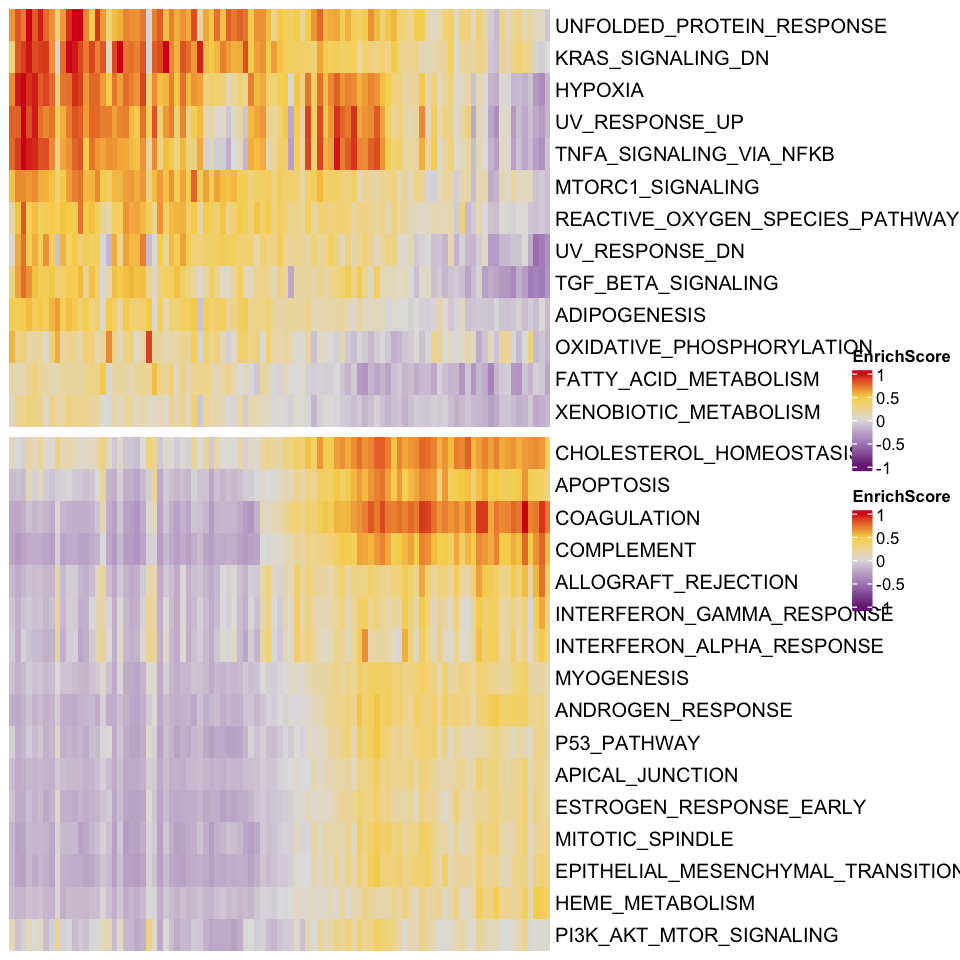

In [380]:
h1=Heatmap(t(up_score[sample_order$sample,diff_up]),
        cluster_columns = F,
        show_row_dend = F, show_column_names = F,
        col = circlize::colorRamp2(c(-1,-0.5,0, 0.5, 1), c("#762A83", "#AF8DC3", "#E0E0E0", "#F7D458", "#D7191C")),
        heatmap_legend_param = list('title'='EnrichScore')
        )
h2=Heatmap(t(down_score[sample_order$sample,diff_down]),
           cluster_columns = F,
           show_row_dend = F, show_column_names = F,
           col = circlize::colorRamp2(c(-1,-0.5,0, 0.5, 1), c("#762A83", "#AF8DC3", "#E0E0E0", "#F7D458", "#D7191C")),
           heatmap_legend_param = list('title'='EnrichScore')
)

h2%v%h1
pdf(glue('{output_dir}/malignant_trajectory_molecular_features(function).pdf'), width=5, height=4)
h2%v%h1
dev.off()


In [381]:

### Enrichment
DefaultAssay(srt) = 'RNA'
sample_order$HYPOXIA = down_score[sample_order$sample,'HYPOXIA']
sample_order$TGF_beta = down_score[sample_order$sample,'TGF_BETA_SIGNALING']

sample_order$IFN_alpha = up_score[sample_order$sample,'INTERFERON_ALPHA_RESPONSE']
sample_order$EMT = up_score[sample_order$sample,'EPITHELIAL_MESENCHYMAL_TRANSITION']


In [1]:
sample_order$OXPHOS = down_score[sample_order$sample,'OXIDATIVE_PHOSPHORYLATION']

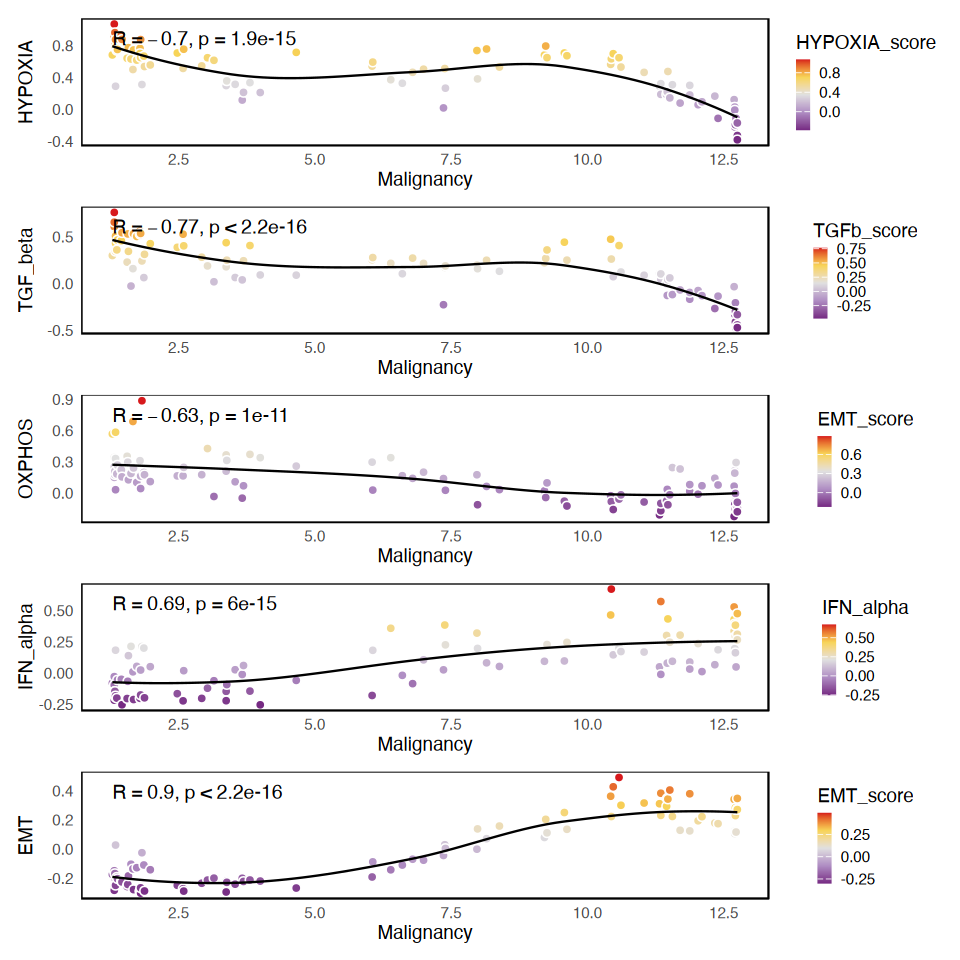

In [593]:
a=sample_order %>%
  ggplot(aes(x=Pseudotime, y=HYPOXIA))+
  geom_point(aes(fill=HYPOXIA),size=2, shape=21, color='white') +
  geom_smooth(method = "loess", se=F,  formula = y~x, size=0.5,  color='black')+
  scale_fill_gradientn(colours = c("#762A83", "#AF8DC3", "#E0E0E0", "#F7D458", "#D7191C"),name='HYPOXIA_score')+
  stat_cor( method='pearson', size=4)+
  theme_minimal()+
  labs(x='Malignancy')+
  theme(panel.border = element_rect(color='black', fill=NA),
        strip.background = element_blank(),
        panel.grid = element_blank(),
        legend.key.width = unit(3,'mm'),
        legend.key.height = unit(3,'mm')) 
b=sample_order %>%
  ggplot(aes(x=Pseudotime, y=TGF_beta))+
  geom_point(aes(fill=TGF_beta),size=2, shape=21, color='white') +
  geom_smooth(method = "loess", se=F,  formula = y~x, size=0.5,  color='black')+
  scale_fill_gradientn(colours = c("#762A83", "#AF8DC3", "#E0E0E0", "#F7D458", "#D7191C"),name='TGFb_score')+
  stat_cor( method='pearson', size=4)+
  theme_minimal()+
  labs(x='Malignancy')+
  theme(panel.border = element_rect(color='black', fill=NA),
        strip.background = element_blank(),
        panel.grid = element_blank(),
        legend.key.width = unit(3,'mm'),
        legend.key.height = unit(3,'mm')) 
c=sample_order %>%
  ggplot(aes(x=Pseudotime, y=IFN_alpha))+
  geom_point(aes(fill=IFN_alpha),size=2, shape=21, color='white') +
  geom_smooth(method = "loess", se=F,  formula = y~x, size=0.5,  color='black')+
  scale_fill_gradientn(colours = c("#762A83", "#AF8DC3", "#E0E0E0", "#F7D458", "#D7191C"),name='IFN_alpha')+
  stat_cor( method='pearson', size=4)+
  theme_minimal()+
  labs(x='Malignancy')+
  theme(panel.border = element_rect(color='black', fill=NA),
        strip.background = element_blank(),
        panel.grid = element_blank(),
        legend.key.width = unit(3,'mm'),
        legend.key.height = unit(3,'mm')) 
d=sample_order %>%
  ggplot(aes(x=Pseudotime, y=EMT))+
  geom_point(aes(fill=EMT),size=2, shape=21, color='white') +
  geom_smooth(method = "loess", se=F,  formula = y~x, size=0.5,  color='black')+
  scale_fill_gradientn(colours = c("#762A83", "#AF8DC3", "#E0E0E0", "#F7D458", "#D7191C"),name='EMT_score')+
  stat_cor( method='pearson', size=4)+
  theme_minimal()+
  labs(x='Malignancy')+
  theme(panel.border = element_rect(color='black', fill=NA),
        strip.background = element_blank(),
        panel.grid = element_blank(),
        legend.key.width = unit(3,'mm'),
        legend.key.height = unit(3,'mm')) 
e = sample_order %>%
  ggplot(aes(x=Pseudotime, y=OXPHOS))+
  geom_point(aes(fill=OXPHOS),size=2, shape=21, color='white') +
  geom_smooth(method = "loess", se=F,  formula = y~x, size=0.5,  color='black')+
  scale_fill_gradientn(colours = c("#762A83", "#AF8DC3", "#E0E0E0", "#F7D458", "#D7191C"),name='EMT_score')+
  stat_cor( method='pearson', size=4)+
  theme_minimal()+
  labs(x='Malignancy')+
  theme(panel.border = element_rect(color='black', fill=NA),
        strip.background = element_blank(),
        panel.grid = element_blank(),
        legend.key.width = unit(3,'mm'),
        legend.key.height = unit(3,'mm')) 
a/b/e/c/d
ggsave(glue('{output_dir}/malignant_trajectory(differential_gene_enrichment_functioncoloring).pdf'),a/b/e/c/d,
       width=110, height=210, units='mm', dpi = 450, bg = 'transparent')


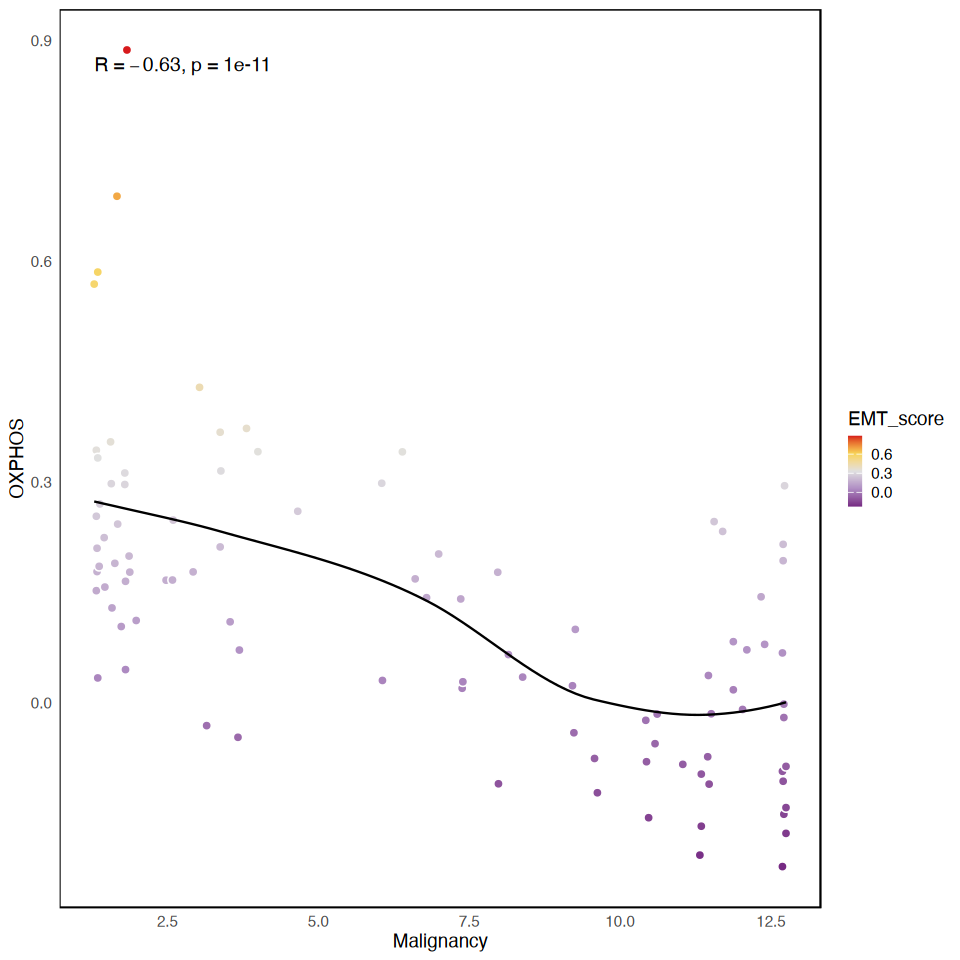

In [591]:
e

### Metabolism enrichment

In [ ]:
#### Metabolism enrichment ####
library(GSEABase)
mb_pathway = readRDS('../../hsa_KEGG_pathway_name(1).rds')

In [ ]:
batch_corrected = readRDS('../organized_data/97sample_batch_corrected_sample_expression.rds')
batch_corrected_mat = batch_corrected$corrected
cells_rankings = batch_corrected$cells_rankings

In [391]:
pc_df = readRDS('../organized_data/trajectory_projection_97sample.rds')
pc_df = pc_df %>% arrange(Pseudotime)

In [403]:
DefaultAssay(srt) = 'RNA'
srt4 = AddModuleScore(srt, features = mb_pathway, name = names(mb_pathway))

Warning message:
“The following features are not present in the object: PGK2, ALDH2, G6PC1, PCK2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: IDH2, PCK2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: TKTL2, PRPS1L1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: UGT2A1, UGT2B28, UGT1A10, UGT1A8, UGT1A5, UGT1A9, UGT1A4, UGT1A3, UGT2A2, UGT2B4, UGT2B10, UGT2B15, UGT2A3, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: GFUS, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: G6PC1, LALBA, SI, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: UGT2A1, UGT2B28, UGT1A10, UGT1A8, UGT1A5, UGT1A9, UGT1A4, UGT1A3, UGT2A2, UGT2B4, UGT2B10, UGT2B15, 

In [408]:
mb_score_name = setdiff(colnames(srt4@meta.data), colnames(srt@meta.data))

In [472]:

mb_AUC <- AUCell_calcAUC(mb_pathway, cells_rankings)
sc_mb_score_mat <- as.data.frame(getAUC(mb_AUC))
sc_mb_score_mat = sc_mb_score_mat[, pc_df$sample]

Warning message in .AUCell_calcAUC(geneSets = geneSets, rankings = rankings, nCores = nCores, :
“The following gene sets will be excluded from the analysis(less than 20% of their genes are available):
Aminoacyl-tRNA biosynthesis, Ribosome”
Genes in the gene sets NOT available in the dataset: 
	Glycolysis / Gluconeogenesis: 	4 (6% of 67)
	Citrate cycle (TCA cycle): 	2 (7% of 30)
	Pentose phosphate pathway: 	2 (6% of 31)
	Pentose and glucuronate interconversions: 	13 (36% of 36)
	Fructose and mannose metabolism: 	1 (3% of 34)
	Galactose metabolism: 	3 (9% of 32)
	Ascorbate and aldarate metabolism: 	14 (47% of 30)
	Fatty acid biosynthesis: 	2 (11% of 18)
	Fatty acid elongation: 	1 (4% of 27)
	Fatty acid degradation: 	1 (2% of 43)
	Primary bile acid biosynthesis: 	1 (6% of 17)
	Steroid hormone biosynthesis: 	20 (32% of 63)
	Oxidative phosphorylation: 	20 (14% of 138)
	Arginine biosynthesis: 	2 (9% of 23)
	Purine metabolism: 	8 (6% of 128)
	Pyrimidine metabolism: 	4 (7% of 58)
	Alanine, asp

In [481]:
srt4@meta.data[,c('orig.ident', mb_score_name)] %>%
  group_by(orig.ident) %>%
  summarise_all(list(mean)) %>%
  as.data.frame() -> sc_mb_score_mat
rownames(sc_mb_score_mat) = sc_mb_score_mat$orig.ident
sc_mb_score_mat = sc_mb_score_mat[,-1]
sc_mb_score_mat = sc_mb_score_mat[pc_df$sample,]
sc_mb_score_mat = as.data.frame(t(sc_mb_score_mat))

rownames(sc_mb_score_mat) = gsub('\\d*$','', rownames(sc_mb_score_mat))

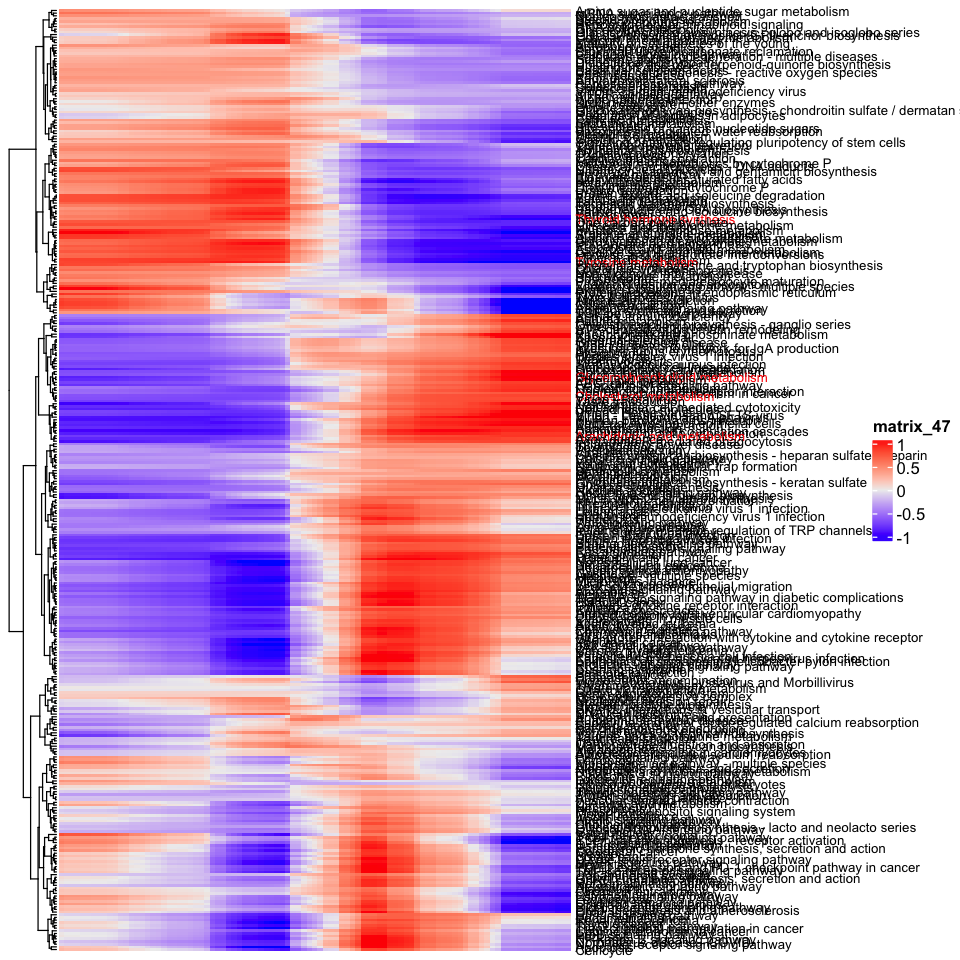

In [484]:
sc_mb_score_mat2 = t(apply(sc_mb_score_mat,1,scale))
sc_mb_ht_smooth = apply(sc_mb_score_mat2, 1, function(x){
  if(sum(is.na(x))>0){
    return(rep(0,length(x)))
  }else{
    tmp_lm = loess(y~x, data=data.frame(x=pc_df$Pseudotime,y=x))
    # tmp_lm <- lm(y ~ poly(x, degree=2), data=data.frame(x=1:85,y=x))
    # tmp_lm = loess(y~x, data=data.frame(x=1:95,y=x))
    predict(tmp_lm)
  }
})
sc_mb_ht_smooth = t(sc_mb_ht_smooth)

sample_text_color = rep('black', nrow(sc_mb_ht_smooth))
sample_text_color[rownames(sc_mb_ht_smooth) %in%c('Cholesterol metabolism',
                                                  'Glycerophospholipid metabolism',
                                                  'Arachidonic acid metabolism',
                                                  'Tyrosine metabolism',
                                                  'Thyroid hormone synthesis')] = 'red'
names(sample_text_color) = rownames(sc_mb_ht_smooth)


Heatmap(sc_mb_ht_smooth, 
        cluster_columns = F,
        row_names_gp = gpar(col=sample_text_color, fontsize=8),
)

In [506]:
apply(sc_mb_score_mat, 1, function(x){
    ct = cor.test(x, pc_df$Pseudotime, method='pearson')
    return(c(ct$estimate, ct$p.value))
}) %>% t() -> mb_cor
mb_cor = as.data.frame(mb_cor)
colnames(mb_cor) = c('cor', 'pvalue')
mb_cor %>% filter(pvalue<0.001,abs(cor)>0.5) -> mb_cor_filter
# sc_mb_score_mat = sc_mb_score_mat[rownames(mb_cor_filter),]

In [507]:
mb_cor = mb_cor[rownames(sc_mb_score_mat),]

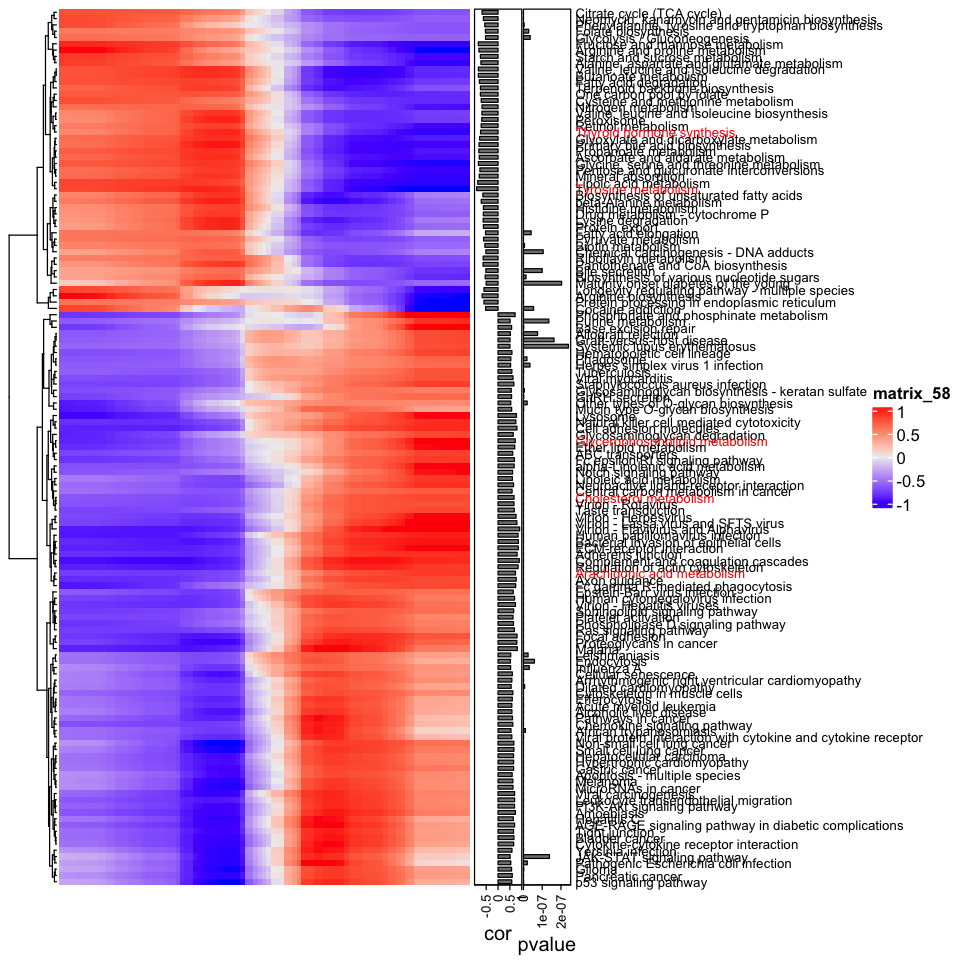

In [508]:
Heatmap(sc_mb_ht_smooth[rownames(mb_cor_filter),], 
        cluster_columns = F,
        right_annotation = rowAnnotation(
          cor = anno_barplot(mb_cor[rownames(mb_cor_filter),]$cor),
          pvalue = anno_barplot(mb_cor[rownames(mb_cor_filter),]$pvalue)
        ),
        row_names_gp = gpar(col=sample_text_color[rownames(mb_cor_filter)], fontsize=8),
)

In [493]:
setdiff(c('Cholesterol metabolism',
        'Glycerophospholipid metabolism',
        'Arachidonic acid metabolism',
        'Tyrosine metabolism',
        'Thyroid hormone synthesis'), rownames(mb_cor_filter))

character(0)

In [522]:
sc_mb_score_mat_filter = sc_mb_score_mat[rownames(mb_cor_filter),]

In [533]:
cut_3_stage = as.vector(cut(pc_df$Pseudotime, breaks = 10))

dif_mb = c()
for(i in unique(cut_3_stage)){
  i_data = sc_mb_score_mat_filter[, cut_3_stage==i]
  o_data = sc_mb_score_mat_filter[, cut_3_stage!=i]
  tmp_res = sapply(1:nrow(i_data), function(x){
    tt = t.test(i_data[x,], o_data[x,])
    dif= mean(unlist(i_data[x,]), na.rm=T) - mean(unlist(o_data[x,]), na.rm=T)
    return(c(tt$p.value,dif))
  })
  tmp_res = as.data.frame(t(tmp_res))
  colnames(tmp_res) = c('pvalue', 'diff')
  tmp_res$mb = rownames(sc_mb_score_mat_filter)
  tmp_res$group = i
  dif_mb = rbind(dif_mb, tmp_res)
}
dif_mb = dif_mb %>% filter(pvalue<0.05, diff>0.05)# %>% group_by(group) %>% 
dif_mb2 = dif_mb %>% group_by(group) %>% top_n(50, diff)  %>% as.data.frame()
filter_mb = unique(dif_mb2$mb)

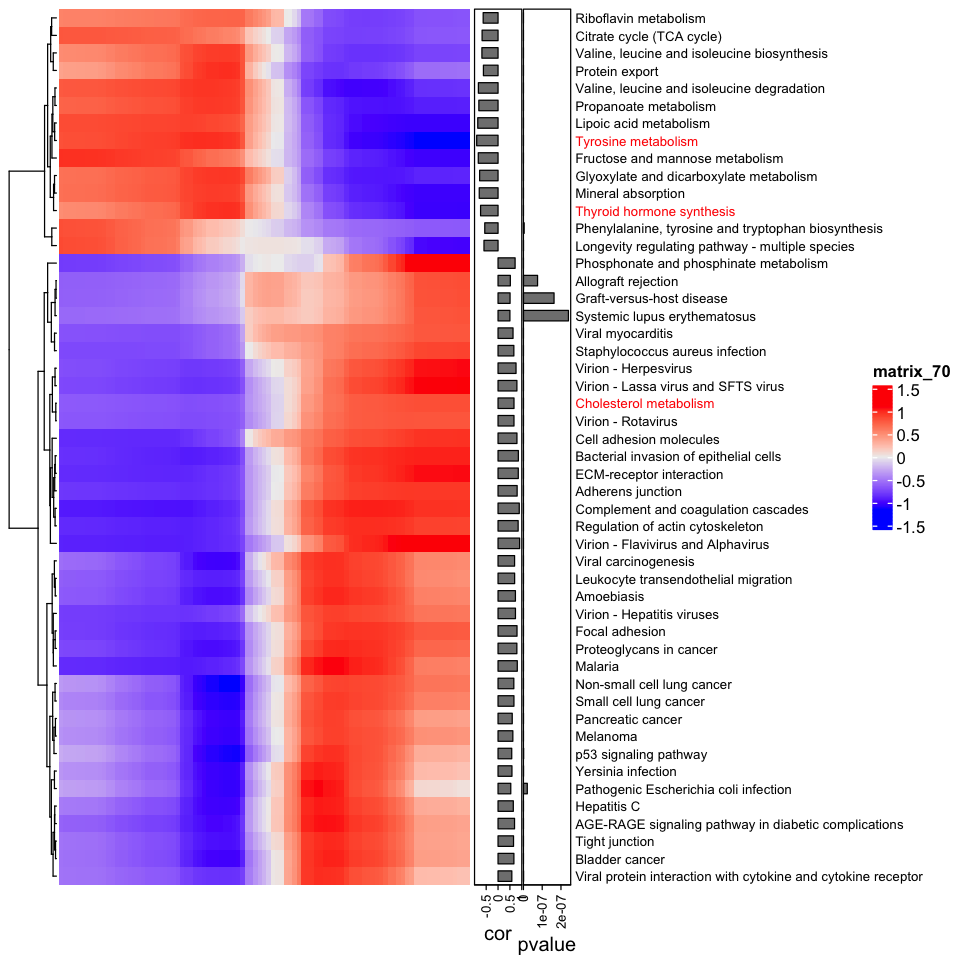

In [534]:
Heatmap(sc_mb_ht_smooth[filter_mb,], 
        cluster_columns = F,
        right_annotation = rowAnnotation(
          cor = anno_barplot(mb_cor[filter_mb,]$cor),
          pvalue = anno_barplot(mb_cor[filter_mb,]$pvalue)
        ),
        row_names_gp = gpar(col=sample_text_color[filter_mb], fontsize=8),
)

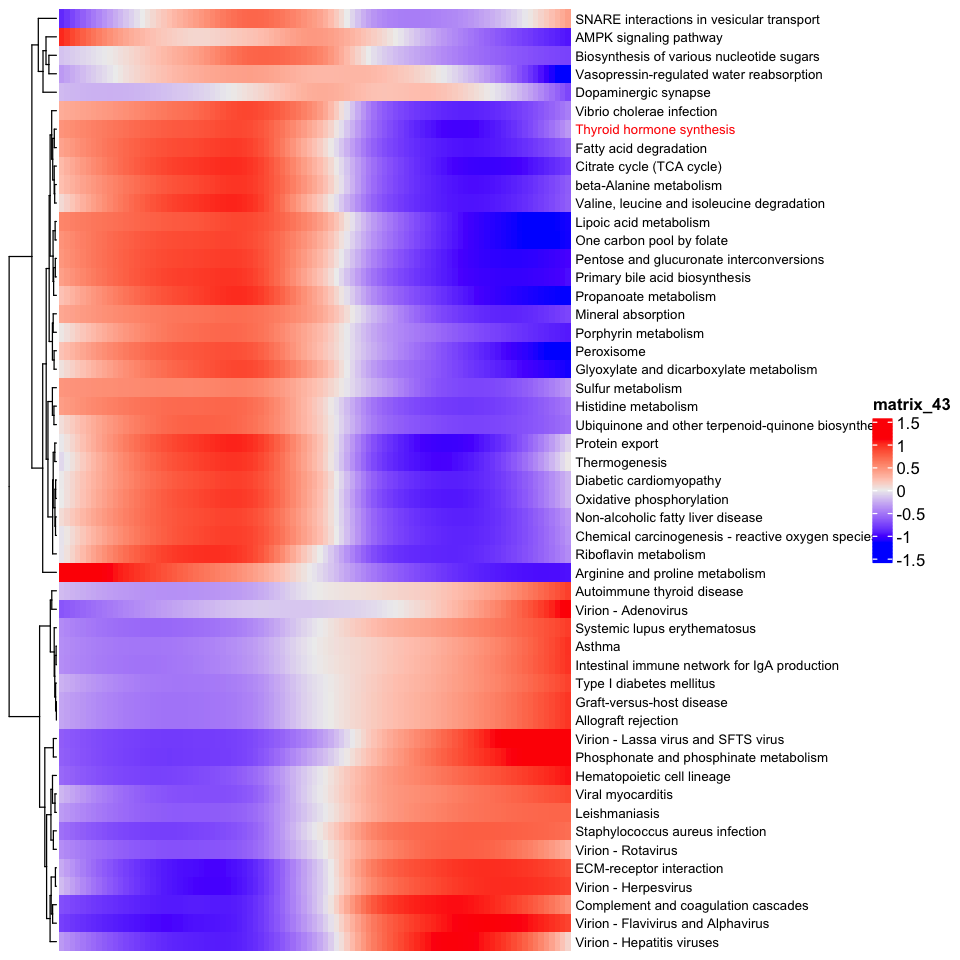

In [479]:
sample_text_color = rep('black', nrow(sc_mb_score_mat))
sample_text_color[rownames(sc_mb_score_mat) %in%c('Cholesterol metabolism',
                                                  'Glycerophospholipid metabolism',
                                                  'Arachidonic acid metabolism',
                                                  'Tyrosine metabolism',
                                                  'Thyroid hormone synthesis')] = 'red'
names(sample_text_color) = rownames(sc_mb_score_mat)

sc_mb_score_mat2 = t(apply(sc_mb_score_mat,1,scale))
sc_mb_ht_smooth = apply(sc_mb_score_mat2, 1, function(x){
  if(sum(is.na(x))>0){
    return(rep(0,length(x)))
  }else{
    #tmp_lm = loess(y~x, data=data.frame(x=pc_df$Pseudotime,y=x))
    # tmp_lm <- lm(y ~ poly(x, degree=2), data=data.frame(x=1:85,y=x))
    tmp_lm = loess(y~x, data=data.frame(x=1:95,y=x))
    predict(tmp_lm)
  }
})
sc_mb_ht_smooth = t(sc_mb_ht_smooth)
# sc_mb_ht_smooth = sc_mb_ht_smooth[filter_mb,]
Heatmap(sc_mb_ht_smooth[filter_mb,], 
        cluster_columns = F,
        row_names_gp = gpar(col = sample_text_color[filter_mb],fontsize=8),
)


In [480]:
Heatmap(sc_mb_score_mat2, 
        cluster_columns = F,
        #row_names_gp = gpar(col = sample_text_color[filter_mb],fontsize=8),
)

The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.



ERROR while rich displaying an object: Error in hclust(get_dist(submat, distance), method = method): NA/NaN/Inf in foreign function call (arg 10)

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare

In [ ]:

library(seriation)
register_DendSer()
o <- seriate(sc_mb_ht_smooth, method = "Heatmap", seriation_method = "DendSer_BAR")

#hmap(sc_mb_ht_smooth, method = "DendSer_BAR", main = "Wood (banded anti-Robinson)")
xx = sc_mb_ht_smooth[get_order(o, 1),]
xx = xx[rev(rownames(xx)),]

clusters_sc = cutree(o[[1]],3)[rownames(xx)]

ht = ComplexHeatmap::Heatmap(
  xx,
  cluster_columns = F,
  cluster_rows = F,
  row_split = clusters_sc,
  show_column_names = F,
  #column_split = sample_order$Pseudotime_cut,
  col = circlize::colorRamp2(c(-1.5,-0.75, 0, 0.75, 1.5),c('#2C7BB6','#ABD9E9','#FEF0D9','#FDAE61','#D7191C')),
  #column_names_gp = gpar(col = sample_text_color),
  #name="Regulon activity",
  #right_annotation = rowAnnotation(df=apply(sc_mb_score_mat,1,mean)),
  row_names_gp = gpar(fontsize=10),
  #bottom_annotation = ha
  #heatmap_height = unit(2.5, "mm")*nrow(new_tf_smooth[names(sort(if_order2, decreasing = F)),])
)
ht

### TF

In [ ]:

#### TF ####
library(SCopeLoomR)
library(dplyr)
library(SCENIC)
library(AUCell)
library(ComplexHeatmap)
setwd('../Thyroid_code/scenic/')
scenicOptions = readRDS('int/scenicOptions.Rds')
scenicLoomPath <- getOutName(scenicOptions, "loomFile")
regulonAUC <- loadInt(scenicOptions, "aucell_regulonAUC")
regulonAUC <- regulonAUC[onlyNonDuplicatedExtended(rownames(regulonAUC)),]
setwd('../Thyroid_code')
top_meta = srt@meta.data[, c('orig.ident','Tissue_desc', 'sub_cluster', 'Tumor_metastasis')]
top_meta = top_meta[colnames(regulonAUC),]

regulonActivity_byCellType <- sapply(split(rownames(top_meta), as.vector(top_meta$orig.ident)),
                                     function(cells) rowMeans(getAUC(regulonAUC)[,cells,drop=F]))

regulonActivity_byCellType_Scaled <- t(scale(t(regulonActivity_byCellType), center = T, scale=T))
sample_order = pc_df[, c('Pseudotime', 'sample', 'Pseudotime_cut','Tissue_desc')]
sample_order = sample_order[order(sample_order$Pseudotime), , drop=F]

new_order = match(sample_order$sample, colnames(regulonActivity_byCellType_Scaled))

new_tf = regulonActivity_byCellType_Scaled[, new_order]

new_tf_smooth = apply(new_tf, 1, function(x){
  tmp_lm = loess(y~x, data=data.frame(x=1:ncol(new_tf),y=x))
  predict(tmp_lm, data.frame(x=1:ncol(new_tf),y=new_tf[1,]))
})
new_tf_smooth = as.data.frame(t(new_tf_smooth))
colnames(new_tf_smooth) = colnames(new_tf)
ht=ComplexHeatmap::Heatmap(new_tf_smooth, 
                           cluster_columns = F,
                           cluster_rows = T,
                           show_column_names = F,
                           column_split = sample_order$Pseudotime_cut,
                           row_names_gp = gpar(fontsize=6),
                           col = circlize::colorRamp2(c(-1.5,-0.75, 0,0.75, 1.5),c('#2C7BB6','#ABD9E9','#FFFFFF','#FDAE61','#D7191C')),
                           #column_names_gp = gpar(col = sample_text_color),
                           name="Regulon activity")
ht
dif_if = c()
for(i in unique(as.vector(sample_order$Pseudotime_cut))){
  i_data = new_tf_smooth[, as.vector(sample_order$Pseudotime_cut)==i]
  o_data = new_tf_smooth[, as.vector(sample_order$Pseudotime_cut)!=i]
  tmp_res = sapply(1:nrow(i_data), function(x){
    tt = t.test(i_data[x,], o_data[x,])
    dif= mean(unlist(i_data[x,]), na.rm=T) - mean(unlist(o_data[x,]), na.rm=T)
    return(c(tt$p.value,dif))
  })
  tmp_res = as.data.frame(t(tmp_res))
  colnames(tmp_res) = c('pvalue', 'diff')
  tmp_res$IF = rownames(new_tf_smooth)
  tmp_res$group = i
  dif_if = rbind(dif_if, tmp_res)
}
dif_if2 = dif_if %>% filter(pvalue<0.001)# %>% group_by(group) %>% 
dif_if2 = dif_if2 %>% group_by(group) %>% top_n(10, diff)  %>% as.data.frame()
#dif_if3 = reshape2::acast(dif_if2, IF~group) %>% as.data.frame()
#dif_if3 = dif_if3 %>% dplyr::filter(!(a=='a'&is.na(b)&c=='c'))

library(ComplexHeatmap)
xx=new_tf_smooth[unique(dif_if2$IF),]
colnames(xx) = sample_order$sample
if_order = apply(xx,1, function(y){
  top_10 = sort(y, decreasing = T)
  top_sample = na.omit(names(top_10)[1:4])
  
  mean(match(top_sample, colnames(xx)))
})

ha = HeatmapAnnotation(foo = anno_simple(sample_order$sample,
                                         pch = 1, 
                                         
                                         pt_size = unit(1, "mm")))
ha = HeatmapAnnotation('sample' = anno_points(rep(1,85), ylim = c(0, 1),
                                              axis=F,
                                              size = unit(1, "mm"'),
                                              gp = gpar(col = tissue_colors[sample_order$Tissue_desc]),
                                              border=F
)
)
#pp=pheatmap::pheatmap(new_tf_smooth[unique(dif_if2$IF),],cluster_cols = F)
row_split = c(rep('cluster1',13),rep('cluster2',7),rep('cluster3',10))
tmp_if = read.table('../organized_data/significantly_changed_IFin_malignant_trajectory.txt', sep = '\t')
if_names=c('"FOS (35g)","JUND (168g)","FOSB (153g)","CEBPB (25g)",         
           "MAFB_extended (17g)","SRF (29g)","EGR1 (35g)", "PAX8 (58g)","ZMIZ1 (12g)","ID1 (26g)",
           "ETV7_extended (20g)","ZBTB7A_extended (10g)","IRF9 (67g)", "ELF3_extended (30g)","SOX4 (25g)","NR1D1 (13g)",
           
           
           "MAFF_extended (50g)","HIF1A (23g)", "DDIT3 (26g)","CREB5_extended (13g)",
           
           "IRF1_extended (32g)", "XBP1 (118g)", "IRF7 (18g)","STAT1 (123g)",
           
           "BHLHE40_extended (141g)",
           
           "SMARCC2 (21g)","NR2F1_extended (25g)","RXRG_extended (13g)","SREBF1 (35g)","ETV5 (27g)" )

if_names=c("FOS (35g)","JUND (168g)","FOSB (153g)",
           
           "MAFF_extended (50g)","MAFB_extended (17g)","CEBPB (25g)","XBP1 (118g)","CREB5_extended (13g)","DDIT3 (26g)",
           
           "IRF1_extended (32g)",  "IRF7 (18g)", "IRF9 (67g)",
           
           "ETV7_extended (20g)", "ELF3_extended (30g)","ETV5 (27g)",
           
           "NR1D1 (13g)","NR2F1_extended (25g)","RXRG_extended (13g)","HIF1A (23g)", 
           
           "BHLHE40_extended (141g)","SREBF1 (35g)"
           )

if_col=c(rep('#38528a',3),rep('#df8244',6),rep('#53ad5b',3),rep('#f4c143',3),rep('#53aeea',4),rep('black',2))
names(if_col) = if_names
if_order2 = if_order[if_names]
if_order2 = sort(if_order2)
ht_if=ComplexHeatmap::Heatmap(#xx[pp$tree_row$order,], 
  xx[names(sort(if_order2, decreasing = F)),],
  cluster_columns = F,
  cluster_rows = F,
  #row_split = row_split,
  show_column_names = F,
  #column_split = sample_order$Pseudotime_cut,
  col = circlize::colorRamp2(c(-1.5,-0.75, 0,0.75, 1.5),c('#2C7BB6','#ABD9E9','#FFFFFF','#FDAE61','#D7191C')),
  #column_names_gp = gpar(col = sample_text_color),
  name="Regulon activity",
  
  column_names_gp = gpar(col =tissue_colors[sample_order$Tissue_desc], fontsize=6),
  row_names_gp = gpar(col =if_col[names(sort(if_order2, decreasing = F))], fontsize=6),
  #bottom_annotation = ha
  heatmap_height = unit(2.5, "mm")*nrow(xx[names(sort(if_order2, decreasing = F)),])
)
lgd = Legend(labels =c('AP-1', 'bZIP', 'IRF', 'ETS', 'NR1', 'bHLH'),
             title = "Family"',
             legend_gp = gpar(fill = c('#38528a','#df8244','#53ad5b','#f4c143','#53aeea','black')))
ht_if

pdf(glue('{output_dir}/malignant_trajectory_molecular_features(TF_nonames).pdf'), width=5, height=6)
draw(ht_if, padding = unit(c(20, 10, 10, 10), '"mm"), annotation_legend_list=list(lgd))
dev.off()
#pdf("'../organized_figures/malignant_trajectorygene_FC_heatmap2.pdf'",width = 12,height = 12)
pdf(glue('{output_dir}/malignant_trajectory_molecular_features(TF).pdf'), width=12, height=12)
draw(ht%v%ht_if, padding = unit(c(20, 10, 10, 10), "mm"))
dev.off()


In [ ]:

#### TF family classification ####
jaspar = JASPAR2020::JASPAR2020
pfm = TFBSTools::getMatrixSet(x=jaspar@db, opts=list(all_version=T, species=9606, collection='CORE'))
tf_meta = c()
for(i in pfm@listData){
  tf_meta = rbind(tf_meta, c(i@ID,i@name,i@tags$family,i@tags$symbol))
}
tf_meta = as.data.frame(tf_meta)

if_names2 = sapply(if_names, function(x)strsplit(x,' ')[[1]][1])
if_names2 = gsub('_extended', '',if_names2)
names(if_names2) = if_names

tf_meta = tf_meta[tf_meta$V2%in%if_names2,c('V2', 'V3')]


diff_tf = setdiff(if_names2,tf_meta$V2)
diff_tf_family = c('Fos-related','Paired domain only','Paired domain only',NA,'Ets-related','CEBP-related','CREB-related factors',NA)

tf_meta = rbind(as.matrix(tf_meta), cbind(diff_tf, diff_tf_family))
tf_meta = as.data.frame(tf_meta)
rownames(tf_meta) = names(if_names2)[match(tf_meta$V2, if_names2)]
colnames(tf_meta) = c('TF', 'Family')
#rownames(tf_meta) = tf_meta$TF

tf_family_list <- list(
  AP1 = c("FOS (35g)", "FOSB (153g)", "JUND (168g)"),
  CEBP = c("CEBPB (25g)", "MAFB_extended (17g)", "MAFF_extended (50g)"),
  ETS = c("ETV7_extended (20g)", "ETV5 (27g)", "ELF3_extended (30g)"),
  IRF = c("IRF1_extended (32g)", "IRF7 (18g)", "IRF9 (67g)"),
  STAT = c("STAT1 (123g)"),
  SOX = c("SOX4 (25g)"),
  BHLH = c("BHLHE40_extended (141g)", "ID1 (26g)", "HIF1A (23g)", "DDIT3 (26g)", "CREB5_extended (13g)"),
  Nuclear_Receptor = c("NR1D1 (13g)", "NR2F1_extended (25g)", "RXRG_extended (13g)"),
  Zinc_Finger = c("EGR1 (35g)", "ZBTB7A_extended (10g)", "ZMIZ1 (12g)"),
  PAX = c("PAX8 (58g)"),
  MADS_box = c("SRF (29g)"),
  Chromatin_Remodeling = c("SMARCC2 (21g)"),
  SREBP = c("SREBF1 (35g)")
)
tf_family_vector <- c(
  "FOS (35g)" = "AP1",
  "FOSB (153g)" = "AP1",
  "JUND (168g)" = "AP1",
  
  "CEBPB (25g)" = "CEBP",
  "MAFB_extended (17g)" = "CEBP",
  "MAFF_extended (50g)" = "CEBP",
  
  "ETV7_extended (20g)" = "ETS",
  "ETV5 (27g)" = "ETS",
  "ELF3_extended (30g)" = "ETS",
  
  "IRF1_extended (32g)" = "IRF",
  "IRF7 (18g)" = "IRF",
  "IRF9 (67g)" = "IRF",
  
  "STAT1 (123g)" = "STAT",
  
  "SOX4 (25g)" = "SOX",
  
  "BHLHE40_extended (141g)" = "BHLH",
  "ID1 (26g)" = "BHLH",
  "HIF1A (23g)" = "BHLH",
  "DDIT3 (26g)" = "BHLH",
  "CREB5_extended (13g)" = "BHLH",
  
  "NR1D1 (13g)" = "Nuclear_Receptor",
  "NR2F1_extended (25g)" = "Nuclear_Receptor",
  "RXRG_extended (13g)" = "Nuclear_Receptor",
  
  "EGR1 (35g)" = "Zinc_Finger",
  "ZBTB7A_extended (10g)" = "Zinc_Finger",
  "ZMIZ1 (12g)" = "Zinc_Finger",
  
  "PAX8 (58g)" = "PAX",
  
  "SRF (29g)" = "MADS_box",
  
  "SMARCC2 (21g)" = "Chromatin_Remodeling",
  
  "SREBF1 (35g)" = "SREBP"
)

tf_act = melt(as.matrix(xx))
colnames(tf_act) = c('TF', 'sample', 'act')
#tf_act$family = tf_family_vector[as.vector(tf_act$TF)]
tf_act$family = tf_meta[as.vector(tf_act$TF), 'Family']
sample_order$time_order=1:nrow(sample_order)
tf_act = merge(tf_act,sample_order)

type1 =names(sort(if_order, decreasing = F))[1:13]
type2 =names(sort(if_order, decreasing = F))[14:19]
type3 =names(sort(if_order, decreasing = F))[20:30]
tf_act$group = 'down'
tf_act[tf_act$TF%in%type2, 'group'] = 'up_down'
tf_act[tf_act$TF%in%type3, 'group'] = 'up'


a1_data=tf_act %>%
  na.omit() %>%
  group_by(sample, Pseudotime,family,group) %>%
  summarise(act=mean(act)) %>%
  filter(act>0.3) %>%
  mutate(group=factor(group, levels=c('down', 'up_down', 'up')))
a1_label = a1_data[,c('group', 'family')] %>% unique() %>% as.data.frame()

a1_data %>%
  ggplot(aes(x=Pseudotime,color=group))+
  geom_density(bw=2,size=1)+
  facet_wrap(~group, ncol=1, scales = 'free_y')+
  scale_x_continuous(breaks = c(2.5,7.5,12.5))+
  scale_y_continuous(breaks = c(0,0.15))+
  scale_color_igv()+
  theme_bw()+
  theme(strip.background = element_blank())
a1
ggsave(glue('{output_dir}/malignant_trajectory_molecular_features(TF_grouping).pdf'), a1,
       width=70, height=80, units='mm', dpi = 450, bg = 'transparent')

tf_act$type = if_col[tf_act$TF]
tf_act2 = tf_act[,c('TF','type', 'group')] %>% unique()
a2=tf_act2 %>%
  ggplot(aes(y=1, fill=type))+
  geom_bar(stat='count', position = 'fill')+
  #geom_text(aes(y=1:length(family),label=family))+
  #geom_histogram()+
  facet_wrap(~group, ncol=1, scales = 'free_y')+
  scale_fill_igv()+
  theme_bw()+
  theme()
a1|a2



# 624 bulk level malignant trajectory construction

## Trajectory construction

In [4]:
all_FC_test = readRDS('../output/87sample_FoldChange_tumor2P_all.rds')
# select just the logfc and p values
all_FC_test_avg_logFC <- all_FC_test[,grepl("avg_log2FC", colnames(all_FC_test))]
all_FC_test_p_val_adj <- all_FC_test[,grepl("p_val_adj", colnames(all_FC_test))]
all_FC_test_avg_logFC[is.na(all_FC_test_avg_logFC)] <- 0
all_FC_test_p_val_adj[is.na(all_FC_test_p_val_adj)] <- 1
all_FC_test_avg_logFC_significant <- all_FC_test_avg_logFC[(rowSums(all_FC_test_avg_logFC>0.5 & all_FC_test_p_val_adj<0.05)>1 | 
                                                              rowSums(all_FC_test_avg_logFC<(-0.5) & all_FC_test_p_val_adj<0.05)>1), ]
all_FC_test_p_val_adj_significant <- all_FC_test_p_val_adj[(rowSums(all_FC_test_avg_logFC>0.5 & all_FC_test_p_val_adj<0.05)>1 | 
                                                              rowSums(all_FC_test_avg_logFC<(-0.5) & all_FC_test_p_val_adj<0.05)>1), ]
colnames(all_FC_test_avg_logFC_significant) = gsub('avg_log2FC', '',colnames(all_FC_test_avg_logFC_significant))

In [5]:
write.csv(rownames(all_FC_test_avg_logFC_significant), '../output/87sample_differential_genes_all.csv', row.names = F, quote=F)

In [5]:
all_FC_test = readRDS('../output/87sample_FoldChange_tumor2P_all.rds')
# select just the logfc and p values
all_FC_test_avg_logFC <- all_FC_test[,grepl("avg_log2FC", colnames(all_FC_test))]
all_FC_test_p_val_adj <- all_FC_test[,grepl("p_val_adj", colnames(all_FC_test))]
all_FC_test_avg_logFC[is.na(all_FC_test_avg_logFC)] <- 0
all_FC_test_p_val_adj[is.na(all_FC_test_p_val_adj)] <- 1
all_FC_test_avg_logFC_significant <- all_FC_test_avg_logFC[(rowSums(all_FC_test_avg_logFC>0.5 & all_FC_test_p_val_adj<0.05)>1 | 
                                                              rowSums(all_FC_test_avg_logFC<(-0.5) & all_FC_test_p_val_adj<0.05)>1), ]
all_FC_test_p_val_adj_significant <- all_FC_test_p_val_adj[(rowSums(all_FC_test_avg_logFC>0.5 & all_FC_test_p_val_adj<0.05)>1 | 
                                                              rowSums(all_FC_test_avg_logFC<(-0.5) & all_FC_test_p_val_adj<0.05)>1), ]
colnames(all_FC_test_avg_logFC_significant) = gsub('avg_log2FC', '',colnames(all_FC_test_avg_logFC_significant))
sc_genes = rownames(all_FC_test_avg_logFC_significant)

bulk624_count = read.table('../sample_info/thyroid_cancer_bulk_data/624samples_ucsc.expr.data.txt', check.names = F)
bulk624_info = read.table('../sample_info/thyroid_cancer_bulk_data/PTC_metastasis_labels（20250521）.csv', header = T, sep=',')
rownames(bulk624_info) = bulk624_info$sample
# bulk624_info = bulk624_info[bulk624_info$tissue!='PTC_P',]


In [29]:
bulk624_info = read.table('../sample_info/20250920sample_info.csv', header = T, sep=',')

In [7]:
dim(bulk624_count)

[1] 24508   624

In [8]:
dim(bulk624_info)

[1] 291   2

In [30]:
head(bulk624_info)

id. type
1  8  PTC 
2 10  PTC 
3 11  PTC 
4 32  PTC 
5 46  PTC 
6 48  PTC

In [33]:
bulk624_info1 = bulk624_info
bulk624_info1$sample = paste0(bulk624_info1[,'id.'], 'P')
bulk624_info1$tissue = paste0(bulk624_info1[,'type'], '_P')
bulk624_info2 = bulk624_info
bulk624_info2$sample = paste0(bulk624_info2[,'id.'], 'T')
bulk624_info2$tissue = paste0(bulk624_info2[,'type'], '_T')
new_bulk624_info = rbind(bulk624_info1, bulk624_info2)

In [34]:
rownames(new_bulk624_info) = new_bulk624_info$sample

In [35]:
dim(new_bulk624_info)

[1] 582   4

In [36]:
other_sample = setdiff(new_bulk624_info$sample,colnames(bulk624_count))
other_sample

[1] "8P"    "10P"   "11P"   "32P"   "46P"   "48P"   "56P"   "96P"   "4909P"
[10] "5154P" "5913P" "461P"  "942P"  "22P"   "26P"   "45P"   "50P"   "52P"  
[19] "83P"   "5676P" "12P"   "41P"   "24P"   "53P"   "74P"   "86P"   "1242P"
[28] "14P"   "8T"    "10T"   "11T"   "32T"   "46T"   "48T"   "56T"   "96T"  
[37] "461T"  "942T"  "22T"   "26T"   "45T"   "50T"   "52T"   "83T"   "12T"  
[46] "41T"   "24T"   "53T"   "74T"   "86T"   "14T"

In [37]:
setdiff(paste0('0',other_sample),colnames(bulk624_count))

[1] "08P"    "04909P" "05154P" "05913P" "05676P" "01242P" "08T"

In [38]:
paste0('0',other_sample)

[1] "08P"    "010P"   "011P"   "032P"   "046P"   "048P"   "056P"   "096P"  
 [9] "04909P" "05154P" "05913P" "0461P"  "0942P"  "022P"   "026P"   "045P"  
[17] "050P"   "052P"   "083P"   "05676P" "012P"   "041P"   "024P"   "053P"  
[25] "074P"   "086P"   "01242P" "014P"   "08T"    "010T"   "011T"   "032T"  
[33] "046T"   "048T"   "056T"   "096T"   "0461T"  "0942T"  "022T"   "026T"  
[41] "045T"   "050T"   "052T"   "083T"   "012T"   "041T"   "024T"   "053T"  
[49] "074T"   "086T"   "014T"

In [39]:
setdiff(c('008P','008T'),colnames(bulk624_count))

character(0)

In [40]:
new_bulk624_info[other_sample,'sample'] = paste0('0',other_sample)
new_bulk624_info[c('008P','008T'),'sample'] = c('008P','008T')

In [41]:
same_sample = intersect(new_bulk624_info$sample,colnames(bulk624_count))
length(same_sample)

[1] 577

In [58]:
new_bulk624_info_final = new_bulk624_info[new_bulk624_info$sample%in%same_sample,]
rownames(new_bulk624_info_final) = new_bulk624_info_final$sample
colnames(new_bulk624_info_final) = c('patientID','Type','sample', 'tissue')

In [59]:
head(new_bulk624_info_final)

patientID Type sample tissue
010P 10        PTC  010P   PTC_P 
011P 11        PTC  011P   PTC_P 
032P 32        PTC  032P   PTC_P 
046P 46        PTC  046P   PTC_P 
048P 48        PTC  048P   PTC_P 
056P 56        PTC  056P   PTC_P

In [60]:
new_bulk624_info_final$tissue2 = new_bulk624_info_final$tissue


In [61]:
bulk624_info_old = read.table('../sample_info/thyroid_cancer_bulk_data/PTC_metastasis_labels（20250521）.csv', header = T, sep=',')
rownames(bulk624_info_old) = bulk624_info_old$sample

In [66]:
new_bulk624_info_final[,'metastasis'] = bulk624_info_old[new_bulk624_info_final$sample, 'metastasis']

In [67]:
bulk624_info = new_bulk624_info_final

In [71]:
bulk624_info$tissue2 = bulk624_info$tissue
bulk624_info[bulk624_info$tissue%in%c('BTN_P', 'PTC_P'),'tissue'] = 'N'
bulk624_info[bulk624_info$tissue%in%c('BTN_T'),'tissue'] = 'B'
bulk624_info[bulk624_info$tissue%in%c('PTC_T'),'tissue'] = 'T'
bulk624_info[bulk624_info$metastasis%in%c('BTN_P', 'PTC_P'),'metastasis'] = 'N'
bulk624_info[bulk624_info$metastasis%in%c('BTN_T'),'metastasis'] = 'B'
bulk624_info[bulk624_info$metastasis%in%c('Distant', 'LN'),'metastasis'] = 'M'
bulk624_info[bulk624_info$metastasis%in%c('No'),'metastasis'] = 'NM'
bulk624_info=bulk624_info[bulk624_info$tissue2!='PTC_P',]

In [82]:
bulk624_info = na.omit(bulk624_info)

In [83]:
dim(bulk624_info)

[1] 349   6

In [84]:
table(bulk624_info$tissue)


  B   N   T 
 68  67 214 

In [86]:

same_sample = intersect(bulk624_info$sample,colnames(bulk624_count))
bulk624_info = bulk624_info[same_sample,]
bulk624_count = bulk624_count[,same_sample]
bulk624_count = round(bulk624_count)

# normalized_counts = t(t(bulk624_count)/colSums(bulk624_count)) * 10000
same_genes = intersect(sc_genes, rownames(bulk624_count))
# bulk624 = normalized_counts[same_genes,]
bulk624 = bulk624_count[same_genes,]

ref_bulk = bulk624[,bulk624_info[bulk624_info$tissue%in%c('N'),'sample']]
pseudo_ref = rowMeans(ref_bulk)

log2fc_mat <- sweep(log2(bulk624 + 1), 1, log2(pseudo_ref + 1), FUN = "-")

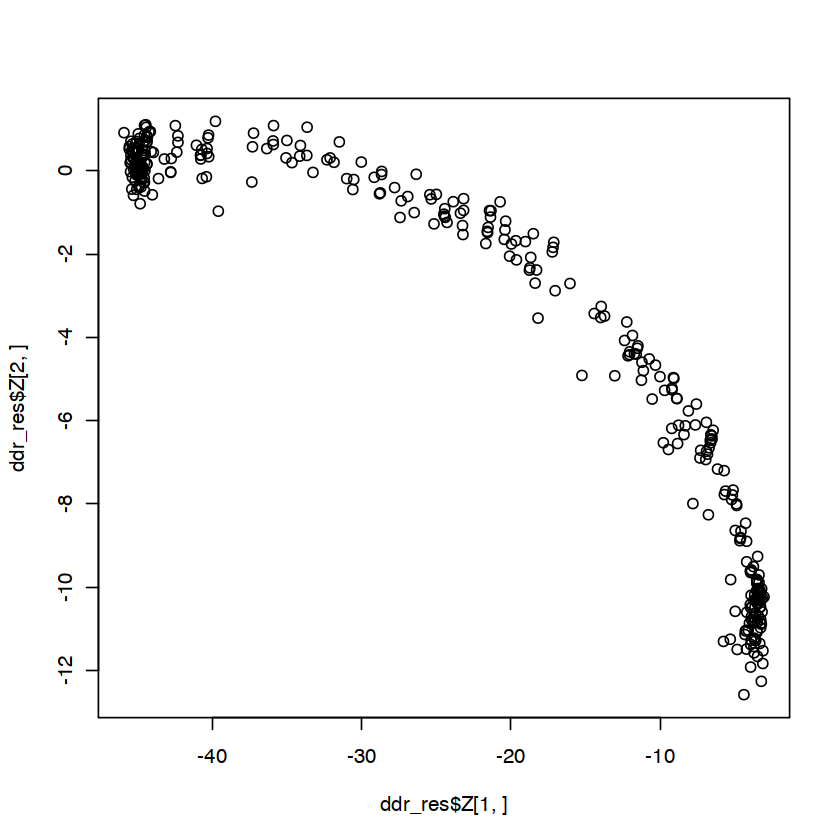

In [87]:
set.seed(1994) 
library(DDRTree)
#log2fc_mat2 = log2fc_mat[,ddr_res$Z[2,]>(-2.5)]
ddr_res = DDRTree(as.matrix(log2fc_mat),
                  dimensions = 2, 
                  ncenter=100,
                  #maxIter = 20,
                  #sigma = 1e-3, 
                  param.gamma=10,
                  #tol = 1e-9,
                  verbose = F)
bulk_pc_df = as.data.frame(t(ddr_res$Z[c(1,2),]))
plot(ddr_res$Z[1,], ddr_res$Z[2,])


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warnin

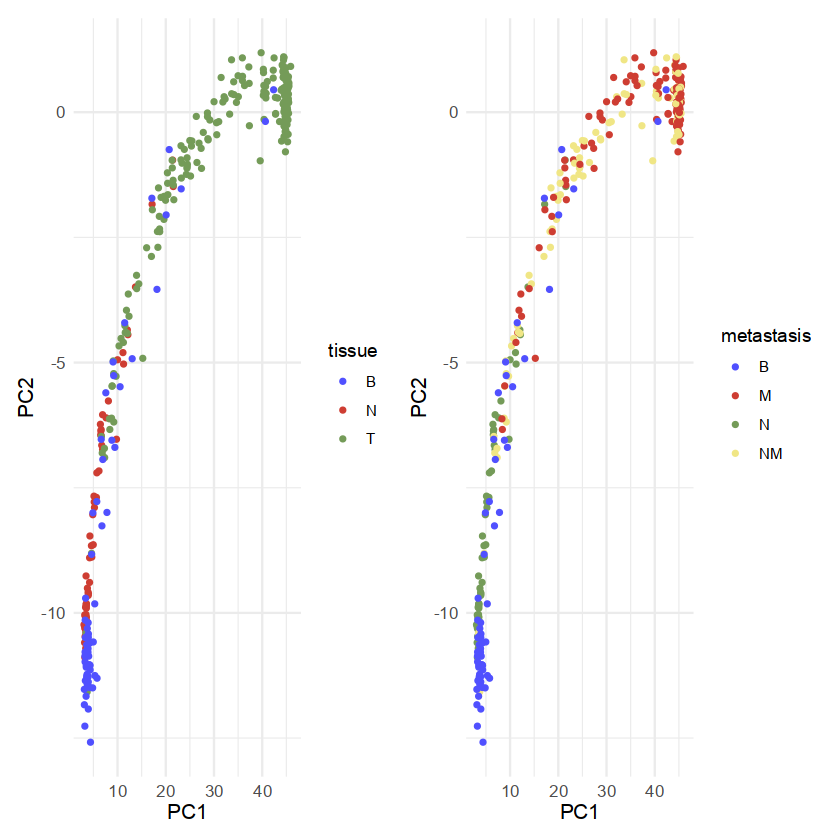

In [88]:

colnames(bulk_pc_df) = c('PC1', 'PC2')
rownames(bulk_pc_df) = colnames(log2fc_mat)
bulk_pc_df$sample <- colnames(log2fc_mat) # gsub('avg_log2FC', '',rownames(pc_df))
bulk_pc_df[, colnames(bulk624_info)] = bulk624_info[bulk_pc_df$sample,]
bulk_pc_df$PC1 = -bulk_pc_df$PC1

a=ggplot(bulk_pc_df, aes(x=PC1, y=PC2, color=tissue)) +
  geom_point(size=1) + scale_color_igv()
b=ggplot(bulk_pc_df, aes(x=PC1, y=PC2, color=metastasis)) +
  geom_point(size=1) + scale_color_igv()
a+b
require(splines)
splinefit = as.data.frame(t(ddr_res$Y))
colnames(splinefit) = c('PC1', 'PC2')
splinefit$PC1 = -splinefit$PC1
#splinefit[splinefit$PC2>-1.4&splinefit$PC1<6.4, 'branch'] = 'branch0'
#splinefit[splinefit$PC2>-1.4&splinefit$PC1>=6.4, 'branch'] = 'branch1'
#splinefit[splinefit$PC2<(-1.4)&splinefit$PC1<6.4, 'branch'] = 'branch2'
#ggplot(splinefit,aes(x=PC1, y=PC2, color=branch))+
#  geom_point()


In [89]:

c(
  'BTN_P' = '#1B9E77',  # Deep turquoise
  'BTN_T' = '#FFD92F',  # Bright yellow
  'PTC_P' = '#7570B3',  # 紫蓝
  'PTC_T' = '#E7298A'   # 洋红/品红
)

bulk_tissue_colors = c(tissue_colors,'BTN_P'='#A6D96A', 'BTN_T'='#FDBF6F', 'PTC_P'='#1B9E77', 'PTC_T'='#D73027')
bulk_metastasis_colors = c(bulk_tissue_colors, 'No'='#C4C2E0', 'LN'='#6A6AB1', 'Distant'='#6A3D9A',
                           'NM'='#C4C2E0', 'M'='#6A3D9A', 'P'='A6D96A', 'T(NM)'='#C4C2E0','T(M)'='#6A6AB1')

#bulk_malignancy = list('trajectory'=bulk_pc_df,
#                       'lines'=splinefit)
#saveRDS(bulk_malignancy, '../organized_data/bulk_trajectory.rds')


BTN_P     BTN_T     PTC_P     PTC_T 
"#1B9E77" "#FFD92F" "#7570B3" "#E7298A"

## Tissue coloring

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


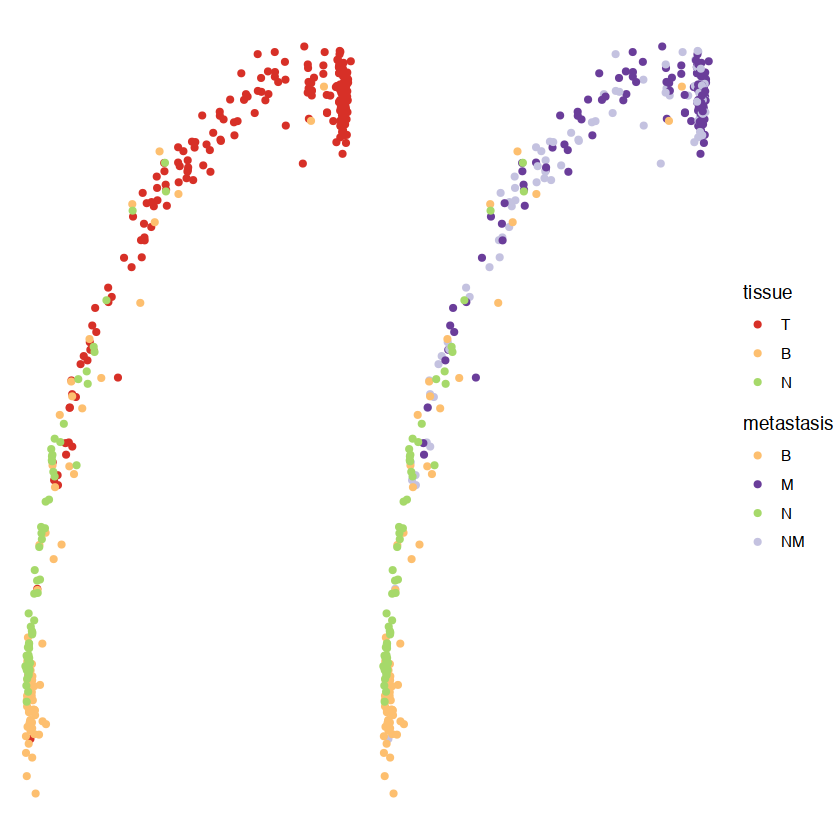

In [90]:

#### Tissue coloring ####
bulk_pc_df$tissue = factor(bulk_pc_df$tissue, c('T','B','N'))
bulk_pc_df = bulk_pc_df %>% arrange(tissue)
fold_res=1
a=bulk_pc_df %>%
  #mutate(Tissue_desc=factor(Tissue_desc, c('N','B', 'T', 'LN_M'))) %>%
  ggplot(aes(x=PC1, y=PC2))+
  geom_point(aes(fill=tissue),size=2, shape=21, color='white', stroke=0.01) +
  #geom_line(data=splinefit,  linewidth=0.4) +
  scale_fill_manual(values=bulk_tissue_colors)+
  theme_void()
b=bulk_pc_df %>%
  #mutate(Tissue_desc=factor(Tissue_desc, c('N','B', 'T', 'LN_M'))) %>%
  ggplot(aes(x=PC1, y=PC2))+
  
  geom_point(aes(fill=metastasis),size=2, shape=21, color='white', stroke=0.01) +
  #geom_line(data=splinefit,  linewidth=0.4) +
  scale_fill_igv()+
  scale_fill_manual(values=bulk_metastasis_colors)+
  theme_void()
xx = (a|b)+patchwork::plot_layout(guides='collect')
xx
ggsave(glue('{output_dir}/bulkmalignant_trajectory(tissuecoloring).pdf'), xx,
       width=160, height=80, units='mm', dpi = 450, bg = 'transparent')


## Pseudotime coloring

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warnin

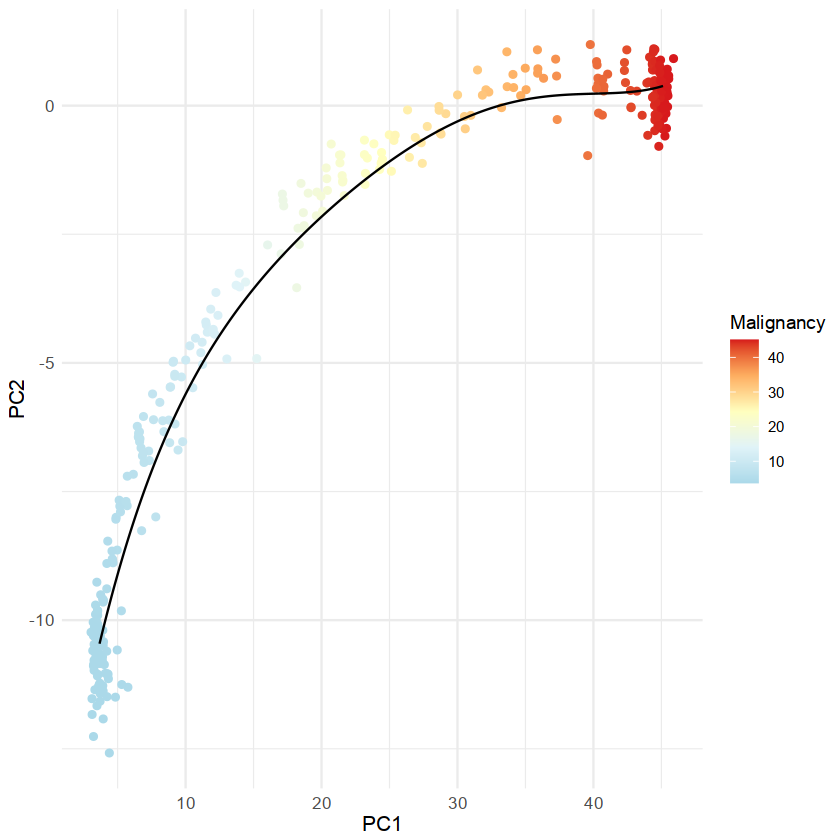

In [91]:
#### 时序coloring ####
splinefit = as.data.frame(t(ddr_res$Y))
colnames(splinefit) = c('PC1', 'PC2')
splinefit$PC1 = -splinefit$PC1
fit<-glm(PC2 ~ poly(PC1,5),data = splinefit)
pre_x<-seq(min(splinefit$PC1)-0.5, max(splinefit$PC1)+1,length.out=1000)
splinefit0 <- data.frame(pre_x, predict(fit, data.frame(PC1=pre_x)))
colnames(splinefit0) <- c("PC1", "PC2")
x_vals0 <- c()
for (i in 1:nrow(bulk_pc_df)){
  x_vals0 <- c(x_vals0,splinefit0$PC1[which.min(sqrt((bulk_pc_df$PC2[i]-splinefit0$PC2)**2+(bulk_pc_df$PC1[i]-splinefit0$PC1)**2))])
}

bulk_pc_df$Pseudotime = x_vals0
ggplot(bulk_pc_df,aes(x=PC1, y=PC2))+
  geom_point(aes(, color=Pseudotime))+
  geom_line(data = splinefit0)+
  scale_color_gradientn(colours = c("#ABD9E9","#E0F3F8",  "#FFFFBF", "#FDAE61", "#D7191C"),name='Malignancy')


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font

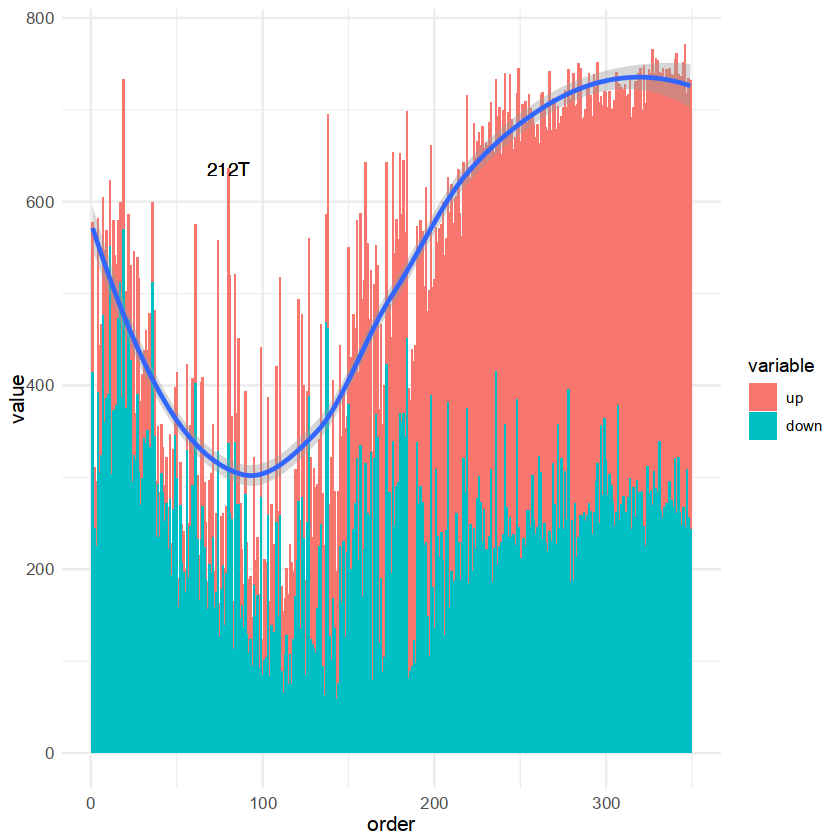

In [92]:
# 确定起点
order_bulk_sample = bulk_pc_df[order(bulk_pc_df$Pseudotime),'sample']
bulk_degs = c()
for(i in order_bulk_sample){
  tmp_up = sum(log2fc_mat[,i]>0.5)
  tmp_down = sum(log2fc_mat[,i]<(-0.5))
  bulk_degs = rbind(bulk_degs, data.frame('up'=tmp_up, 'down'=tmp_down, 'sample'=i))
}
bulk_degs$total = rowSums(bulk_degs[, 1:2])
bulk_degs$order = 1:nrow(bulk_degs)
fit<-loess(total ~ order,data = bulk_degs)
pred_res = predict(fit)
more_half = ((bulk_degs$total - pred_res)/bulk_degs$total) > 0.5
#more_half = more_half & (bulk624_info[bulk_degs$sample, 'tissue'] %in%c('N', 'B'))

bulk_degs$outliers = more_half+0
bulk_degs$pred = pred_res
bulk_degs = melt(bulk_degs, id=c('sample','total','outliers', 'order','pred'))

a = bulk_degs %>%
  #mutate(sample=factor(sample, order_bulk_sample)) %>%
  ggplot(aes(x=order, y=value))+
  geom_bar(aes(, fill = variable),stat='identity')+
  geom_smooth(aes(x=order, y=total, group=1))+
  geom_text(aes(x=order,y=total,label=ifelse(outliers, sample,'')))#+
  #scale_fill_manual(values = c("#D7191C","#2C7BB6"))
a


In [93]:
bulk_pc_df$Tissue = as.vector(bulk_pc_df$metastasis)

bulk_pc_df$Tissue[bulk_pc_df$Tissue=='N'] = 'P'
bulk_pc_df$Tissue[bulk_pc_df$Tissue=='M'] = 'T(M)'
bulk_pc_df$Tissue[bulk_pc_df$Tissue=='NM'] = 'T(NM)'


In [94]:
bulk_metastasis_colors = c(bulk_tissue_colors, 'No'='#C4C2E0', 'LN'='#6A6AB1', 'Distant'='#6A3D9A',
                           'NM'='#C4C2E0', 'M'='#6A3D9A', 'P'='A6D96A', 'T(NM)'='#C4C2E0','T(M)'='#6A6AB1')


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


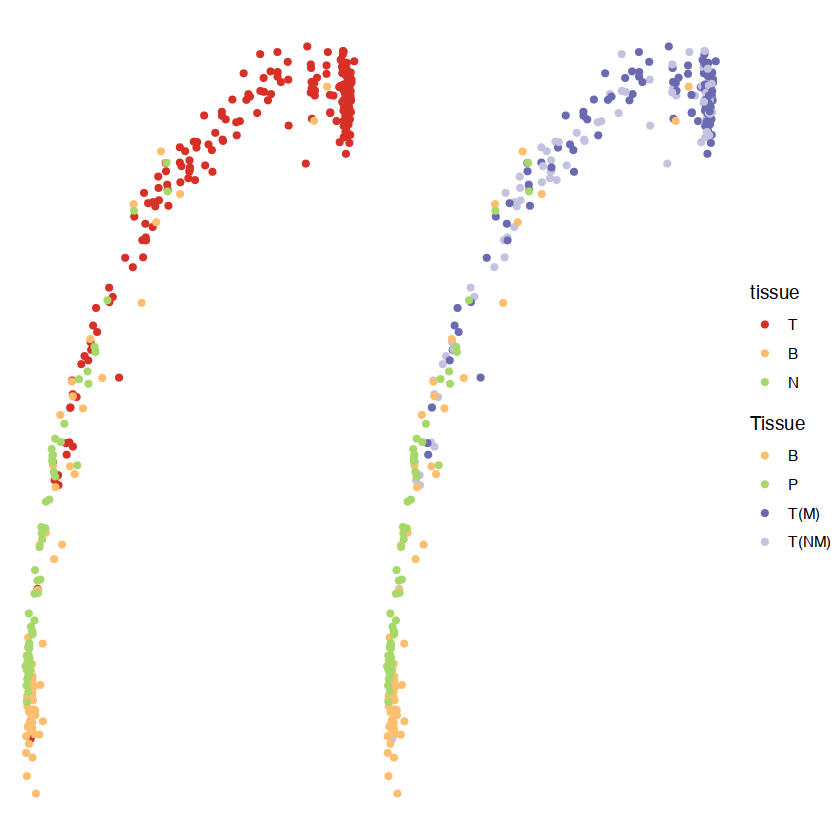

In [95]:

filter_bulk_sample = unique(bulk_degs$sample[bulk_degs$outliers==1])
#
a=bulk_pc_df %>%
  filter(!sample%in%filter_bulk_sample) %>%
  #mutate(Tissue_desc=factor(Tissue_desc, c('N','B', 'T', 'LN_M'))) %>%
  ggplot(aes(x=PC1, y=PC2))+
  geom_point(aes(fill=tissue),size=2, shape=21, color='white', stroke=0.01) +
  #geom_line(data=splinefit,  linewidth=0.4) +
  scale_fill_manual(values=bulk_tissue_colors)+
  theme_void()
b=bulk_pc_df %>%
  filter(!sample%in%filter_bulk_sample) %>%
  #mutate(Tissue_desc=factor(Tissue_desc, c('N','B', 'T', 'LN_M'))) %>%
  ggplot(aes(x=PC1, y=PC2))+
  
  geom_point(aes(fill=Tissue),size=2, shape=21, color='black', stroke=0.01) +
  #geom_line(data=splinefit,  linewidth=0.4) +
  scale_fill_igv()+
  scale_fill_manual(values=bulk_metastasis_colors)+
  theme_void()
xx = (a|b)+patchwork::plot_layout(guides='collect')
xx
ggsave(glue('{output_dir}/bulkmalignant_trajectory(tissuecoloringfilter).pdf'), xx,
       width=180, height=80, units='mm', dpi = 450, bg = 'transparent')


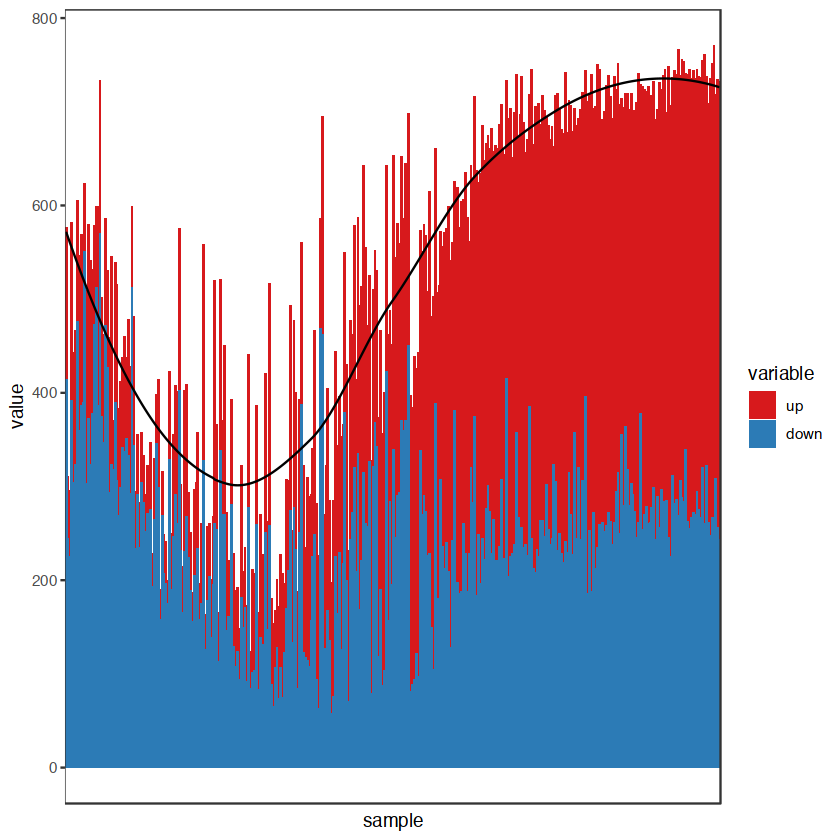

In [96]:
a = bulk_degs %>%
  filter(!sample%in%filter_bulk_sample) %>%
  mutate(sample=factor(sample, order_bulk_sample)) %>%
  ggplot(aes(x=sample, y=value))+
  geom_bar(aes(, fill = variable),stat='identity', color=NA, width = 1)+
  #geom_smooth(aes(x=sample, y=total, group=1), se=F, color='black')+
  geom_line(aes(x=sample, y=pred, group=1))+
  geom_text(aes(x=sample,y=total,label=ifelse(outliers, sample,'')))+
  scale_fill_manual(values = c("#D7191C","#2C7BB6"))+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank())
a
ggsave(glue('{output_dir}/bulkmalignant_trajectory(DGE).pdf'), a,
       width=100, height=60, units='mm', dpi = 450, bg = 'transparent')


In [97]:
bulk_degs_total = bulk_degs %>%
    group_by(sample) %>%
    summarise(total=sum(total)) %>%
    as.data.frame()
rownames(bulk_degs_total)  = bulk_degs_total$sample


## DEGs着色

In [98]:
bulk_pc_df$DEG = bulk_degs_total[bulk_pc_df$sample,2]

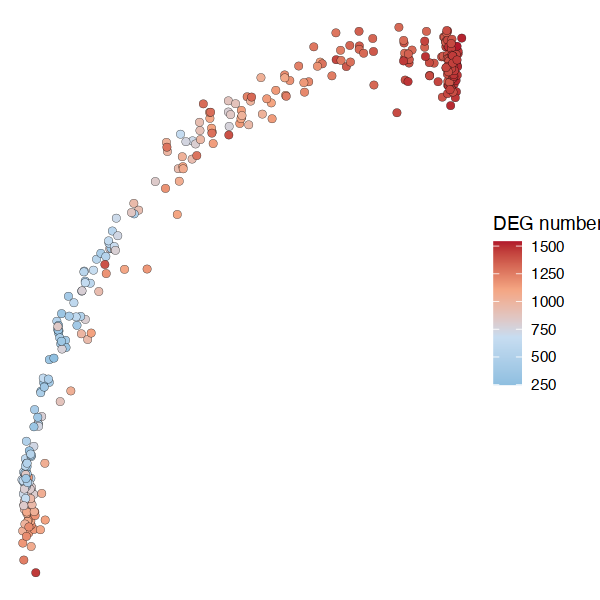

In [99]:
# 
a=bulk_pc_df %>%
  filter(!sample%in%filter_bulk_sample) %>%
  #mutate(Tissue_desc=factor(Tissue_desc, c('N','B', 'T', 'LN_M'))) %>%
  ggplot(aes(x=PC1, y=PC2)) +
  geom_point(aes(fill=DEG),size=2, shape=21, , stroke=0.1) +
  scale_fill_gradientn(colours = c( "#8FBFE0", "#C7DDF1", "#F4A582", "#B2182B"),name='DEG number')+
  theme_void()
options(repr.plot.width=5, repr.plot.height=5)
a
ggsave(glue('{output_dir}/bulkmalignant_trajectory(DEGcoloring_legend).pdf'),
       plot = get_legend(a), width = 5, height = 5)
ggsave(glue('{output_dir}/bulkmalignant_trajectory(DEGcoloring).pdf'), a+NoLegend(),
       width=70, height=60, units='mm', dpi = 450, bg = 'transparent')


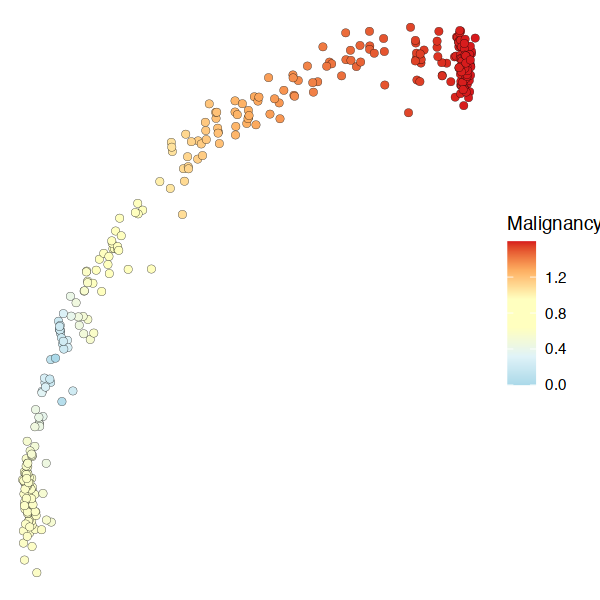

In [100]:

# 选择最地点作为起始点
root_sample = bulk_degs %>% filter(!sample%in%filter_bulk_sample)
root_sample = root_sample[which.min(root_sample$total), 'sample']

# 矫正pseudotime
bulk_pc_df$Pseudotime_branch = bulk_pc_df$Pseudotime-bulk_pc_df[root_sample, 'Pseudotime']
bulk_pc_df$Pseudotime = abs(bulk_pc_df$Pseudotime-bulk_pc_df[root_sample, 'Pseudotime'])


a=bulk_pc_df %>%
  ggplot(aes(x=PC1, y=PC2))+
  #geom_line(data=splinefit,  linewidth=0.1) +
  geom_point(aes(fill=log10(Pseudotime+1)),size=2, shape=21, stroke=0.1) +
  #scale_color_npg()+
  scale_fill_gradientn(colours = c("#ABD9E9","#E0F3F8", "#FFFFBF", "#FFFFBF", "#FDAE61", "#D7191C"),name='Malignancy')+
  theme_void()
a
ggsave(glue('{output_dir}/bulkmalignant_trajectory(pseudotimecoloring_legend).pdf'),
       plot = get_legend(a), width = 5, height = 5)
ggsave(glue('{output_dir}/bulkmalignant_trajectory(pseudotimecoloring).pdf'), a+NoLegend(),
       width=70, height=60, units='mm', dpi = 450, bg = 'transparent')


In [101]:
bulk_malignancy = list('trajectory'=bulk_pc_df,
                       'lines'=splinefit)
saveRDS(bulk_malignancy, '../organized_data/bulk_trajectory.rds')

## 组织累计distribution

In [26]:
xx = read.table('../organized_data/bulk_trajectory_meta.table')
dim(xx)

[1] 386  10

In [27]:
table(xx$tissue)


  B   N   T 
 68 103 215 

In [102]:
#### 组织累计distribution ####
tmp_pc_df2 = bulk_pc_df %>% 
  filter(Pseudotime_branch>=0) %>% 
  #filter(!sample%in%filter_bulk_sample)  %>% 
  arrange(Pseudotime)
tmp_pc_df2[,'N'] = cumsum(tmp_pc_df2$tissue=='N')
tmp_pc_df2[,'B'] = cumsum(tmp_pc_df2$tissue=='B')
#tmp_pc_df2[,'T'] = cumsum(tmp_pc_df2$tissue=='T')
# tmp_pc_df2[,'Distant'] = cumsum(tmp_pc_df2$metastasis=='Distant')
# tmp_pc_df2[,'LN'] = cumsum(tmp_pc_df2$metastasis=='LN')
# tmp_pc_df2[,'No'] = cumsum(tmp_pc_df2$metastasis=='No')
tmp_pc_df2[,'NM'] = cumsum(tmp_pc_df2$metastasis=='NM')
tmp_pc_df2[,'M'] = cumsum(tmp_pc_df2$metastasis=='M')

tmp_pc_df2[,'N'] = tmp_pc_df2[,'N'] / max(tmp_pc_df2[,'N'])
tmp_pc_df2[,'B'] = tmp_pc_df2[,'B'] / max(tmp_pc_df2[,'B'])
#tmp_pc_df2[,'T'] = tmp_pc_df2[,'T'] / max(tmp_pc_df2[,'T'])
#tmp_pc_df2[,'Distant'] = tmp_pc_df2[,'Distant'] / max(tmp_pc_df2[,'Distant'])
#tmp_pc_df2[,'LN'] = tmp_pc_df2[,'LN'] / max(tmp_pc_df2[,'LN'])
#tmp_pc_df2[,'No'] = tmp_pc_df2[,'No'] / max(tmp_pc_df2[,'No'])
tmp_pc_df2[,'NM'] = tmp_pc_df2[,'NM'] / max(tmp_pc_df2[,'NM'])
tmp_pc_df2[,'M'] = tmp_pc_df2[,'M'] / max(tmp_pc_df2[,'M'])
#tmp_pc_df2$order = 1:nrow(tmp_pc_df2)
a1=reshape2::melt(tmp_pc_df2[, c('Pseudotime', 'N','B',#'T',#'PTC_T'#,
                                 #'Distant','LN','No' 
                                 'NM', 'M'
)],
id='Pseudotime')


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


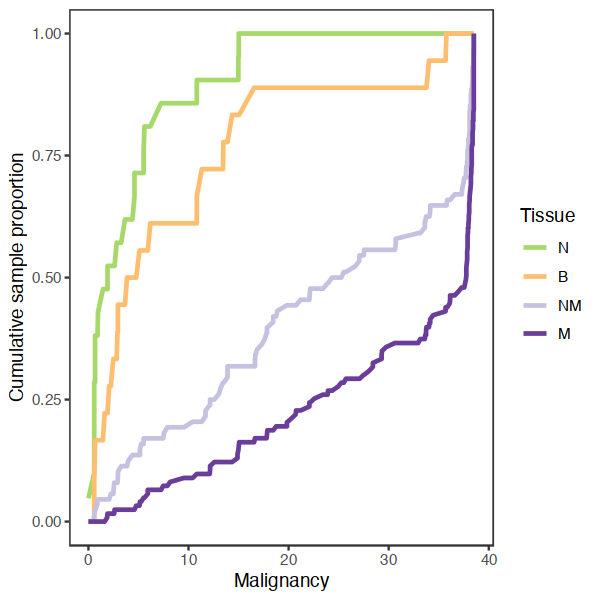

In [103]:
options(repr.plot.width=5, repr.plot.height=5)
a = a1 %>%
  #mutate(variable=factor(variable, c('BTN_P','PTC_P','BTN_T','PTC_T'))) %>%
  ggplot(aes(x=Pseudotime, y=value, color=variable))+
  #geom_vline(xintercept = p_end_time, linetype='dashed', color='gray', size=0.5)+
  #geom_vline(xintercept = b_end_time, linetype='dashed', color='gray', size=0.5)+
  geom_line(size=1)+
  scale_color_manual(values = bulk_metastasis_colors[levels(a1$variable)], name='Tissue')+
  labs(x='Malignancy', y='Cumulative sample proportion')+
  theme_bw()+
  theme(panel.grid = element_blank())
a
ggsave(glue('{output_dir}/bulkmalignant_trajectory(tissuecumulativedistribution).pdf'), a,
       width=85, height=60, units='mm', dpi = 450, bg = 'transparent')

# write.table(bulk_pc_df, '../organized_data/bulk_trajectory_meta.table', sep='\t')


In [104]:
#### branch2 ####
tmp_pc_df2 = bulk_pc_df %>% 
  filter(Pseudotime_branch<=0) %>% 
  filter(metastasis!='NM')  %>% 
  arrange(Pseudotime)
tmp_pc_df2[,'N'] = cumsum(tmp_pc_df2$tissue=='N')
tmp_pc_df2[,'B'] = cumsum(tmp_pc_df2$tissue=='B')
#tmp_pc_df2[,'T'] = cumsum(tmp_pc_df2$tissue=='T')
# tmp_pc_df2[,'Distant'] = cumsum(tmp_pc_df2$metastasis=='Distant')
# tmp_pc_df2[,'LN'] = cumsum(tmp_pc_df2$metastasis=='LN')
# tmp_pc_df2[,'No'] = cumsum(tmp_pc_df2$metastasis=='No')
tmp_pc_df2[,'NM'] = cumsum(tmp_pc_df2$metastasis=='NM')
tmp_pc_df2[,'M'] = cumsum(tmp_pc_df2$metastasis=='M')

tmp_pc_df2[,'N'] = tmp_pc_df2[,'N'] / max(tmp_pc_df2[,'N'])
tmp_pc_df2[,'B'] = tmp_pc_df2[,'B'] / max(tmp_pc_df2[,'B'])
#tmp_pc_df2[,'T'] = tmp_pc_df2[,'T'] / max(tmp_pc_df2[,'T'])
#tmp_pc_df2[,'Distant'] = tmp_pc_df2[,'Distant'] / max(tmp_pc_df2[,'Distant'])
#tmp_pc_df2[,'LN'] = tmp_pc_df2[,'LN'] / max(tmp_pc_df2[,'LN'])
#tmp_pc_df2[,'No'] = tmp_pc_df2[,'No'] / max(tmp_pc_df2[,'No'])
tmp_pc_df2[,'NM'] = tmp_pc_df2[,'NM'] / max(tmp_pc_df2[,'NM'])
tmp_pc_df2[,'M'] = tmp_pc_df2[,'M'] / max(tmp_pc_df2[,'M'])
#tmp_pc_df2$order = 1:nrow(tmp_pc_df2)
a1=reshape2::melt(tmp_pc_df2[, c('Pseudotime', 'N','B',#'T',#'PTC_T'#,
                                 #'Distant','LN','No' 
                                 'NM', 'M'
)],
id='Pseudotime')


Warning message:
“Removed 194 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 194 rows containing missing values or values outside the scale range (`geom_line()`).”


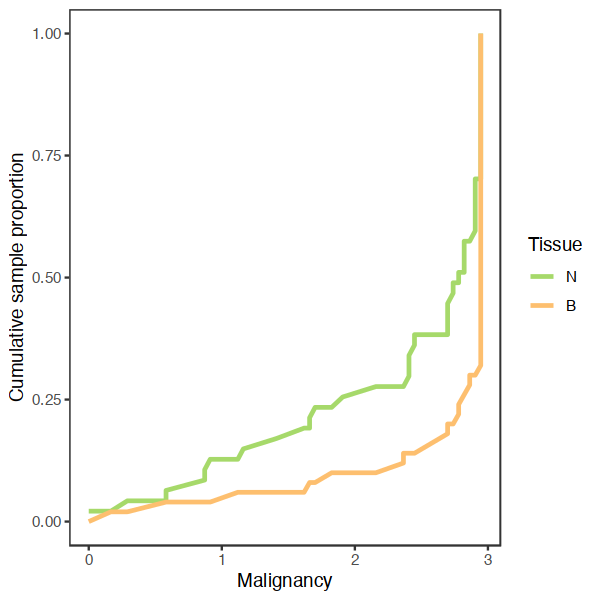

In [105]:
a = a1 %>%
  #mutate(variable=factor(variable, c('BTN_P','PTC_P','BTN_T','PTC_T'))) %>%
  ggplot(aes(x=Pseudotime, y=value, color=variable))+
  #geom_vline(xintercept = p_end_time, linetype='dashed', color='gray', size=0.5)+
  #geom_vline(xintercept = b_end_time, linetype='dashed', color='gray', size=0.5)+
  geom_line(size=1)+
  scale_color_manual(values = bulk_metastasis_colors[c('N','B')], name='Tissue')+
  labs(x='Malignancy', y='Cumulative sample proportion')+
  theme_bw()+
  theme(panel.grid = element_blank())
a
ggsave(glue('{output_dir}/bulkmalignant_trajectory(tissuecumulativedistributionbranch2).pdf'), a,
       width=85, height=60, units='mm', dpi = 450, bg = 'transparent')

In [10]:
bulk_pc_df = read.table('../organized_data/bulk_trajectory_meta.table')

## 评分变化

In [106]:
#### 评分变化 ####
library(AUCell)
bulk624 = read.table('../sample_info/thyroid_cancer_bulk_data/624samples_ucsc.expr.data.txt', check.names = F)
bulk624 = as.data.frame(log2(bulk624+1))
# srt = AddModuleScore(srt, features = list(TDS_marker,BRAF_marker, RAS_marker))

In [107]:
cells_rankings <- AUCell_buildRankings(as.matrix(bulk624),plotStats = FALSE)
cells_AUC <- AUCell_calcAUC(list('TDS'=TDS_marker,'BRAF'=BRAF_marker, 'RAS'=RAS_marker), 
                            cells_rankings)
auc_matrix <- as.data.frame(getAUC(cells_AUC))


In [108]:
bulk_pc_df[, c('TDS_score', 'BRAF_score', 'RAS_score')] = t(auc_matrix[,bulk_pc_df$sample])
bulk_pc_df$TG = unlist(bulk624['TG',bulk_pc_df$sample, drop=T])
bulk_pc_df$TSHR = unlist(bulk624['TSHR',bulk_pc_df$sample, drop=T])

In [109]:

tmp_pc_df2 = bulk_pc_df %>% 
  filter(Pseudotime_branch>=0) %>% 
  #filter(!sample%in%filter_bulk_sample)  %>% 
  arrange(Pseudotime)
#tmp_pc_df2 = bulk_pc_df %>% arrange(Pseudotime)
#tmp_pc_df2 = new_bulk_pc_df %>% filter(branch!='branch2')  %>% arrange(Pseudotime)
tmp_pc_df2[, c('TDS_score', 'BRAF_score', 'RAS_score')] = t(auc_matrix[,tmp_pc_df2$sample])
tmp_pc_df2$TG = unlist(bulk624['TG',tmp_pc_df2$sample, drop=T])
tmp_pc_df2$TSHR = unlist(bulk624['TSHR',tmp_pc_df2$sample, drop=T])


### TG,TDS

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


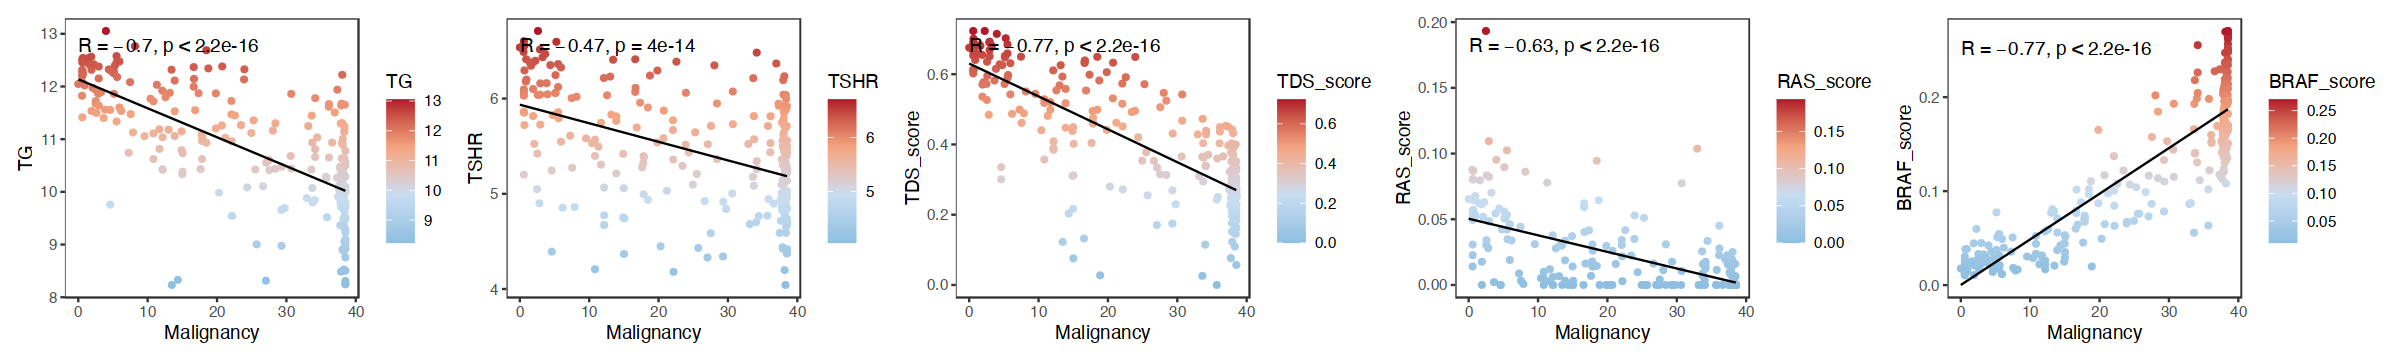

In [110]:

a=tmp_pc_df2 %>%
  filter(TG>8) %>%
  ggplot(aes(x=Pseudotime, y=TG))+
  geom_point(aes(fill=TG),size=2, shape=21, , stroke=NA) +
  scale_fill_gradientn(colours = c( "#8FBFE0", "#C7DDF1", "#F4A582", "#B2182B"),name='TG')+
  stat_cor(aes(x=Pseudotime, y=TG))+
  geom_smooth(se=F,  linewidth=0.5, color='black',method='lm')+
  labs(x='Malignancy', y='TG')+
  theme_bw()+
  theme(panel.grid = element_blank())
b=tmp_pc_df2 %>%
  filter(TSHR>4) %>%
  ggplot(aes(x=Pseudotime, y=TSHR))+
  geom_point(aes(fill=TSHR),size=2, shape=21, , stroke=NA) +
  scale_fill_gradientn(colours = c( "#8FBFE0", "#C7DDF1", "#F4A582", "#B2182B"),name='TSHR')+
  stat_cor(aes(x=Pseudotime, y=TSHR))+
  geom_smooth(se=F,  linewidth=0.5, color='black',method='lm')+
  labs(x='Malignancy', y='TSHR')+
  theme_bw()+
  theme(panel.grid = element_blank())
c=tmp_pc_df2 %>%
  ggplot(aes(x=Pseudotime, y=TDS_score))+
  geom_point(aes(fill=TDS_score),size=2, shape=21, , stroke=NA) +
  scale_fill_gradientn(colours = c( "#8FBFE0", "#C7DDF1", "#F4A582", "#B2182B"),name='TDS_score')+
  stat_cor(aes(x=Pseudotime, y=TDS_score))+
  geom_smooth(se=F,  linewidth=0.5, color='black',method='lm')+
  labs(x='Malignancy', y='TDS_score')+
  theme_bw()+
  theme(panel.grid = element_blank())

d=tmp_pc_df2 %>%
  ggplot(aes(x=Pseudotime, y=BRAF_score))+
  geom_point(aes(fill=BRAF_score),size=2, shape=21, , stroke=NA) +
  scale_fill_gradientn(colours = c( "#8FBFE0", "#C7DDF1", "#F4A582", "#B2182B"),name='BRAF_score')+
  stat_cor(aes(x=Pseudotime, y=TDS_score), label.y = 0.25)+
  geom_smooth(se=F,  linewidth=0.5, color='black',method='lm')+
  labs(x='Malignancy', y='BRAF_score')+
  theme_bw()+
  theme(panel.grid = element_blank())
e=tmp_pc_df2 %>%
  ggplot(aes(x=Pseudotime, y=RAS_score))+
  geom_point(aes(fill=RAS_score),size=2, shape=21, , stroke=NA) +
  scale_fill_gradientn(colours = c( "#8FBFE0", "#C7DDF1", "#F4A582", "#B2182B"),name='RAS_score')+
  stat_cor(aes(x=Pseudotime, y=RAS_score))+
  geom_smooth(se=F,  linewidth=0.5, color='black',method='lm')+
  labs(x='Malignancy', y='RAS_score')+
  theme_bw()+
  theme(panel.grid = element_blank())

options(repr.plot.width=20, repr.plot.height=3)
a|b|c|e|d
ggsave(glue('{output_dir}/bulkmalignant_trajectory_得分expression_change.pdf'), plot = a|b|c|e|d, width = 20, height = 3)


### HALLMARK评分

In [111]:
#### HALLMARK评分在轨迹的变化 #####
keep_hallmark = read.table('../organized_data/trajectory_enrichment_hallmark.txt')
hallmark_data = GSEABase::getGmt('/Volumes/WX_extend//wangxin/Rprojects/cancer/h.all.v7.4.symbols.gmt')
hallmark_data = hallmark_data@.Data
hallmark_list = list()
for(i in hallmark_data){
  tmp_name = gsub('HALLMARK_','',i@setName)
  if(tmp_name %in% keep_hallmark$hallmark){
    hallmark_list[[tmp_name]] = i@geneIds
  }
}
hallmark_AUC <- AUCell_calcAUC(hallmark_list, cells_rankings)
hallmark_AUC_matrix <- as.data.frame(getAUC(hallmark_AUC))

Genes in the gene sets NOT available in the dataset: 
	TNFA_SIGNALING_VIA_NFKB: 	1 (0% of 200)
	HYPOXIA: 	1 (0% of 200)
	CHOLESTEROL_HOMEOSTASIS: 	1 (1% of 74)
	MITOTIC_SPINDLE: 	2 (1% of 199)
	APOPTOSIS: 	1 (1% of 161)
	ESTROGEN_RESPONSE_LATE: 	1 (0% of 200)
	ANDROGEN_RESPONSE: 	2 (2% of 100)
	MYOGENESIS: 	2 (1% of 200)
	INTERFERON_ALPHA_RESPONSE: 	2 (2% of 97)
	INTERFERON_GAMMA_RESPONSE: 	3 (2% of 200)
	COMPLEMENT: 	1 (0% of 200)
	UNFOLDED_PROTEIN_RESPONSE: 	4 (4% of 113)
	MTORC1_SIGNALING: 	3 (2% of 200)
	EPITHELIAL_MESENCHYMAL_TRANSITION: 	1 (0% of 200)
	INFLAMMATORY_RESPONSE: 	1 (0% of 200)
	FATTY_ACID_METABOLISM: 	1 (1% of 158)
	P53_PATHWAY: 	4 (2% of 200)
	UV_RESPONSE_UP: 	2 (1% of 158)
	UV_RESPONSE_DN: 	1 (1% of 144)
	COAGULATION: 	1 (1% of 138)
	ALLOGRAFT_REJECTION: 	4 (2% of 200)
	KRAS_SIGNALING_DN: 	2 (1% of 200)



In [16]:
bulk_pc_df[, c('TDS_score', 'BRAF_score', 'RAS_score')] = t(auc_matrix[,bulk_pc_df$sample])
bulk_pc_df$TG = unlist(bulk624['TG',bulk_pc_df$sample, drop=T])
bulk_pc_df$TSHR = unlist(bulk624['TSHR',bulk_pc_df$sample, drop=T])

In [17]:
hallmark_AUC_matrix <- as.data.frame(getAUC(hallmark_AUC))

In [18]:
bulk_pc_df$HYPOXIA = t(hallmark_AUC_matrix)[bulk_pc_df$sample,'HYPOXIA']
bulk_pc_df$TGF_beta = t(hallmark_AUC_matrix)[bulk_pc_df$sample,'TGF_BETA_SIGNALING']
#bulk_pc_df$OXPHOS = t(hallmark_AUC_matrix)[bulk_pc_df$sample,'OXIDATIVE_PHOSPHORYLATION']
bulk_pc_df$IFN_alpha = t(hallmark_AUC_matrix)[bulk_pc_df$sample,'INTERFERON_ALPHA_RESPONSE']
bulk_pc_df$IFN_gamma = t(hallmark_AUC_matrix)[bulk_pc_df$sample,'INTERFERON_GAMMA_RESPONSE']
bulk_pc_df$EMT = t(hallmark_AUC_matrix)[bulk_pc_df$sample,'EPITHELIAL_MESENCHYMAL_TRANSITION']
bulk_pc_df$P53 = t(hallmark_AUC_matrix)[bulk_pc_df$sample,'P53_PATHWAY']

In [19]:
dim(hallmark_AUC_matrix)

[1]  26 624

In [20]:
bulk_pc_df[, rownames(hallmark_AUC_matrix)] = t(hallmark_AUC_matrix)[bulk_pc_df$sample,]

In [23]:
dim(bulk_pc_df)

[1] 386  46

In [22]:
bulk_malignancy = list('trajectory'=bulk_pc_df,
                       'lines'=NULL#splinefit
                       )
saveRDS(bulk_malignancy, '../organized_data/bulk_trajectory.rds')

In [41]:

tmp_pc_df2 = bulk_pc_df %>% 
  filter(Pseudotime_branch>=0) %>% 
  #filter(!sample%in%filter_bulk_sample)  %>% 
  arrange(Pseudotime)
hallmark_AUC_matrix = hallmark_AUC_matrix[,tmp_pc_df2$sample]

hallmark_AUC_matrix = t(apply(hallmark_AUC_matrix,1 ,scale))

hallmark_AUC_matrix2 = apply(hallmark_AUC_matrix, 1, function(x){
  tmp_lm = loess(y~x, data=data.frame(x=1:ncol(hallmark_AUC_matrix),y=x))
  predict(tmp_lm)
})
#hallmark_AUC_matrix2 = t(hallmark_AUC_matrix)
hallmark_AUC_matrix2 = as.data.frame(t(hallmark_AUC_matrix2))
colnames(hallmark_AUC_matrix2) = tmp_pc_df2$sample


h1=Heatmap(hallmark_AUC_matrix2[keep_hallmark$hallmark[keep_hallmark$group=='up'],],
           cluster_columns = F,
           show_row_dend = F, show_column_names = F,
           #col = circlize::colorRamp2(c(0,0.05, 0.1,0.15, 0.2), c("#762A83", "#AF8DC3", "#E0E0E0", "#F7D458", "#D7191C")),
           col = circlize::colorRamp2(c(-1,-0.5, 0,0.5, 1), c("#762A83", "#AF8DC3", "#E0E0E0", "#F7D458", "#D7191C")),
           
           heatmap_legend_param = list('title'='EnrichScore')
)
h2=Heatmap(hallmark_AUC_matrix2[keep_hallmark$hallmark[keep_hallmark$group=='down'],],
           cluster_columns = F,
           show_row_dend = F, show_column_names = F,
           #col = circlize::colorRamp2(c(0,0.05, 0.1,0.15, 0.2), c("#762A83", "#AF8DC3", "#E0E0E0", "#F7D458", "#D7191C")),
           col = circlize::colorRamp2(c(-1,-0.5, 0,0.5, 1), c("#762A83", "#AF8DC3", "#E0E0E0", "#F7D458", "#D7191C")),
           
           heatmap_legend_param = list('title'='EnrichScore')
)
h3=Heatmap(hallmark_AUC_matrix2[,],
           cluster_columns = F,
           show_row_dend = F, show_column_names = F,
           width = unit(0.1,'mm')*ncol(hallmark_AUC_matrix2),
           #col = circlize::colorRamp2(c(0,0.05, 0.1,0.15, 0.2), c("#762A83", "#AF8DC3", "#E0E0E0", "#F7D458", "#D7191C")),
           col = circlize::colorRamp2(c(-1,-0.5, 0,0.5, 1), c("#762A83", "#AF8DC3", "#E0E0E0", "#F7D458", "#D7191C")),
           
           heatmap_legend_param = list('title'='EnrichScore')
)

pdf(glue('{output_dir}/bulkmalignant_trajectory_molecular_features(function).pdf'), width=5, height=4)
h2%v%h1
dev.off()



Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”


pdf 
  2

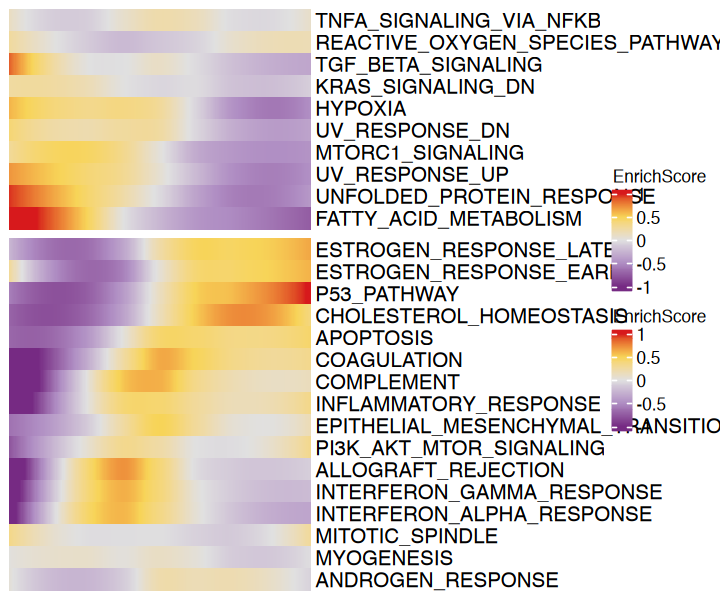

In [43]:
options(repr.plot.width=6, repr.plot.height=5)
h2%v%h1

In [ ]:

hallmark_AUC_matrix <- as.data.frame(getAUC(hallmark_AUC))
hallmark_AUC_matrix = hallmark_AUC_matrix2
#hallmark_AUC_matrix = t(apply(hallmark_AUC_matrix,1 ,scale))
#colnames(hallmark_AUC_matrix) = colnames(as.data.frame(getAUC(hallmark_AUC)))
tmp_pc_df2$HYPOXIA = t(hallmark_AUC_matrix)[tmp_pc_df2$sample,'HYPOXIA']
tmp_pc_df2$TGFb = t(hallmark_AUC_matrix)[tmp_pc_df2$sample,'TGF_BETA_SIGNALING']
tmp_pc_df2$INFa = t(hallmark_AUC_matrix)[tmp_pc_df2$sample,'INTERFERON_ALPHA_RESPONSE']
tmp_pc_df2$EMT = t(hallmark_AUC_matrix)[tmp_pc_df2$sample,'EPITHELIAL_MESENCHYMAL_TRANSITION']

a=tmp_pc_df2 %>%
  ggplot(aes(x=Pseudotime, y=HYPOXIA))+
  geom_point(aes(fill=HYPOXIA),size=2, shape=21, color='white') +
  geom_smooth(method = "loess", se=F,  formula = y~x, size=0.5,  color='black')+
  scale_fill_gradientn(colours = c("#762A83", "#AF8DC3", "#E0E0E0", "#F7D458", "#D7191C"),name='HYPOXIA_score')+
  stat_cor( method='pearson', size=4)+
  theme_minimal()+
  labs(x='Malignancy')+
  theme(panel.border = element_rect(color='black', fill=NA),
        strip.background = element_blank(),
        panel.grid = element_blank(),
        legend.key.width = unit(3,'mm'),
        legend.key.height = unit(3,'mm')) 
b=tmp_pc_df2 %>%
  ggplot(aes(x=Pseudotime, y=TGFb))+
  geom_point(aes(fill=TGFb),size=2, shape=21, color='white') +
  geom_smooth(method = "loess", se=F,  formula = y~x, size=0.5,  color='black')+
  scale_fill_gradientn(colours = c("#762A83", "#AF8DC3", "#E0E0E0", "#F7D458", "#D7191C"),name='TGFb_score')+
  stat_cor( method='pearson', size=4)+
  theme_minimal()+
  labs(x='Malignancy')+
  theme(panel.border = element_rect(color='black', fill=NA),
        strip.background = element_blank(),
        panel.grid = element_blank(),
        legend.key.width = unit(3,'mm'),
        legend.key.height = unit(3,'mm')) 
c=tmp_pc_df2 %>%
  ggplot(aes(x=Pseudotime, y=INFa))+
  geom_point(aes(fill=INFa),size=2, shape=21, color='white') +
  geom_smooth(method = "loess", se=F,  formula = y~x, size=0.5,  color='black')+
  scale_fill_gradientn(colours = c("#762A83", "#AF8DC3", "#E0E0E0", "#F7D458", "#D7191C"),name='INFa_score')+
  stat_cor( method='pearson', size=4)+
  theme_minimal()+
  labs(x='Malignancy')+
  theme(panel.border = element_rect(color='black', fill=NA),
        strip.background = element_blank(),
        panel.grid = element_blank(),
        legend.key.width = unit(3,'mm'),
        legend.key.height = unit(3,'mm')) 
d=tmp_pc_df2 %>%
  ggplot(aes(x=Pseudotime, y=EMT))+
  geom_point(aes(fill=EMT),size=2, shape=21, stroke=0) +
  geom_smooth(method = "loess", se=F,  formula = y~x, size=0.5,  color='black')+
  scale_fill_gradientn(colours = c("#762A83", "#AF8DC3", "#E0E0E0", "#F7D458", "#D7191C"),name='EMT_score')+
  stat_cor( method='pearson', size=4)+
  theme_minimal()+
  labs(x='Malignancy')+
  theme(panel.border = element_rect(color='black', fill=NA),
        strip.background = element_blank(),
        panel.grid = element_blank(),
        legend.key.width = unit(3,'mm'),
        legend.key.height = unit(3,'mm')) 

ggsave(glue('{output_dir}/bulkmalignant_trajectory(differential_gene_enrichment_functioncoloring).pdf'),a/b/c/d,
       width=110, height=190, units='mm', dpi = 450, bg = 'transparent')


### TF 变化 

In [ ]:
#### TF 变化 ####
setwd('../Thyroid_code/scenic/')
regulons <- readRDS("int/2.5_regulonTargetsInfo.Rds") %>% as.data.frame()
setwd('../Thyroid_code')
if_names=c("FOS (35g)","JUND (168g)","FOSB (153g)",
           
           "MAFF_extended (50g)","MAFB_extended (17g)","CEBPB (25g)","XBP1 (118g)","CREB5_extended (13g)","DDIT3 (26g)",
           
           "IRF1_extended (32g)",  "IRF7 (18g)", "IRF9 (67g)",
           
           "ETV7_extended (20g)", "ELF3_extended (30g)","ETV5 (27g)",
           
           "NR1D1 (13g)","NR2F1_extended (25g)","RXRG_extended (13g)","HIF1A (23g)", 
           
           "BHLHE40_extended (141g)","SREBF1 (35g)"
)

TF_target_list = list()
for(i in if_names){
  tmp_tf = strsplit(i, ' ')[[1]][1]
  tmp_tf = gsub('_extended', '', tmp_tf)
  TF_target_list[[tmp_tf]] = regulons[regulons$TF==tmp_tf, 'gene']
}
TF_AUC <- AUCell_calcAUC(TF_target_list, cells_rankings)
TF_AUC_matrix <- as.data.frame(getAUC(TF_AUC))
tmp_pc_df2 = bulk_pc_df %>% 
  filter(Pseudotime_branch>=0) %>% 
  #filter(!sample%in%filter_bulk_sample)  %>% 
  arrange(Pseudotime)
TF_AUC_matrix = TF_AUC_matrix[, tmp_pc_df2$sample]

TF_AUC_matrix = t(apply(TF_AUC_matrix,1 ,scale))
#new_tf_smooth = TF_AUC_matrix
new_tf_smooth = apply(TF_AUC_matrix, 1, function(x){
  tmp_lm = loess(y~x, data=data.frame(x=1:ncol(TF_AUC_matrix),y=x))
  predict(tmp_lm)
})
new_tf_smooth = as.data.frame(t(new_tf_smooth))
colnames(new_tf_smooth) = colnames(TF_AUC_matrix)
rownames(new_tf_smooth) = if_names
if_col=c(rep('#38528a',3),rep('#df8244',6),rep('#53ad5b',3),rep('#f4c143',3),rep('#53aeea',4),rep('black',2))
names(if_col) = if_names
#if_order2 = if_order[if_names]
#if_order2 = sort(if_order2)
ht_if=ComplexHeatmap::Heatmap(
  new_tf_smooth,
  cluster_columns = F,
  cluster_rows = F,
  #row_split = row_split,
  show_column_names = F,
  #column_split = sample_order$Pseudotime_cut,
  col = circlize::colorRamp2(c(-1.5,-0.75, 0, 0.75, 1.5),c('#2C7BB6','#ABD9E9','#FFFFFF','#FDAE61','#D7191C')),
  #column_names_gp = gpar(col = sample_text_color),
  name="Regulon activity",
  row_names_gp = gpar(col =if_col, fontsize=6),
  #bottom_annotation = ha 
  heatmap_height = unit(2.5, "mm")*nrow(new_tf_smooth)
)
lgd = Legend(labels =c('AP-1', 'bZIP', 'IRF', 'ETS', 'NR1', 'bHLH'),
             title = "Family"',
             legend_gp = gpar(fill = c('#38528a','#df8244','#53ad5b','#f4c143','#53aeea','black')))
ht_if

pdf(glue('{output_dir}/bulkmalignant_trajectory_molecular_features(TF_nonames).pdf'), width=5, height=6)
draw(ht_if, padding = unit(c(20, 10, 10, 10), '"mm"), annotation_legend_list=list(lgd))
dev.off()


### 代谢变化

In [ ]:
#### 代谢变化 ####
# singlecell
sc_mb_score = readRDS('../organized_data/merge_df.rds') 
sc_mb_score = sc_mb_score %>%arrange(Pseudotime)
sc_mb_score_mat = t(sc_mb_score[,12:ncol(sc_mb_score)])
cut_3_stage = as.vector(cut(sc_mb_score$Pseudotime, breaks = 3))

dif_mb = c()
for(i in unique(cut_3_stage)){
  i_data = sc_mb_score_mat[, cut_3_stage==i]
  o_data = sc_mb_score_mat[, cut_3_stage!=i]
  tmp_res = sapply(1:nrow(i_data), function(x){
    tt = t.test(i_data[x,], o_data[x,])
    dif= mean(unlist(i_data[x,]), na.rm=T) - mean(unlist(o_data[x,]), na.rm=T)
    return(c(tt$p.value,dif))
  })
  tmp_res = as.data.frame(t(tmp_res))
  colnames(tmp_res) = c('pvalue', 'diff')
  tmp_res$mb = rownames(sc_mb_score_mat)
  tmp_res$group = i
  dif_mb = rbind(dif_mb, tmp_res)
}
dif_mb = dif_mb %>% filter(pvalue<0.05, diff>0)# %>% group_by(group) %>% 
dif_mb2 = dif_mb %>% group_by(group) %>% top_n(10, diff)  %>% as.data.frame()
filter_mb = unique(dif_mb2$mb)
#sc_mb_score_mat = sc_mb_score_mat[abs(rowMeans(sc_mb_score_mat))>0.01,]

#time_points <- factor(1:85)
# trend_results <- apply(sc_mb_score_mat, 1, function(gene_exp) {
#   time_numeric <- 1:85#sc_mb_score$Pseudotime # 转换为数值
#   model <- lm(gene_exp ~ poly(time_numeric, degree=2)) # 二次多项式
#   summary(model)$coefficients[2:3,4] # 提取线性项和二次项p值
# })
# trend_results = t(trend_results) %>% as.data.frame()
# colnames(trend_results) = c('p1', 'p2')
# sc_mb_score_mat = sc_mb_score_mat[rowSums(trend_results<0.05)>0, ]
sample_text_color = rep('black', nrow(sc_mb_score_mat))
sample_text_color[rownames(sc_mb_score_mat) %in%c('Cholesterol metabolism',
                                                  'Glycerophospholipid metabolism',
                                                  'Arachidonic acid metabolism',
                                                  'Tyrosine metabolism',
                                                  'Thyroid hormone synthesis')] = 'red'
names(sample_text_color) = rownames(sc_mb_score_mat)

sc_mb_score_mat2 = t(apply(sc_mb_score_mat,1,scale))
sc_mb_ht_smooth = apply(sc_mb_score_mat2, 1, function(x){
  if(sum(is.na(x))>0){
    return(rep(0,length(x)))
  }else{
    tmp_lm = loess(y~x, data=data.frame(x=sc_mb_score$Pseudotime,y=x))
    # tmp_lm <- lm(y ~ poly(x, degree=2), data=data.frame(x=1:85,y=x))
    # tmp_lm = loess(y~x, data=data.frame(x=1:85,y=x))
    predict(tmp_lm)
  }
})
sc_mb_ht_smooth = t(sc_mb_ht_smooth)
sc_mb_ht_smooth = sc_mb_ht_smooth[filter_mb,]
Heatmap(sc_mb_ht_smooth[filter_mb,], 
        cluster_columns = F,
        row_names_gp = gpar(col = sample_text_color[filter_mb],fontsize=8),
)

library(seriation)
register_DendSer()
o <- seriate(sc_mb_ht_smooth, method = "Heatmap", seriation_method = "DendSer_BAR")

#hmap(sc_mb_ht_smooth, method = "DendSer_BAR", main = "Wood (banded anti-Robinson)")
xx = sc_mb_ht_smooth[get_order(o, 1),]
xx = xx[rev(rownames(xx)),]

clusters_sc = cutree(o[[1]],3)[rownames(xx)]

ht = ComplexHeatmap::Heatmap(
  xx,
  cluster_columns = F,
  cluster_rows = F,
  row_split = clusters_sc,
  show_column_names = F,
  #column_split = sample_order$Pseudotime_cut,
  col = circlize::colorRamp2(c(-1.5,-0.75, 0, 0.75, 1.5),c('#2C7BB6','#ABD9E9','#FEF0D9','#FDAE61','#D7191C')),
  #column_names_gp = gpar(col = sample_text_color),
  #name="Regulon activity",
  #right_annotation = rowAnnotation(df=apply(sc_mb_score_mat,1,mean)),
  row_names_gp = gpar(fontsize=10),
  #bottom_annotation = ha
  #heatmap_height = unit(2.5, "mm")*nrow(new_tf_smooth[names(sort(if_order2, decreasing = F)),])
)
ht
single_meta = data.frame(clusters=clusters_sc, mb=names(clusters_sc))

tmp_names = rownames(xx)[1]#'Cholesterol metabolism'#rownames(xx)[1]
tmp_df = data.frame(raw=sc_mb_score_mat2[tmp_names,],
                    smooth=xx[tmp_names,],
                    time=1:85)
ggplot(tmp_df, aes(x=time))+
  geom_point(aes(y=raw))+
  geom_line(aes(y=smooth))
ggplot(tmp_df, aes(x=time,y=raw))+
  geom_point(aes())+
  geom_smooth(method='lm', formula='y~poly(x,3)', se=F)

# bulk
mb_pathway = readRDS('../../hsa_KEGG_pathway_name(1).rds')
mb_pathway2 = colnames(sc_mb_score)[12:ncol(sc_mb_score)]
mb_AUC <- AUCell_calcAUC(mb_pathway[mb_pathway2], cells_rankings)
mb_AUC_matrix <- as.data.frame(getAUC(mb_AUC))

tmp_pc_df2 = bulk_pc_df %>% 
  filter(Pseudotime_branch>=0) %>% 
  #filter(!sample%in%filter_bulk_sample)  %>% 
  arrange(Pseudotime)
mb_AUC_matrix = mb_AUC_matrix[filter_mb, tmp_pc_df2$sample]

mb_AUC_matrix_scale = t(apply(mb_AUC_matrix,1 ,scale))
mb_AUC_matrix_scale_smooth = apply(mb_AUC_matrix_scale, 1, function(x){
  if(sum(is.na(x))>0){
    return(rep(0,length(x)))
  }else{
    tmp_lm = loess(y~x, data=data.frame(x=tmp_pc_df2$Pseudotime,y=x))
    # tmp_lm <- lm(y ~ poly(x, degree=2), data=data.frame(x=1:ncol(mb_AUC_matrix_scale),y=x))
    predict(tmp_lm)
  }
})
mb_AUC_matrix_scale_smooth = as.data.frame(t(mb_AUC_matrix_scale_smooth))

colnames(mb_AUC_matrix_scale_smooth) = tmp_pc_df2$sample
rownames(mb_AUC_matrix_scale_smooth) = rownames(mb_AUC_matrix)
ComplexHeatmap::Heatmap(
  mb_AUC_matrix_scale_smooth,#[single_meta$mb,],
  cluster_columns = F,
  cluster_rows = T,
  #row_split = single_meta$clusters,
  show_column_names = F,
  #column_split = sample_order$Pseudotime_cut,
  col = circlize::colorRamp2(c(-1.5,-0.75, 0, 0.75, 1.5),c('#2C7BB6','#ABD9E9','#FEF0D9','#FDAE61','#D7191C')),
  #column_names_gp = gpar(col = sample_text_color),
  #name="Regulon activity",
  #right_annotation = rowAnnotation(df=apply(sc_mb_score_mat,1,mean)),
  row_names_gp = gpar(fontsize=10),
  #bottom_annotation = ha
  #heatmap_height = unit(2.5, "mm")*nrow(new_tf_smooth[names(sort(if_order2, decreasing = F)),])
)
library(seriation)
register_DendSer()
o <- seriate(mb_AUC_matrix_scale_smooth, method = "Heatmap", seriation_method = "DendSer_BAR")

#hmap(sc_mb_ht_smooth, method = "DendSer_BAR", main = "Wood (banded anti-Robinson)")
xx2 = mb_AUC_matrix_scale_smooth[get_order(o, 1),]
#xx = xx[rev(rownames(xx)),]
clusters = cutree(o[[1]],3)[rownames(xx2)]
ht = ComplexHeatmap::Heatmap(
  xx2,
  cluster_columns = F,
  cluster_rows = F,
  #row_split = mb_pathway2$group,
  show_column_names = F,
  row_split = clusters,
  #left_annotation = rowAnnotation(df=factor(clusters)),
  #column_split = sample_order$Pseudotime_cut,
  col = circlize::colorRamp2(c(-1.5,-0.75, 0, 0.75, 1.5),c('#2C7BB6','#ABD9E9','#FEF0D9','#FDAE61','#D7191C')),
  #column_names_gp = gpar(col = sample_text_color),
  #name="Regulon activity",
  #row_names_gp = gpar(col =if_col[names(sort(if_order2, decreasing = F))], fontsize=6),
  #bottom_annotation = ha
  #heatmap_height = unit(2.5, "mm")*nrow(new_tf_smooth[names(sort(if_order2, decreasing = F)),])
)
ht


bulk_meta = data.frame(clusters=clusters, mb=names(clusters))

same_mb1 = intersect(bulk_meta[bulk_meta$clusters==1,'mb'], single_meta[single_meta$clusters==1,'mb'])
same_mb2 = intersect(bulk_meta[bulk_meta$clusters==2,'mb'], single_meta[single_meta$clusters==2,'mb'])
same_mb3 = intersect(bulk_meta[bulk_meta$clusters==3,'mb'], single_meta[single_meta$clusters==3,'mb'])

sample_text_color = rep('black', nrow(sc_mb_score_mat))
sample_text_color[rownames(sc_mb_score_mat) %in%c('Cholesterol metabolism',
                                                  'Glycerophospholipid metabolism',
                                                  'Arachidonic acid metabolism',
                                                  'Tyrosine metabolism',
                                                  'Thyroid hormone synthesis')] = 'red'
names(sample_text_color) = rownames(sc_mb_score_mat)

ht = ComplexHeatmap::Heatmap(
  xx2,
  cluster_columns = F,
  cluster_rows = F,
  #row_split =clusters,
  show_column_names = F,
  col = circlize::colorRamp2(c(-1,-0.5, 0, 0.5, 1),c('#2C7BB6','#ABD9E9','#FEF0D9','#FDAE61','#D7191C')),
  #row_names_gp = gpar(col = sample_text_color),
  #name="Regulon activity"',
  #right_annotation = rowAnnotation(df=apply(sc_mb_score_mat,1,mean)),
  row_names_gp = gpar(col = sample_text_color[rownames(xx2)],fontsize=8),
)

pdf(glue('{output_dir}/bulkmalignant_trajectory_molecular_features(代谢).pdf'), width=6, height=5)
draw(ht, padding = unit(c(20, 10, 10, 10), '"mm"))
dev.off()

ht = ComplexHeatmap::Heatmap(
  xx,
  cluster_columns = F,
  cluster_rows = T,
  #row_split =clusters_sc,
  show_column_names = F,
  col = circlize::colorRamp2(c(-2,-1, 0, 1, 2),c('#2C7BB6','#ABD9E9','#FEF0D9','#FDAE61','#D7191C')),
  #row_names_gp = gpar(col = sample_text_color),
  #name="Regulon activity"',
  #right_annotation = rowAnnotation(df=apply(sc_mb_score_mat,1,mean)),
  row_names_gp = gpar(col = sample_text_color[rownames(xx)],fontsize=8),
)
ht
pdf(glue('{output_dir}/malignant_trajectory_molecular_features(代谢).pdf'), width=6, height=5)
draw(ht, padding = unit(c(20, 10, 10, 10), '"mm"'))
dev.off()

tmp_names = c('Cholesterol metabolism',
  'Glycerophospholipid metabolism',
  'Arachidonic acid metabolism',
  'Tyrosine metabolism',
  'Thyroid hormone synthesis')
tmp_names = tmp_names[3]
#tmp_names = same_mb1[1]#'Cholesterol metabolism'#rownames(xx)[1]
#tmp_names = 'Tyrosine metabolism'
#tmp_names = 'Thyroid hormone synthesis'
#tmp_names = 'Glycerophospholipid metabolism'
#tmp_names = 'Porphyrin metabolism'
tmp_df_sc = data.frame(score=sc_mb_score_mat[tmp_names,],
                    smooth=xx[tmp_names,],
                    time=sc_mb_score$Pseudotime)
tmp_df_bulk = data.frame(score=unlist(mb_AUC_matrix_scale[tmp_names,]),
                       smooth=unlist(xx2[tmp_names,]),
                       time=tmp_pc_df2$Pseudotime)

# model <- lm(score ~ poly(time,2), data = tmp_df_sc)
# p_value <- min(summary(model)$coefficients[2:3, 4]) # 提取斜率p值
# r_squared <- summary(model)$r.squared
# label_text <- paste0('"R² = ", round(r_squared, 3), 
#                      "\np = ", format.pval(p_value, digits = 3))
# 
a = ggplot(tmp_df_sc, aes(x=time,y=score, color=score))+
  geom_point(aes())+
  geom_smooth(method='loess', formula='y~x', se=F, color='black')+
  stat_cor()+
  labs(title=paste0('SC:',tmp_names))+
  scale_color_gradientn(colours = c('#2C7BB6','#ABD9E9','#FEF0D9','#FDAE61','#D7191C'))+
  #annotate("text"', 
  #         x = min(tmp_df_sc$time) + 0.1 * diff(range(tmp_df_sc$time)),
  #         y = max(tmp_df_sc$score),
  #         label = label_text,
  #         color='red',
  #         hjust = 0, vjust = 1)+ 
  theme_bw()+
  theme(plot.title = element_text(hjust=0.5),
        panel.grid = element_blank())
# model <- lm(score ~ poly(time,2), data = tmp_df_bulk)
# p_value <- min(summary(model)$coefficients[2:3, 4]) # 提取斜率p值
# r_squared <- summary(model)$r.squared
# label_text <- paste0('"R² = ", round(r_squared, 3), 
#                      "\np = ", format.pval(p_value, digits = 3))
b = tmp_df_bulk %>% 
  filter(score>-1, score<2) %>%
  ggplot(aes(x=time, y=score, color=score))+
  geom_point(aes())+
  #geom_smooth(method='lm', formula='y~poly(x,2)', se=F, color='black')+
  geom_smooth(method='loess', formula='y~x', se=F, color='black')+
  stat_cor()+
  labs(title=paste0('Bulk:',tmp_names))+
  scale_color_gradientn(colours = c('#2C7BB6','#ABD9E9','#FEF0D9','#FDAE61','#D7191C'))+

  # annotate("text"', 
  #          x = min(tmp_df_bulk$time) + 0.1 * diff(range(tmp_df_bulk$time)),
  #          y = max(tmp_df_bulk$score),
  #          label = label_text,
  #          color='red',
  #          hjust = 0, vjust = 1)+
  theme_bw()+
  theme(plot.title = element_text(hjust=0.5),
        panel.grid = element_blank())
a+b
ggsave(glue('{output_dir}/sc_bulk轨迹代谢scatter_plot{tmp_names}.pdf'), a+b,
       width=180, height=80, units='mm', dpi = 450, bg = 'transparent')





sc_mb_ht = readRDS('../organized_data/heatmap_data.rds')
sc_mb_ht = t(apply(sc_mb_ht,1 ,scale))
sc_mb_ht = sc_mb_ht[mb_pathway2$pathway,]
sc_mb_ht_smooth = apply(sc_mb_ht, 1, function(x){
  if(sum(is.na(x))>0){
    return(rep(0,length(x)))
  }else{
    tmp_lm = loess(y~x, data=data.frame(x=1:ncol(sc_mb_ht),y=x))
    predict(tmp_lm)
  }
})
sc_mb_ht_smooth = t(sc_mb_ht_smooth)

ht = ComplexHeatmap::Heatmap(
  sc_mb_ht,
  cluster_columns = F,
  cluster_rows = F,
  #row_split = mb_pathway2$group,
  show_column_names = F,
  #column_split = sample_order$Pseudotime_cut,
  #col = circlize::colorRamp2(c(-1.5,-0.75, 0, 0.75, 1.5),c('#2C7BB6','#ABD9E9','#FFFFFF','#FDAE61','#D7191C')),
  #column_names_gp = gpar(col = sample_text_color),
  name='"Regulon activity",
  #row_names_gp = gpar(col =if_col[names(sort(if_order2, decreasing = F))], fontsize=6),
  #bottom_annotation = ha
  #heatmap_height = unit(2.5, "mm"')*nrow(new_tf_smooth[names(sort(if_order2, decreasing = F)),])
)
ht
new_order = rownames(sc_mb_ht_smooth)[row_order(ht)]

mb_pathway = readRDS('../../hsa_KEGG_pathway_name(1).rds')
mb_pathway2 = readRDS('../organized_data/代谢order_pathway.rds')
mb_pathway2$group = 1
mb_pathway2[65:80, 'group'] = 2
mb_pathway2[81:110, 'group'] = 3

mb_AUC <- AUCell_calcAUC(mb_pathway[mb_pathway2$pathway], cells_rankings)
mb_AUC_matrix <- as.data.frame(getAUC(mb_AUC))
tmp_pc_df2 = new_bulk_pc_df %>% arrange(Pseudotime)
mb_AUC_matrix = mb_AUC_matrix[mb_pathway2$pathway, tmp_pc_df2$sample]


mb_AUC_matrix_scale = t(apply(mb_AUC_matrix,1 ,scale))
mb_AUC_matrix_scale_smooth = apply(mb_AUC_matrix_scale, 1, function(x){
  if(sum(is.na(x))>0){
    return(rep(0,length(x)))
  }else{
    tmp_lm = loess(y~x, data=data.frame(x=1:ncol(mb_AUC_matrix_scale),y=x))
    predict(tmp_lm)
  }
})
mb_AUC_matrix_scale_smooth = as.data.frame(t(mb_AUC_matrix_scale_smooth))

colnames(mb_AUC_matrix_scale_smooth) = tmp_pc_df2$sample
rownames(mb_AUC_matrix_scale_smooth) = rownames(mb_AUC_matrix)

ComplexHeatmap::Heatmap(
  mb_AUC_matrix_scale_smooth,
  cluster_columns = F,
  cluster_rows = T,
  #row_split = mb_pathway2$group,
  show_column_names = F,
  #column_split = sample_order$Pseudotime_cut,
  #col = circlize::colorRamp2(c(-1.5,-0.75, 0, 0.75, 1.5),c('#2C7BB6','#ABD9E9','#FFFFFF','#FDAE61','#D7191C')),
  #column_names_gp = gpar(col = sample_text_color),
  name='"Regulon activity",
  #row_names_gp = gpar(col =if_col[names(sort(if_order2, decreasing = F))], fontsize=6),
  #bottom_annotation = ha
  #heatmap_height = unit(2.5, "mm")*nrow(new_tf_smooth[names(sort(if_order2, decreasing = F)),])
)
#
mb_AUC_matrix <- as.data.frame(getAUC(mb_AUC))
tmp_pc_df2 = new_bulk_pc_df %>% filter(branch!='branch1') %>% arrange(Pseudotime)
mb_AUC_matrix = mb_AUC_matrix[mb_pathway2$pathway, tmp_pc_df2$sample]


mb_AUC_matrix_scale = t(apply(mb_AUC_matrix,1 ,scale))
mb_AUC_matrix_scale_smooth = apply(mb_AUC_matrix_scale, 1, function(x){
  if(sum(is.na(x))>0){
    return(rep(0,length(x)))
  }else{
    tmp_lm = loess(y~x, data=data.frame(x=1:ncol(mb_AUC_matrix_scale),y=x))
    predict(tmp_lm)
  }
})
mb_AUC_matrix_scale_smooth = as.data.frame(t(mb_AUC_matrix_scale_smooth))

colnames(mb_AUC_matrix_scale_smooth) = tmp_pc_df2$sample
rownames(mb_AUC_matrix_scale_smooth) = rownames(mb_AUC_matrix)

mb_ht2 = ComplexHeatmap::Heatmap(
  mb_AUC_matrix_scale_smooth,
  cluster_columns = F,
  cluster_rows = T,
  #row_split = mb_pathway2$group,
  show_column_names = F,
  #column_split = sample_order$Pseudotime_cut,
  #col = circlize::colorRamp2(c(-1.5,-0.75, 0, 0.75, 1.5),c('#2C7BB6','#ABD9E9','#FFFFFF','#FDAE61','#D7191C')),
  #column_names_gp = gpar(col = sample_text_color),
  name="Regulon activity",
  #row_names_gp = gpar(col =if_col[names(sort(if_order2, decreasing = F))], fontsize=6),
  #bottom_annotation = ha
  #heatmap_height = unit(2.5, "mm")*nrow(new_tf_smooth[names(sort(if_order2, decreasing = F)),])
)
#
mb_AUC_matrix <- as.data.frame(getAUC(mb_AUC))
tmp_pc_df2 = new_bulk_pc_df %>% filter(branch!='branch2') %>% arrange(Pseudotime)
mb_AUC_matrix = mb_AUC_matrix[mb_pathway2$pathway, tmp_pc_df2$sample]


mb_AUC_matrix_scale = t(apply(mb_AUC_matrix,1 ,scale))
mb_AUC_matrix_scale_smooth = apply(mb_AUC_matrix_scale, 1, function(x){
  if(sum(is.na(x))>0){
    return(rep(0,length(x)))
  }else{
    tmp_lm = loess(y~x, data=data.frame(x=1:ncol(mb_AUC_matrix_scale),y=x))
    predict(tmp_lm)
  }
})
mb_AUC_matrix_scale_smooth = as.data.frame(t(mb_AUC_matrix_scale_smooth))

colnames(mb_AUC_matrix_scale_smooth) = tmp_pc_df2$sample
rownames(mb_AUC_matrix_scale_smooth) = rownames(mb_AUC_matrix)

mb_ht1 = ComplexHeatmap::Heatmap(
  mb_AUC_matrix_scale_smooth,#[,ncol(mb_AUC_matrix_scale_smooth):1],
  cluster_columns = F,
  cluster_rows = T,
  #row_split = mb_pathway2$group,
  show_column_names = F,
  #column_split = sample_order$Pseudotime_cut,
  #col = circlize::colorRamp2(c(-1.5,-0.75, 0, 0.75, 1.5),c('#2C7BB6','#ABD9E9','#FFFFFF','#FDAE61','#D7191C')),
  #column_names_gp = gpar(col = sample_text_color),
  name="Regulon activity",
  #row_names_gp = gpar(col =if_col[names(sort(if_order2, decreasing = F))], fontsize=6),
  #bottom_annotation = ha
  #heatmap_height = unit(2.5, "mm")*nrow(new_tf_smooth[names(sort(if_order2, decreasing = F)),])
)
mb_ht1
mb_ht2


## 恶性基因表达

In [ ]:

##### 恶性基因表达 ####
keep_gene = c('ZCCHC12', 'CLDN1', 'NPC2')
bulk624 = read.table('../sample_info/thyroid_cancer_bulk_data/624samples_ucsc.expr.data.txt', check.names = F)
bulk624_info = read.table('../sample_info/thyroid_cancer_bulk_data/sample_info.csv', header = F)
bulk624_info = as.data.frame(t(apply(bulk624_info, 1, function(x)strsplit(x, ',')[[1]])))
rownames(bulk624_info) = bulk624_info$V1

bulk624 = bulk624[keep_gene, ]
bulk624_keep = reshape2::melt(as.matrix(bulk624))
bulk624_keep$group = sapply(as.vector(bulk624_keep$Var2), function(x)bulk624_info[substr(x, 1, nchar(x)-1),2])
bulk624_keep = bulk624_keep %>%
  filter(group%in%c('BTN', 'PTC')) %>%
  mutate(type=sapply(as.vector(Var2), function(x)substr(x, nchar(x), nchar(x))),
         type=paste0(group, '_', type),
         value=log2(value+1)) 

bulk624_keep[bulk624_keep$type%in%c('BTN_P', 'PTC_P'),'type'] = 'N'
bulk624_keep[bulk624_keep$type%in%c('BTN_T'),'type'] = 'B'
bulk624_keep[bulk624_keep$type%in%c('PTC_T'),'type'] = 'T'


a=bulk624_keep %>%
  ggboxplot(x='type', y='value', color='type',add='jitter', size=0.5,add.params=list(size=0.2))+
  facet_wrap(~Var1)+
  stat_compare_means(comparisons = list(c('N', 'B'),
                                        c("N", 'T'),
                                        c('B', 'T')), label='p.format', size=3)+
  scale_color_manual(values = bulk_metastasis_colors)+
  labs(y='Gene expression')+
  scale_y_continuous(expand = c(0,0.2,0.1,0))+
  theme_bw()+
  theme(strip.background = element_blank(),
        panel.grid = element_blank(),
        axis.title.x = element_blank(),
        axis.text = element_text(size=8))
a
ggsave(glue('{output_dir}/bulk恶性基因表达.pdf'), a,
       width=120, height=60, units='mm', dpi = 450, bg = 'transparent')
# ---------------------------End-------------------------------------------







